### Library Import

In [233]:
import os
import pandas as pd
import numpy as np
import pickle
from IPython.display import display

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard

import altair as alt
import seaborn as sns

import importlib

import warnings
warnings.filterwarnings('ignore')


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [234]:
# load in test_train_split custom function
from sklearn.metrics import confusion_matrix
import train
importlib.reload(train)
from train import test_train_split, train_test_model, run
import charts
importlib.reload(charts)
from charts import line_chart, plot_confusion_matrix_2, plot_roc, plot_metrics, plot_images, visualize

# Loading in Images

In [235]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_unrealEvenish_pkl.pkl'), 'rb') as pickle_file: #train_images_pkl_all.pkl
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_pkl_uneven_w_drone.pkl'), 'rb') as pickle_file: #test_images_pkl_even_ratio.pkl
    test_data = pickle.load(pickle_file)


Now that we have loaded the images we can split the training set in to training, development and test images. We have imported a function that we have created for this. 

In [236]:
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)
input_shape = train_images.shape[1:]

hold_out_images, hold_out_labels = zip(*test_data)

images_final_test = []
for img in hold_out_images:
    img = Image.fromarray(img)
    img = img.resize((input_shape[1], input_shape[0])) #change to shape of train images
    images_final_test.append(np.array(img))

hold_out_images = images_final_test
hold_out_images = np.array(hold_out_images) / 255.0
hold_out_images = tf.convert_to_tensor(hold_out_images , dtype=tf.float32)

In [237]:
#view the split of the data
df = pd.DataFrame([label[0] for label in train_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['train_data_label', 'count_of_label']
df

,train_data_label,count_of_label
0,0.0,554
1,1.0,476


In [238]:
#view the split of the data
df = pd.DataFrame([label[0] for label in hold_out_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['hold_out_label', 'count_of_label']
df

,hold_out_label,count_of_label
0,0,959
1,1,10


# Hyperparameter Tuning

In [83]:
%reload_ext tensorboard

modelDfs = []
modelz = []

session_num = 0
epochs = 5
epochLst = [3,5]
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16,32]))#8, 16, 32, 64
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.4, 0.5))
dropout_rate = 0.2
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['RMSprop'])) #'sgd','Adagrad','RMSprop','adam', 'Nadam','RMSprop'

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
cms = []
units = []
dropouts = []
optimizers = []
histories = []
predictions = []
newPochs = []

for epochs in epochLst:
  for num_units in HP_NUM_UNITS.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        units.append(num_units)
        dropouts.append(dropout_rate)
        optimizers.append(optimizer)
        newPochs.append(epochs)
        model = run('logs/hparam_tuning/' + run_name, hparams, epochs, input_shape,train_images,train_labels,test_images, test_labels,
                HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, predictions,
                params, losses, accuracies, f1_scores, precisions, recalls, cms, aucs,
                units, dropouts, optimizers, histories, augmentModel=True)
        modelz.append(model)
        session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'RMSprop'}
Epoch 1/3
33/33 [==============================] - 66s 2s/step - loss: 0.5439 - tp: 340.0000 - fp: 120.0000 - tn: 434.0000 - fn: 136.0000 - accuracy: 0.7515 - precision: 0.7391 - recall: 0.7143 - auc: 0.8235 - prc: 0.8239
Epoch 2/3
33/33 [==============================] - 54s 2s/step - loss: 0.1614 - tp: 448.0000 - fp: 21.0000 - tn: 533.0000 - fn: 28.0000 - accuracy: 0.9524 - precision: 0.9552 - recall: 0.9412 - auc: 0.9820 - prc: 0.9828
Epoch 3/3
5/5 [==============================] - 20s 255ms/step
--- Starting trial: run-1
{'num_units': 32, 'dropout': 0.2, 'optimizer': 'RMSprop'}
Epoch 1/3
33/33 [==============================] - 67s 2s/step - loss: 0.5329 - tp: 311.0000 - fp: 116.0000 - tn: 438.0000 - fn: 165.0000 - accuracy: 0.7272 - precision: 0.7283 - recall: 0.6534 - auc: 0.8194 - prc: 0.8151
Epoch 2/3
33/33 [==============================] - 56s 2s/step - loss: 0.1512 - tp: 442.0000 - fp: 21.00

In [84]:
modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, aucs, precisions, recalls, cms, newPochs)),# f1_scores,
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'aucs', 'precisions', 'recalls', 'cms', 'epochs'])#'aucs',

modelDfs.append(modelDf)

modelDfs[4]

,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
0,16,0.2,RMSprop,0.113440,0.961240,0.995553,1.000000,0.921875,"[[65, 0], [5, 59]]",3
1,32,0.2,RMSprop,0.055574,0.976744,0.000000,1.000000,0.953125,"[[65, 0], [3, 61]]",3
2,16,0.2,RMSprop,0.162197,0.968992,1.000000,1.000000,0.937500,"[[65, 0], [4, 60]]",5
3,32,0.2,RMSprop,0.040450,0.984496,0.000000,0.984375,0.984375,"[[64, 1], [1, 63]]",5


In [74]:
for mod in [1, 19, 25, 46, 75]:
    display(pd.DataFrame(modelDfs[0].iloc[mod]).T)

,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
1,16,0.2,RMSprop,0.0563393,0.976744,0,1,0.953125,"[[65, 0], [3, 61]]",3


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
19,16,0.2,RMSprop,0.124691,0.937984,0,0.888889,1,"[[57, 8], [0, 64]]",5


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
25,32,0.2,RMSprop,0.0586294,0.976744,0,1,0.953125,"[[65, 0], [3, 61]]",5


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
46,32,0.3,RMSprop,0.291431,0.829457,0.999519,0.75,0.984375,"[[44, 21], [1, 63]]",7


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
75,16,0.3,Nadam,0.0525466,0.992248,0,1,0.984375,"[[65, 0], [1, 63]]",11


In [85]:
counter = 0
for model in modelz:

    model.save(f"artifacts/model_20201209_batch2_{counter}.h5")

    counter+=1

0


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
0,16,0.4,Nadam,0.55949,0.736434,0.860697,0.96875,0.484375,"[[64, 1], [33, 31]]",1


31/31 [==============================] - 36s 525ms/step


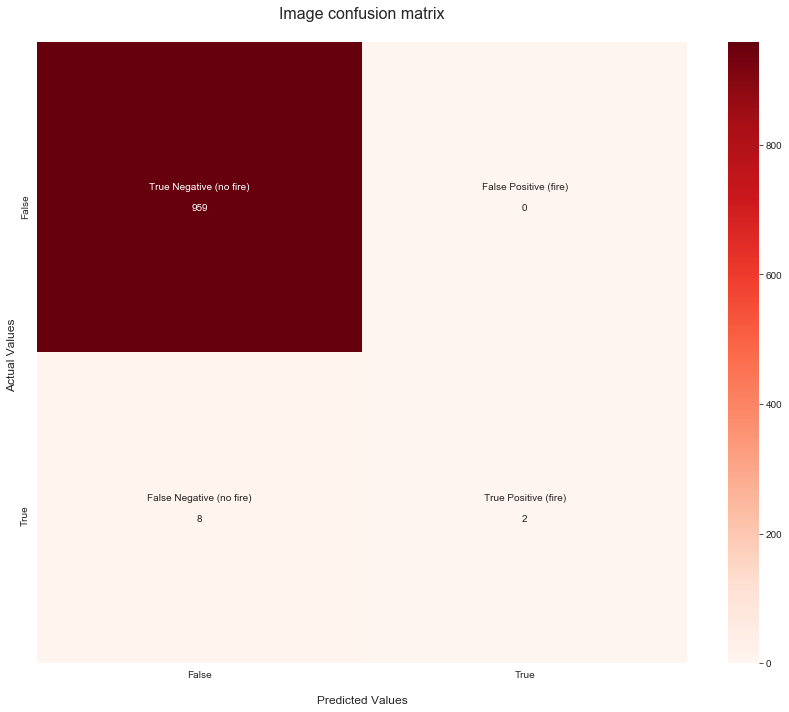

1


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
1,16,0.4,RMSprop,0.221047,0.891473,0,1,0.78125,"[[65, 0], [14, 50]]",1


31/31 [==============================] - 35s 511ms/step


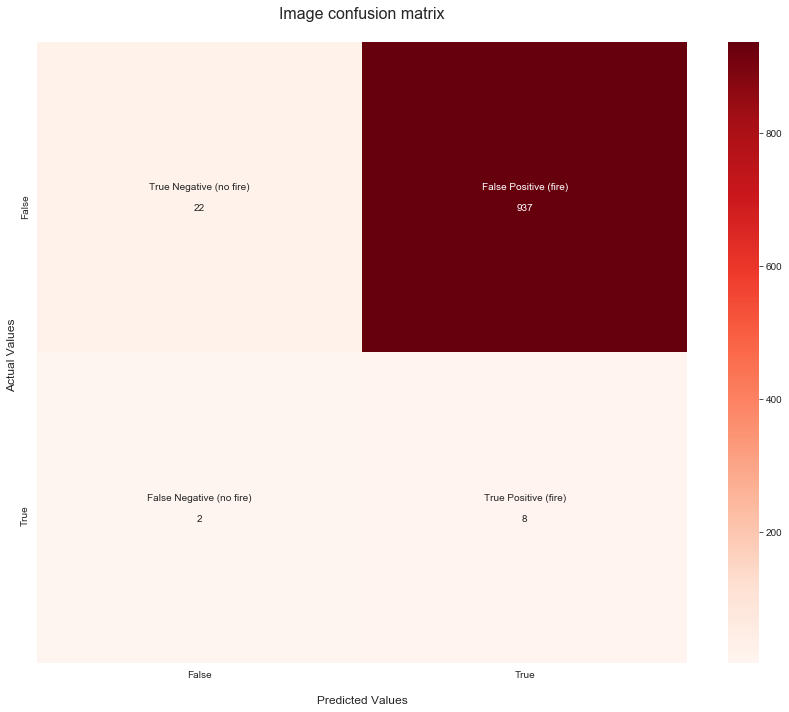

2


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
2,16,0.4,adam,0.218036,0.899225,0.986659,1,0.796875,"[[65, 0], [13, 51]]",1


31/31 [==============================] - 36s 511ms/step


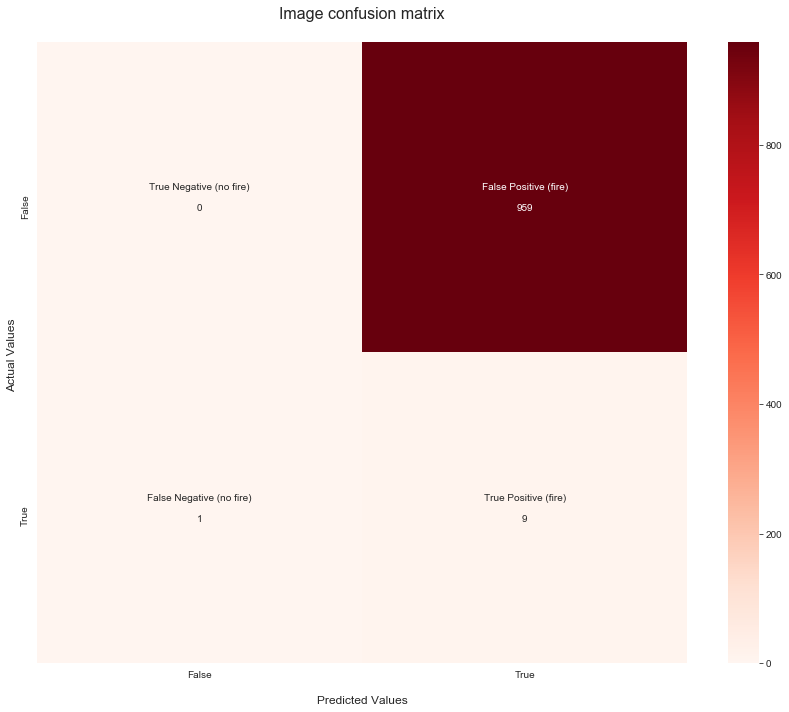

3


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
3,16,0.5,Nadam,0.32675,0.860465,0,0.838235,0.890625,"[[54, 11], [7, 57]]",1


31/31 [==============================] - 32s 505ms/step


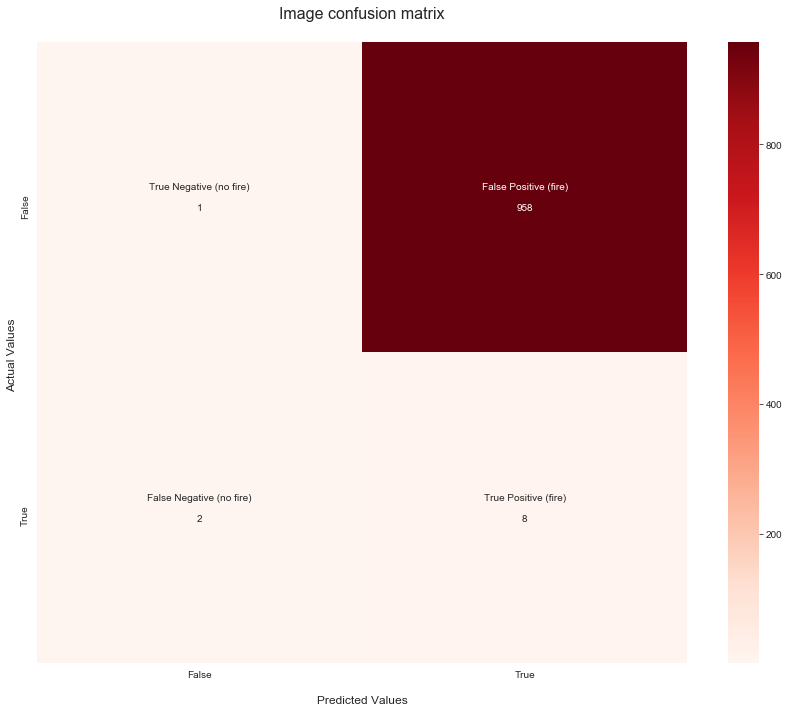

4


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
4,16,0.5,RMSprop,0.276414,0.906977,0.985457,0.981481,0.828125,"[[64, 1], [11, 53]]",1


31/31 [==============================] - 38s 512ms/step


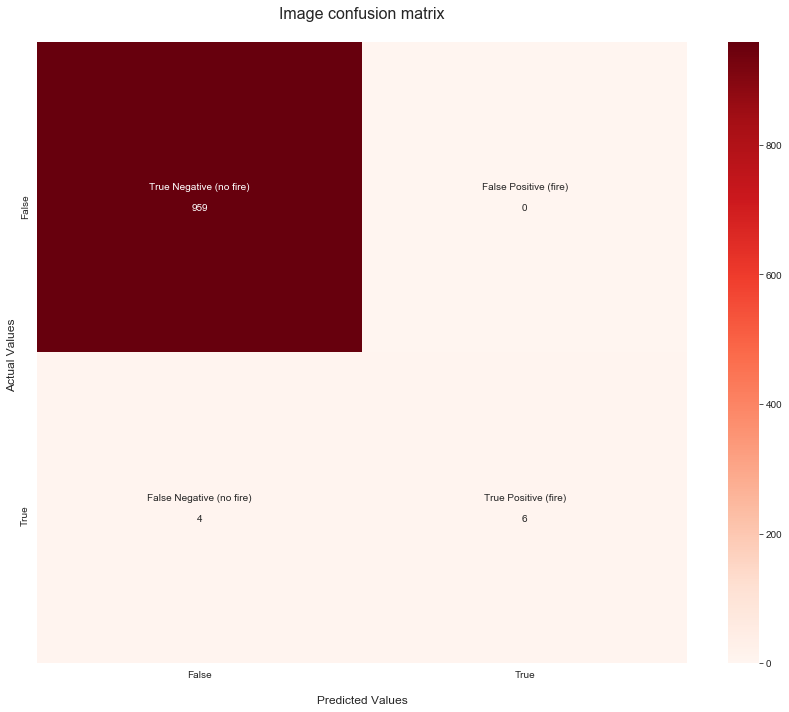

5


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
5,16,0.5,adam,0.466678,0.79845,0,1,0.59375,"[[65, 0], [26, 38]]",1


31/31 [==============================] - 33s 503ms/step


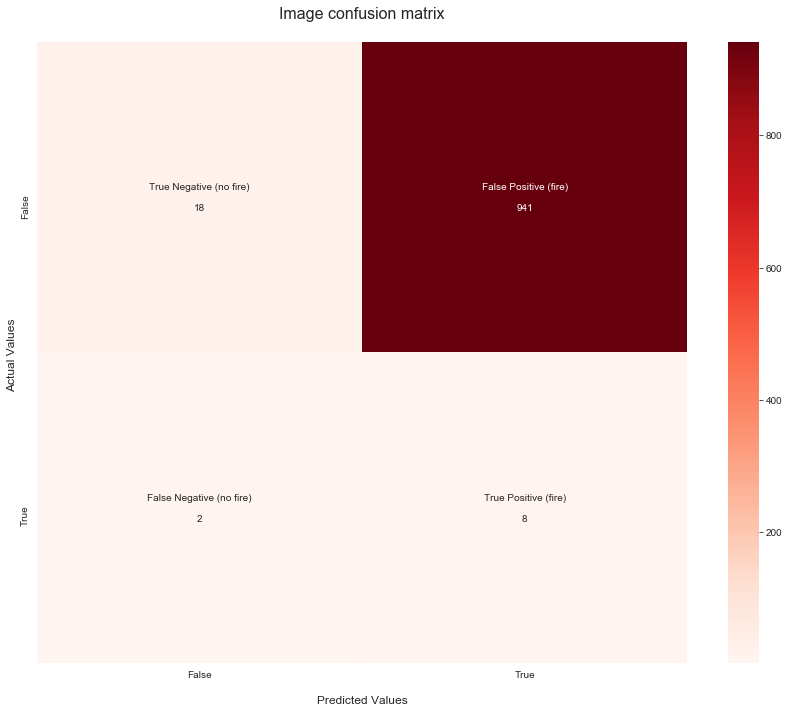

6


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
6,32,0.4,Nadam,0.549319,0.658915,0.958173,0.592593,1,"[[21, 44], [0, 64]]",1


31/31 [==============================] - 36s 504ms/step


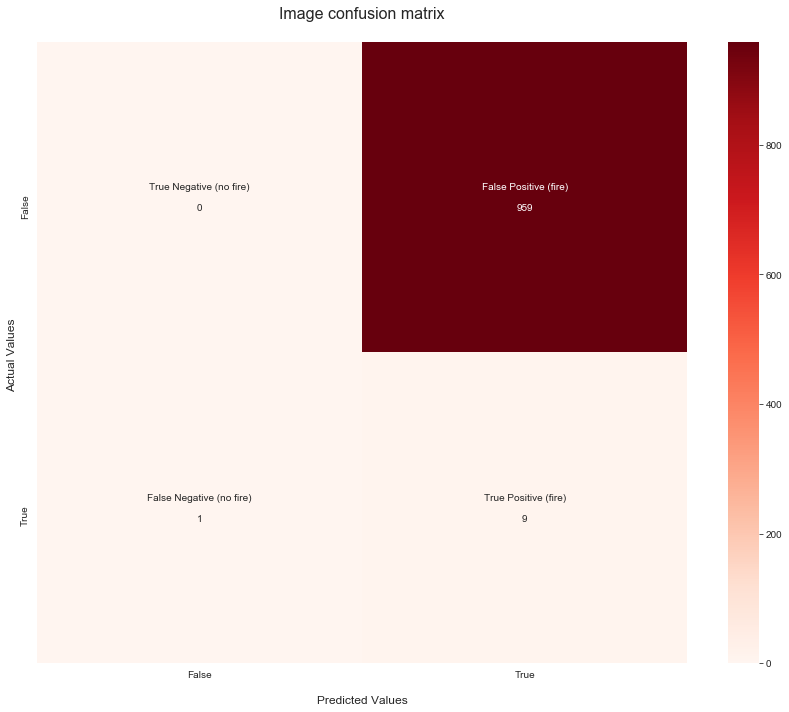

7


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
7,32,0.4,RMSprop,0.307288,0.883721,0,0.901639,0.859375,"[[59, 6], [9, 55]]",1


31/31 [==============================] - 35s 538ms/step


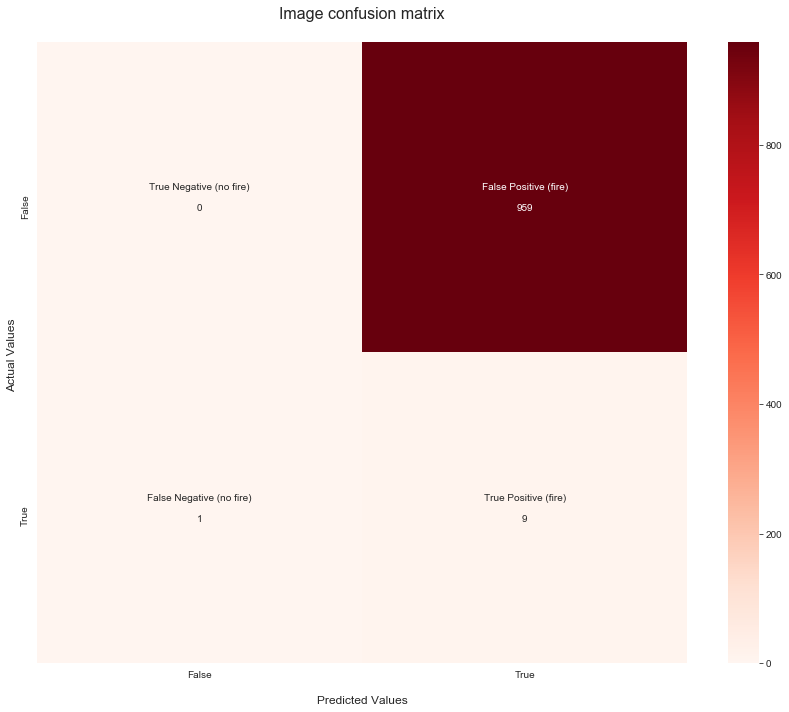

8


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
8,32,0.4,adam,0.28687,0.837209,0.982091,0.864407,0.796875,"[[57, 8], [13, 51]]",1


31/31 [==============================] - 35s 505ms/step


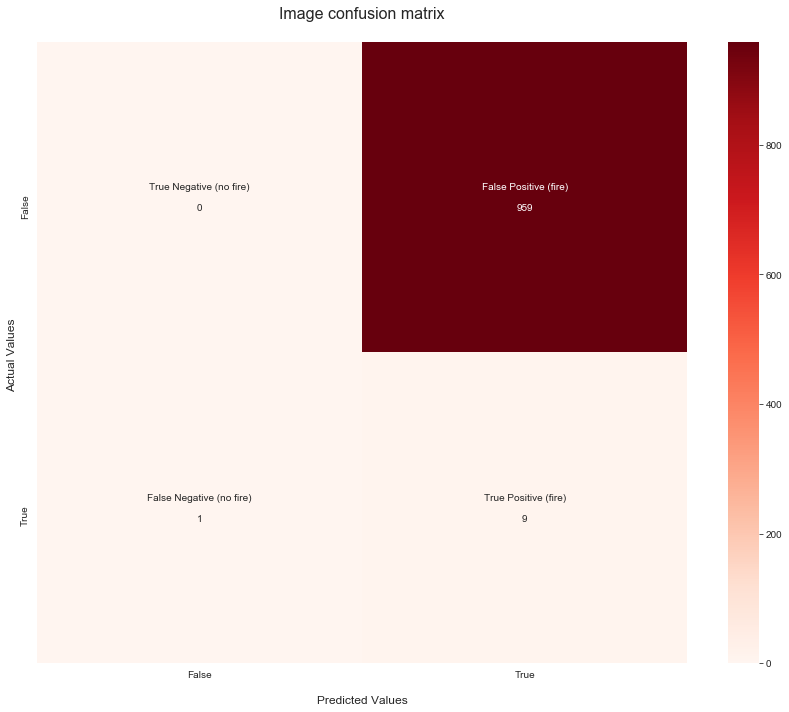

9


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
9,32,0.5,Nadam,0.401828,0.75969,0,0.673684,1,"[[34, 31], [0, 64]]",1


31/31 [==============================] - 34s 500ms/step


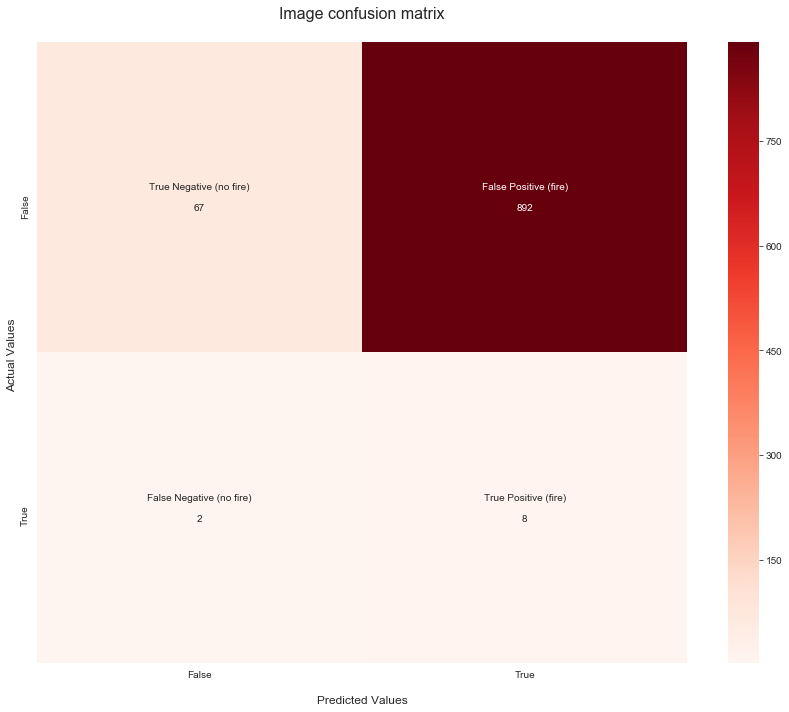

10


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
10,32,0.5,RMSprop,0.461313,0.860465,0.931611,1,0.71875,"[[65, 0], [18, 46]]",1


31/31 [==============================] - 34s 500ms/step


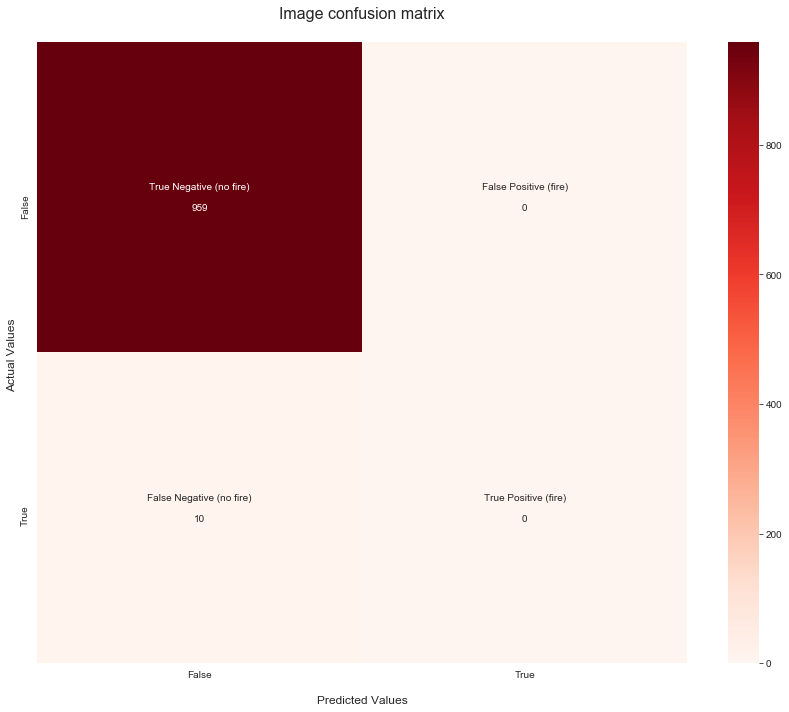

11


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
11,32,0.5,adam,0.207469,0.906977,0,0.919355,0.890625,"[[60, 5], [7, 57]]",1


31/31 [==============================] - 34s 498ms/step


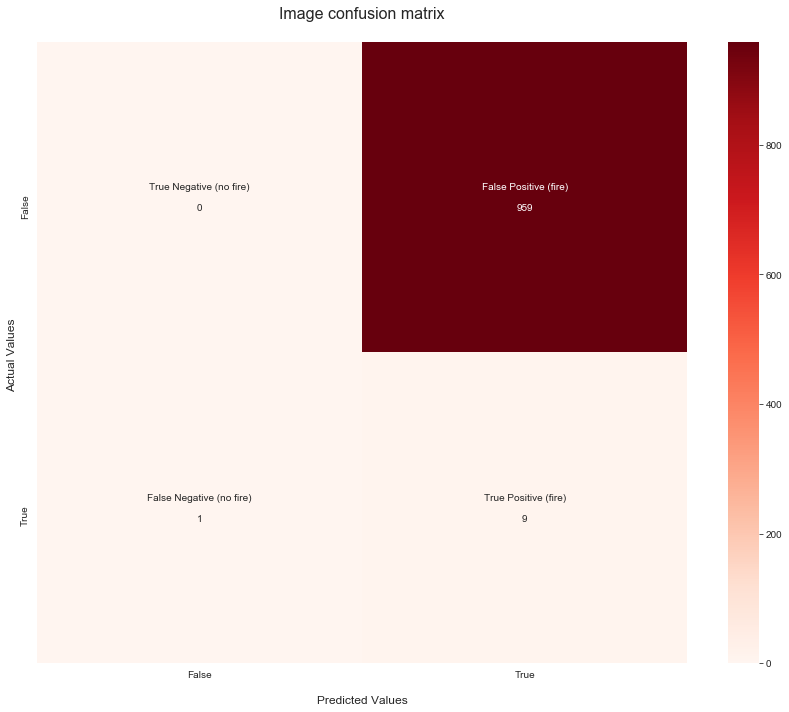

12


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
12,64,0.4,Nadam,0.613478,0.744186,0.954087,1,0.484375,"[[65, 0], [33, 31]]",1


31/31 [==============================] - 37s 506ms/step


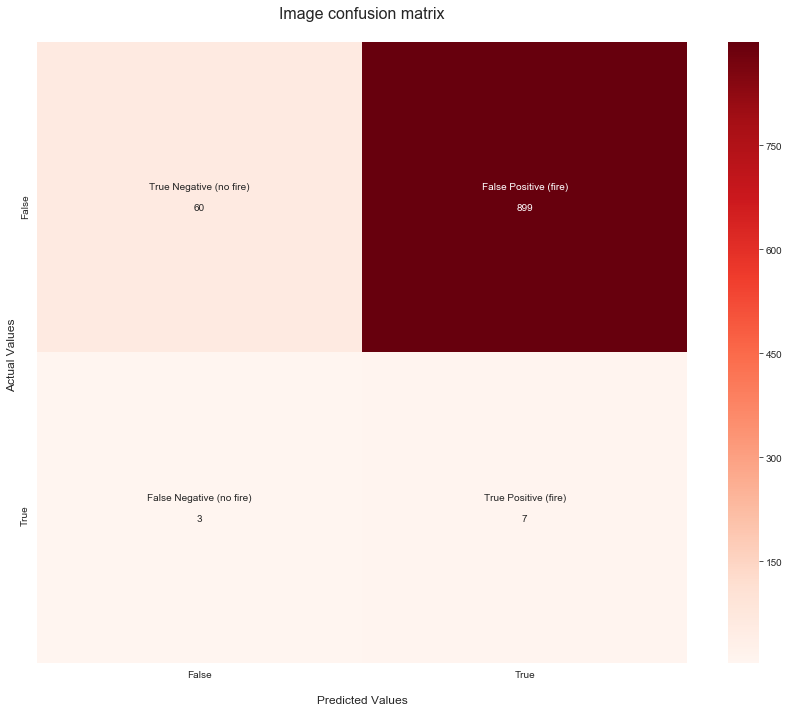

13


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
13,64,0.4,RMSprop,0.589907,0.635659,0,0.576577,1,"[[18, 47], [0, 64]]",1


31/31 [==============================] - 36s 516ms/step


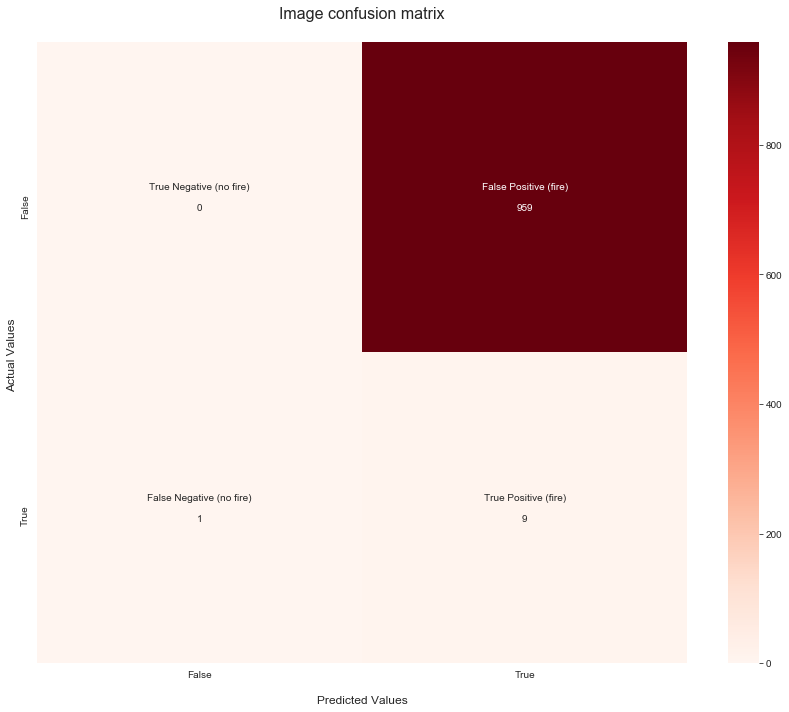

14


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
14,64,0.4,adam,0.202425,0.906977,0.957572,1,0.8125,"[[65, 0], [12, 52]]",1


31/31 [==============================] - 33s 503ms/step


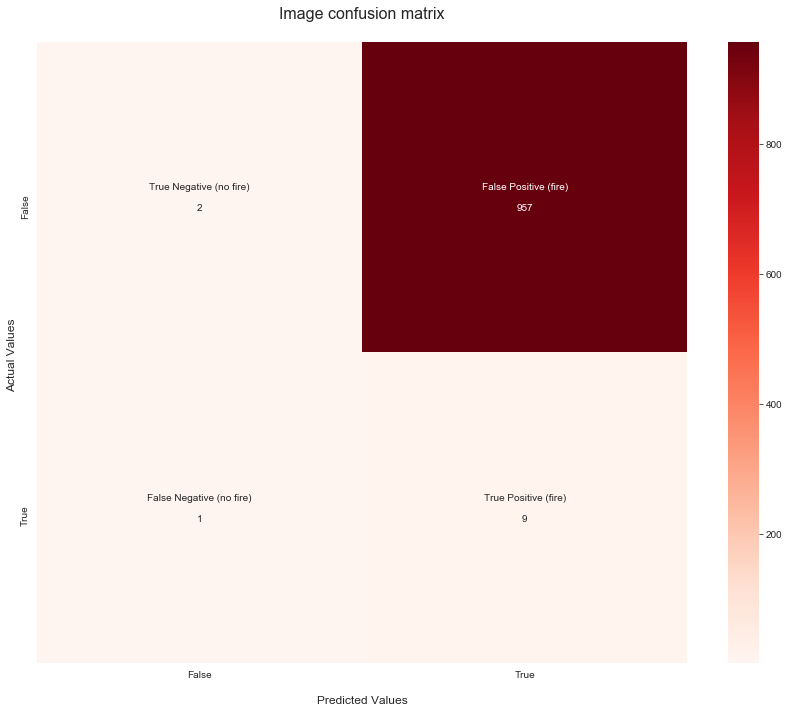

15


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
15,64,0.5,Nadam,0.294354,0.914729,0,0.873239,0.96875,"[[56, 9], [2, 62]]",1


31/31 [==============================] - 35s 500ms/step


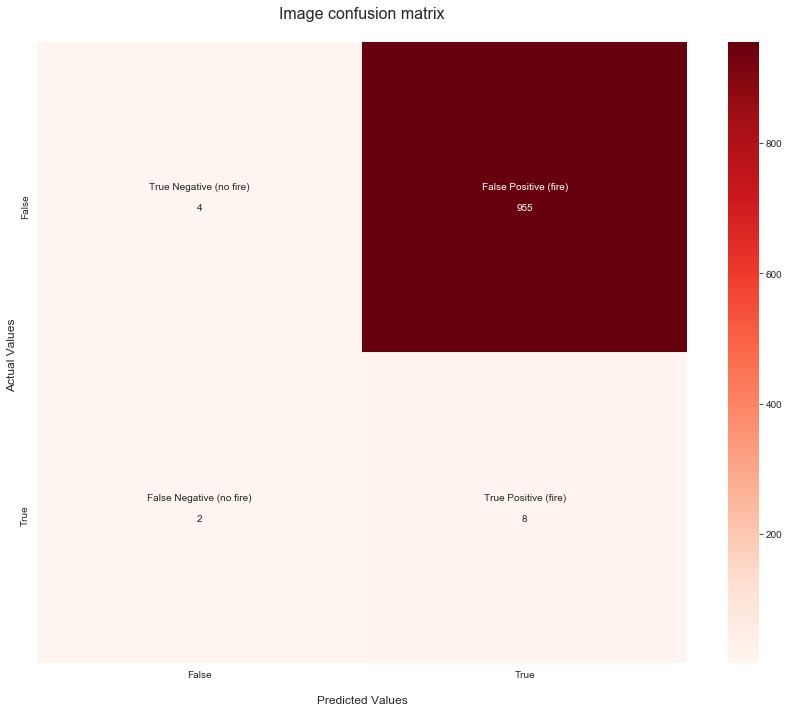

16


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
16,64,0.5,RMSprop,0.312635,0.937984,0.954327,0.9,0.984375,"[[58, 7], [1, 63]]",1


31/31 [==============================] - 35s 498ms/step


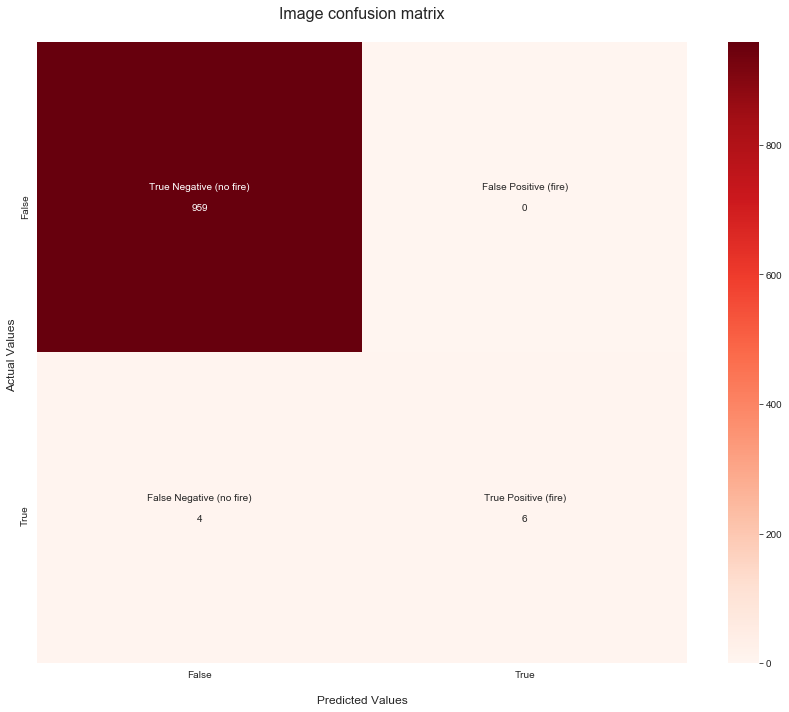

17


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
17,64,0.5,adam,0.349776,0.837209,0,1,0.671875,"[[65, 0], [21, 43]]",1


31/31 [==============================] - 32s 495ms/step


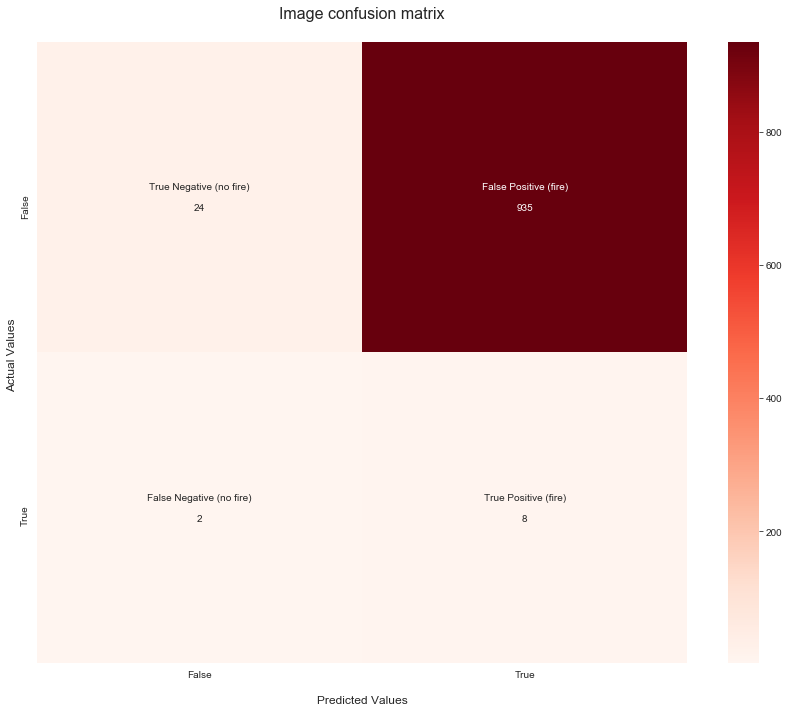

18


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
18,16,0.4,Nadam,0.191219,0.968992,0.995312,1,0.9375,"[[65, 0], [4, 60]]",2


31/31 [==============================] - 33s 489ms/step


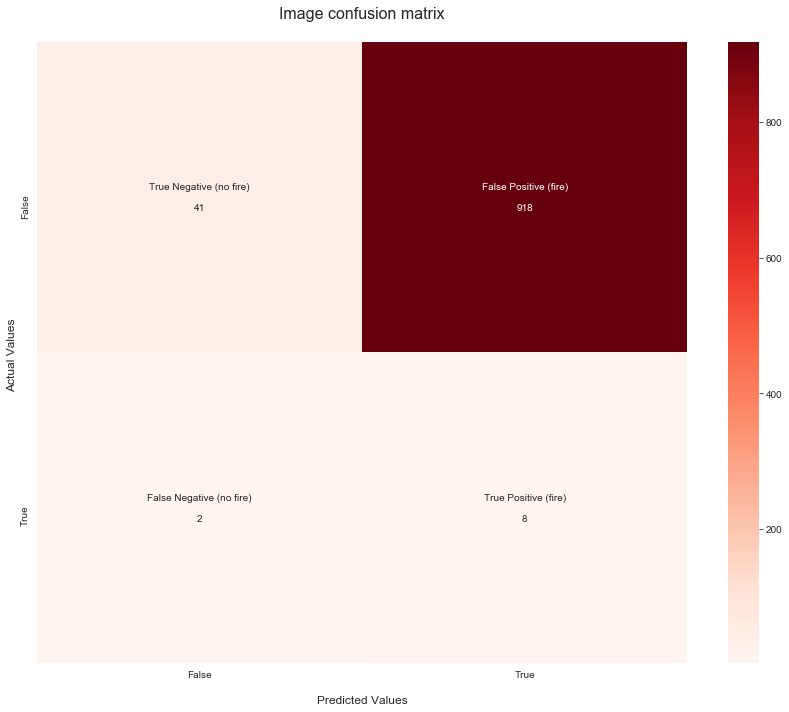

19


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
19,16,0.4,RMSprop,0.133295,0.937984,0,1,0.875,"[[65, 0], [8, 56]]",2


31/31 [==============================] - 34s 485ms/step


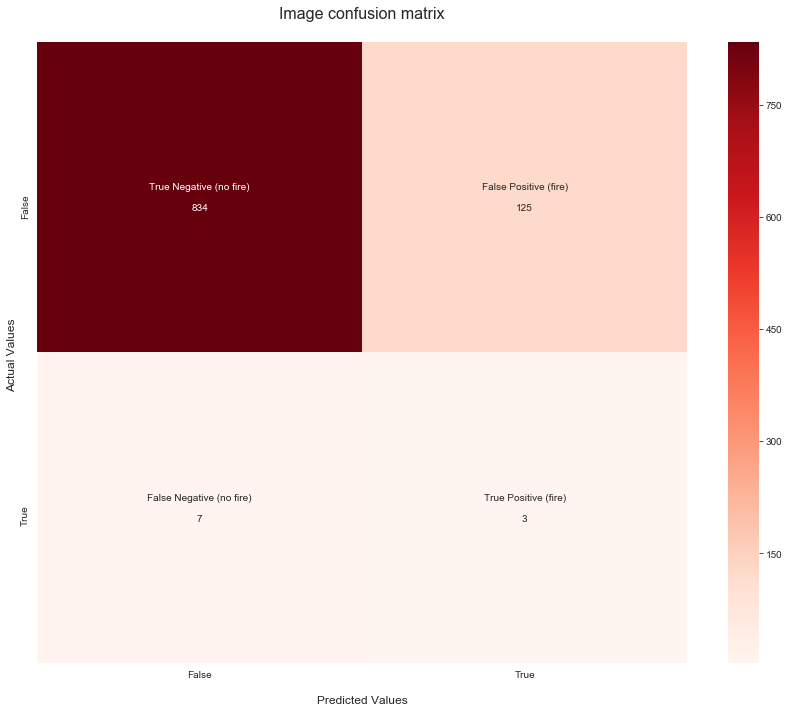

20


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
20,16,0.4,adam,0.0760468,0.976744,0.969471,0.984127,0.96875,"[[64, 1], [2, 62]]",2


31/31 [==============================] - 33s 489ms/step


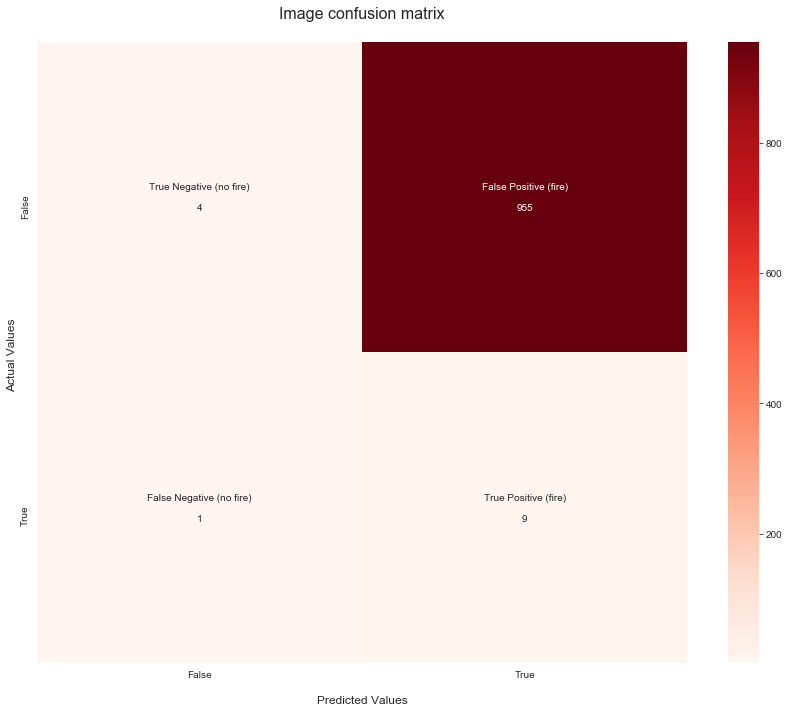

21


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
21,16,0.5,Nadam,0.116783,0.953488,0,1,0.90625,"[[65, 0], [6, 58]]",2


31/31 [==============================] - 33s 483ms/step


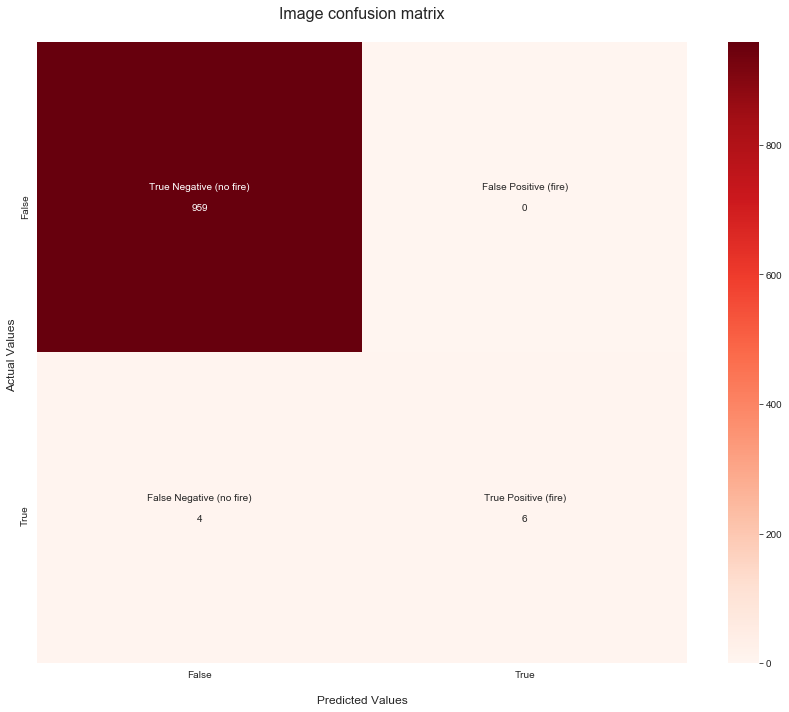

22


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
22,16,0.5,RMSprop,0.486121,0.899225,0.989062,1,0.796875,"[[65, 0], [13, 51]]",2


31/31 [==============================] - 38s 484ms/step


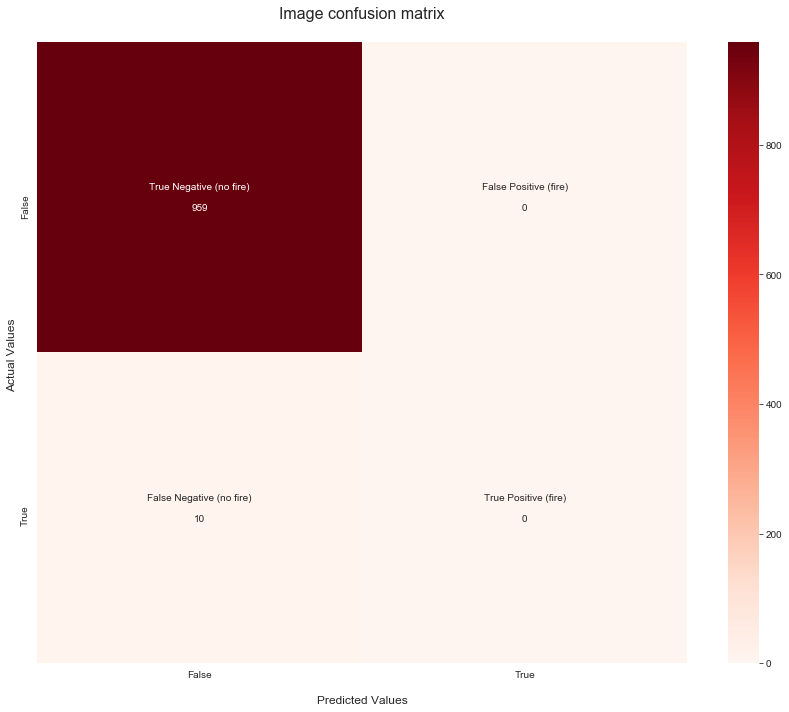

23


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
23,16,0.5,adam,0.48735,0.899225,0,0.981132,0.8125,"[[64, 1], [12, 52]]",2


31/31 [==============================] - 32s 478ms/step


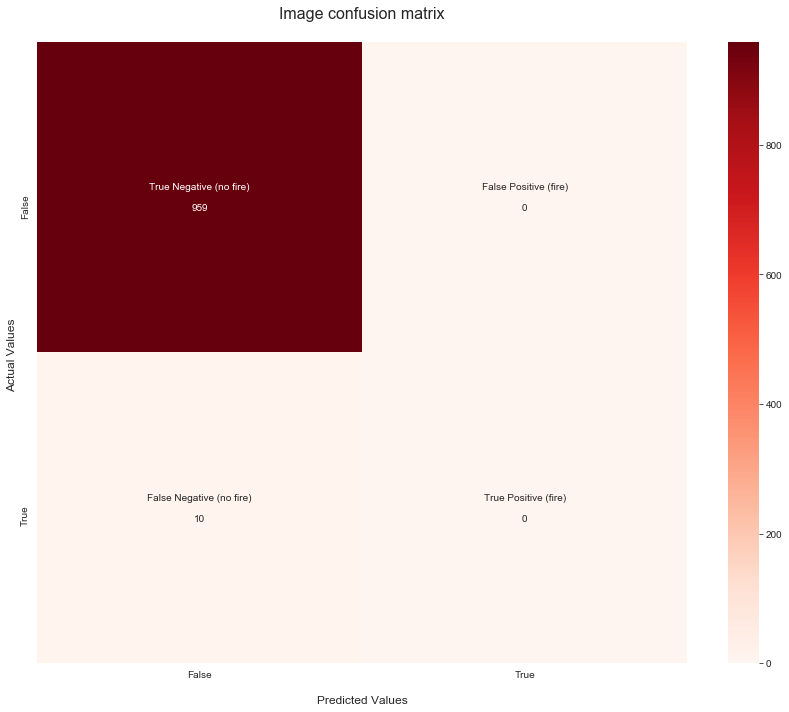

24


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
24,32,0.4,Nadam,0.0606947,0.976744,0.94976,0.969231,0.984375,"[[63, 2], [1, 63]]",2


31/31 [==============================] - 33s 477ms/step


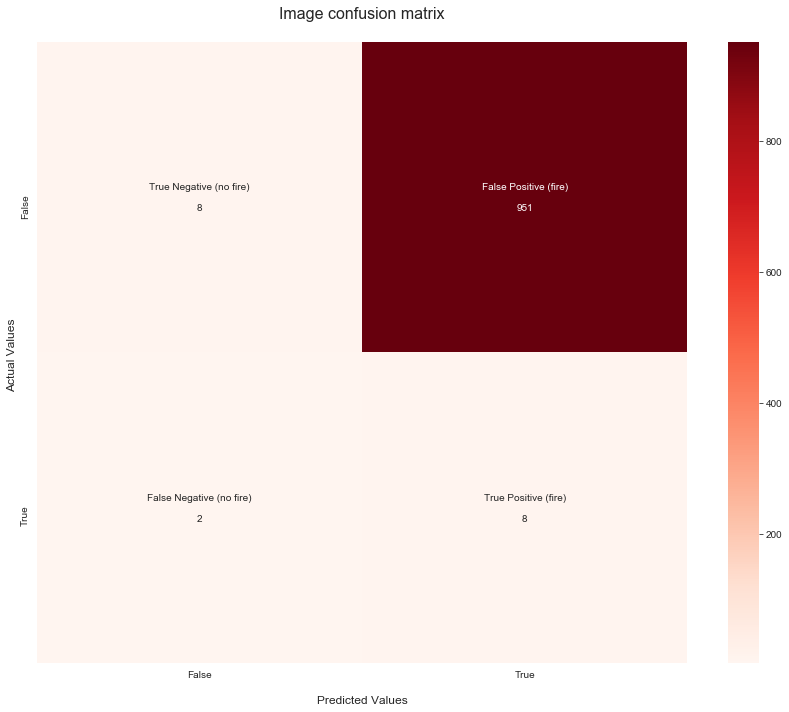

25


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
25,32,0.4,RMSprop,0.107503,0.96124,0,1,0.921875,"[[65, 0], [5, 59]]",2


31/31 [==============================] - 32s 476ms/step


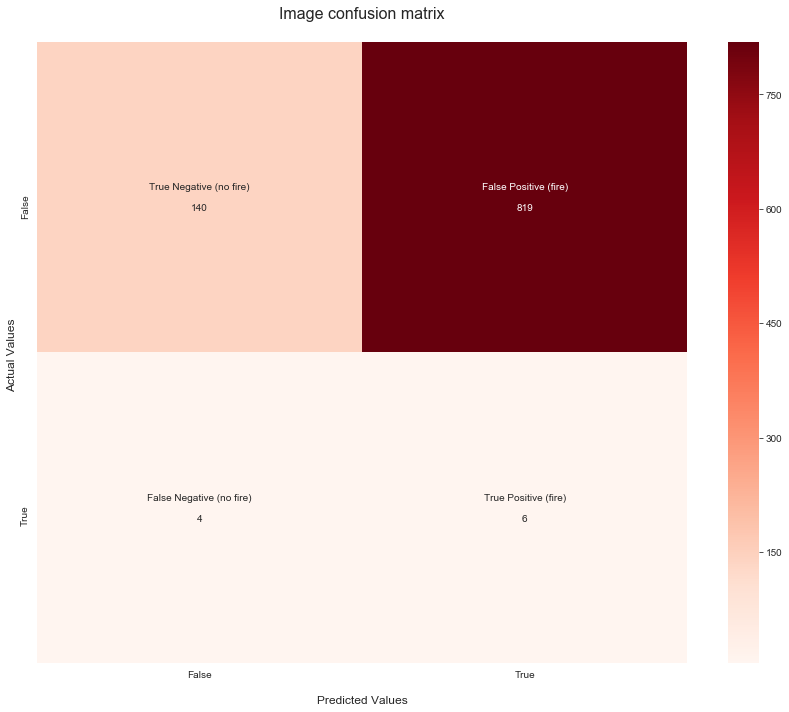

26


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
26,32,0.4,adam,0.0893198,0.984496,0.946154,1,0.96875,"[[65, 0], [2, 62]]",2


31/31 [==============================] - 35s 480ms/step


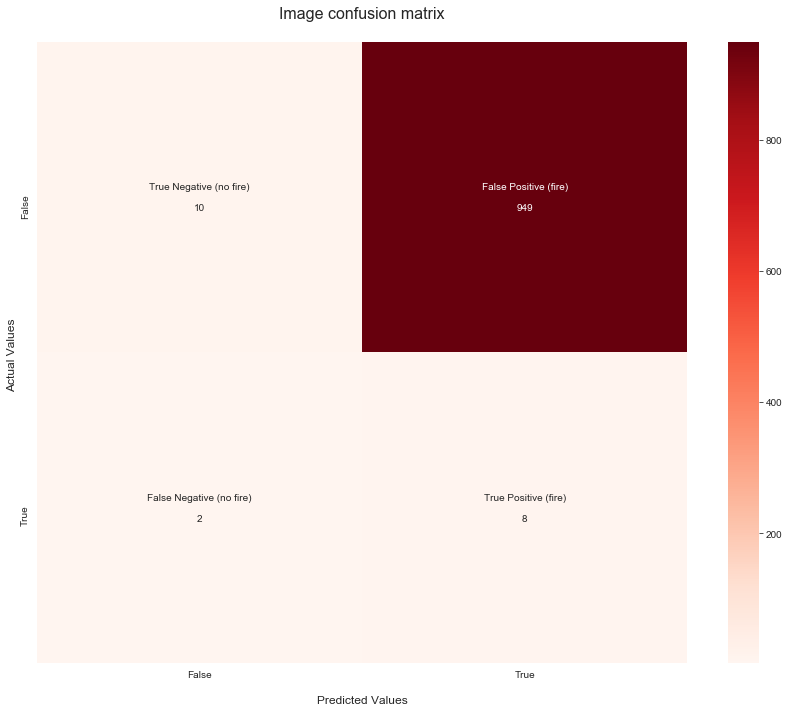

27


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
27,32,0.5,Nadam,0.0789617,0.984496,0,1,0.96875,"[[65, 0], [2, 62]]",2


31/31 [==============================] - 36s 466ms/step


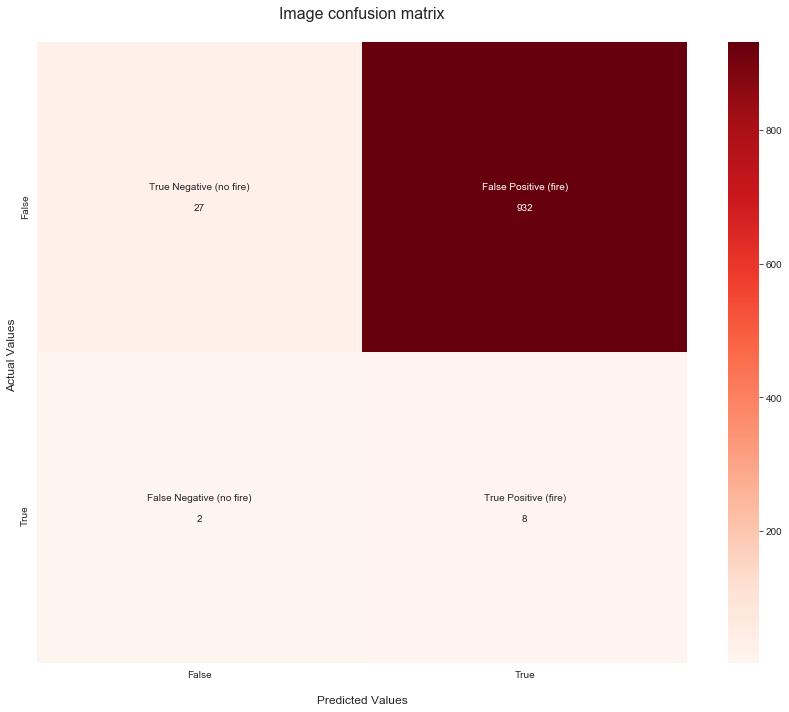

28


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
28,32,0.5,RMSprop,0.0640019,0.984496,0.990024,0.984375,0.984375,"[[64, 1], [1, 63]]",2


31/31 [==============================] - 34s 498ms/step


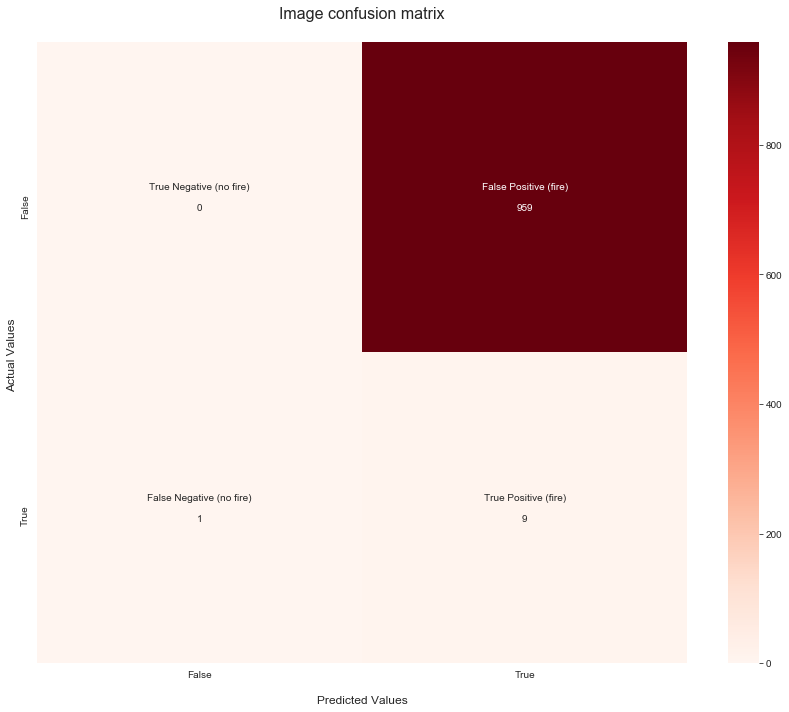

29


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
29,32,0.5,adam,0.148861,0.922481,0,1,0.84375,"[[65, 0], [10, 54]]",2


31/31 [==============================] - 32s 503ms/step


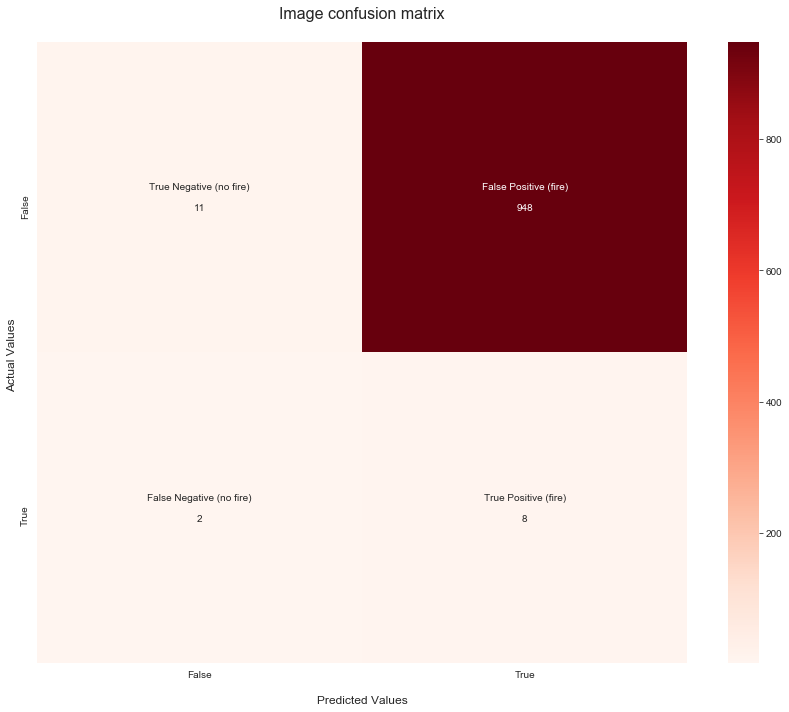

30


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
30,64,0.4,Nadam,0.122803,0.976744,0.985817,0.955224,1,"[[62, 3], [0, 64]]",2


31/31 [==============================] - 33s 496ms/step


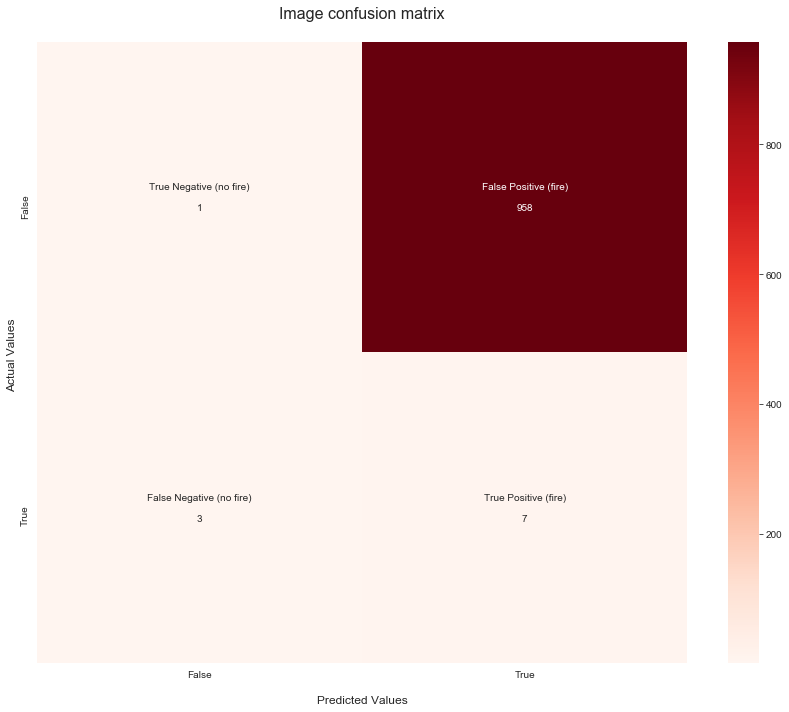

31


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
31,64,0.4,RMSprop,0.0818716,0.976744,0,0.955224,1,"[[62, 3], [0, 64]]",2


31/31 [==============================] - 35s 476ms/step


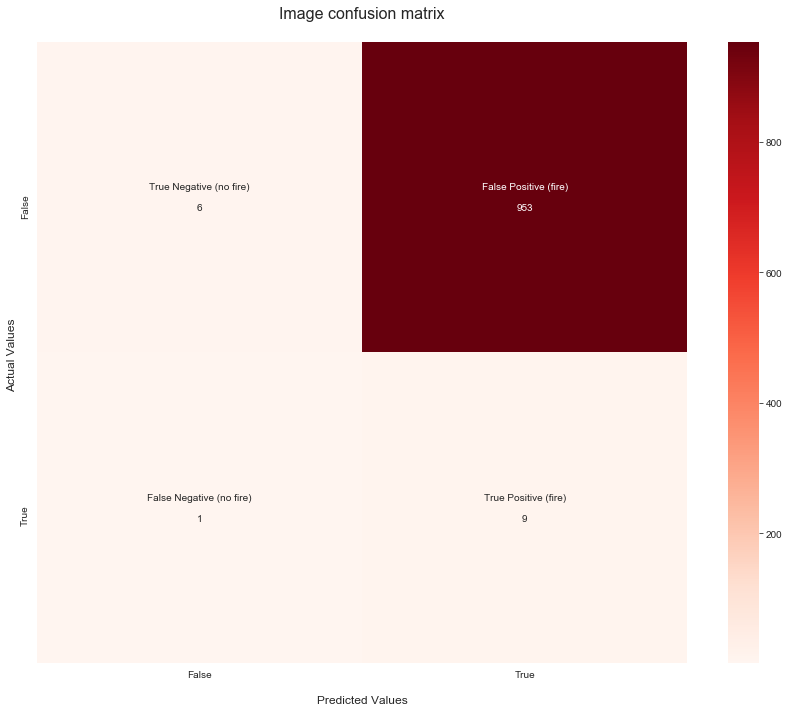

32


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
32,64,0.4,adam,0.109687,0.968992,0.994111,1,0.9375,"[[65, 0], [4, 60]]",2


31/31 [==============================] - 35s 522ms/step


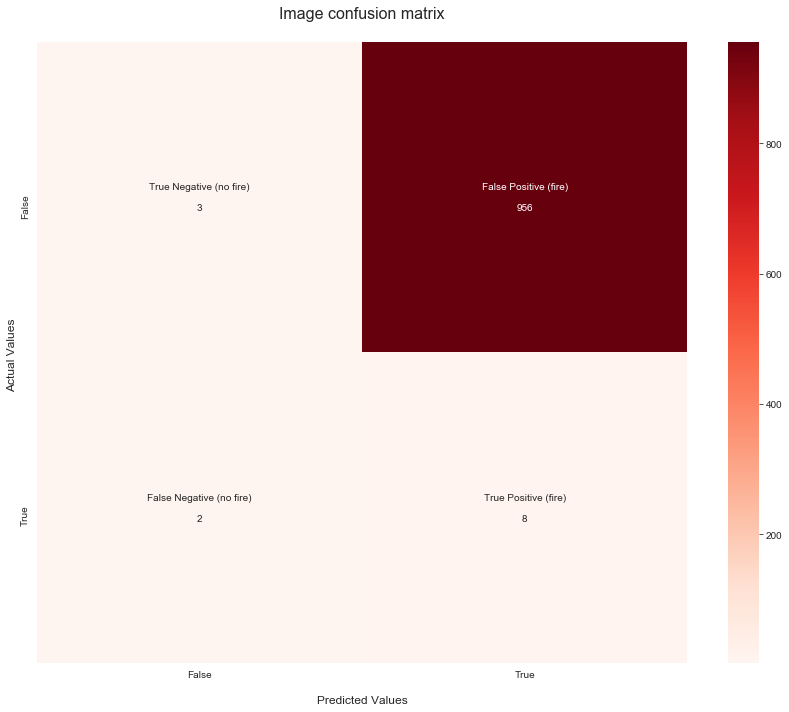

33


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
33,64,0.5,Nadam,0.0759033,0.976744,0,0.955224,1,"[[62, 3], [0, 64]]",2


31/31 [==============================] - 34s 459ms/step


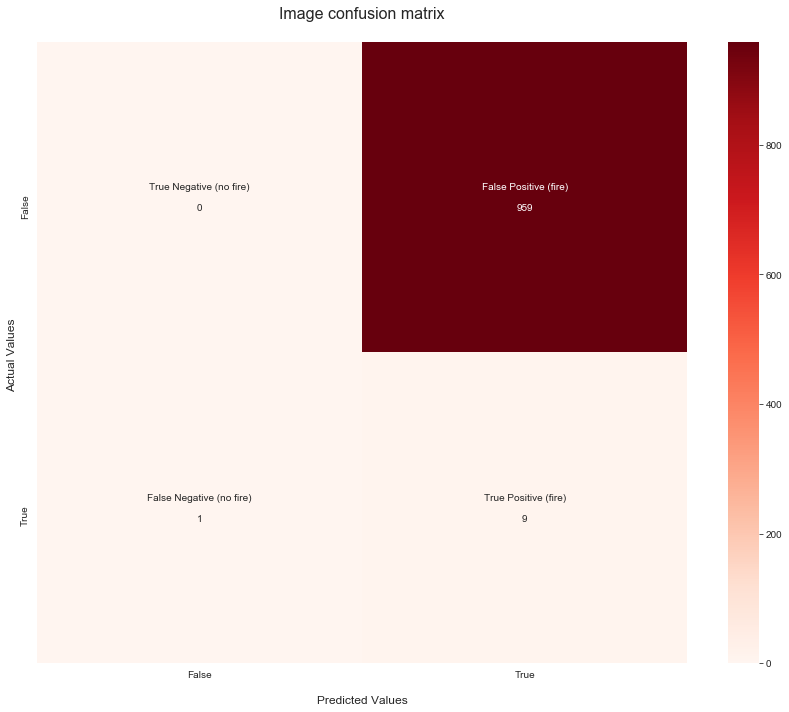

34


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
34,64,0.5,RMSprop,0.103766,0.976744,0.960096,1,0.953125,"[[65, 0], [3, 61]]",2


31/31 [==============================] - 32s 460ms/step


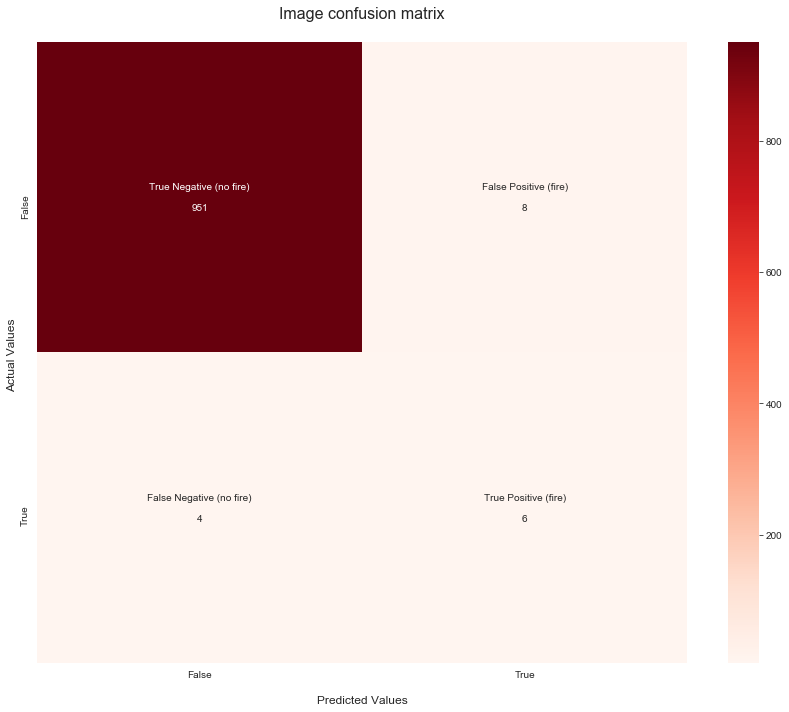

35


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
35,64,0.5,adam,0.227687,0.922481,0,1,0.84375,"[[65, 0], [10, 54]]",2


31/31 [==============================] - 33s 451ms/step


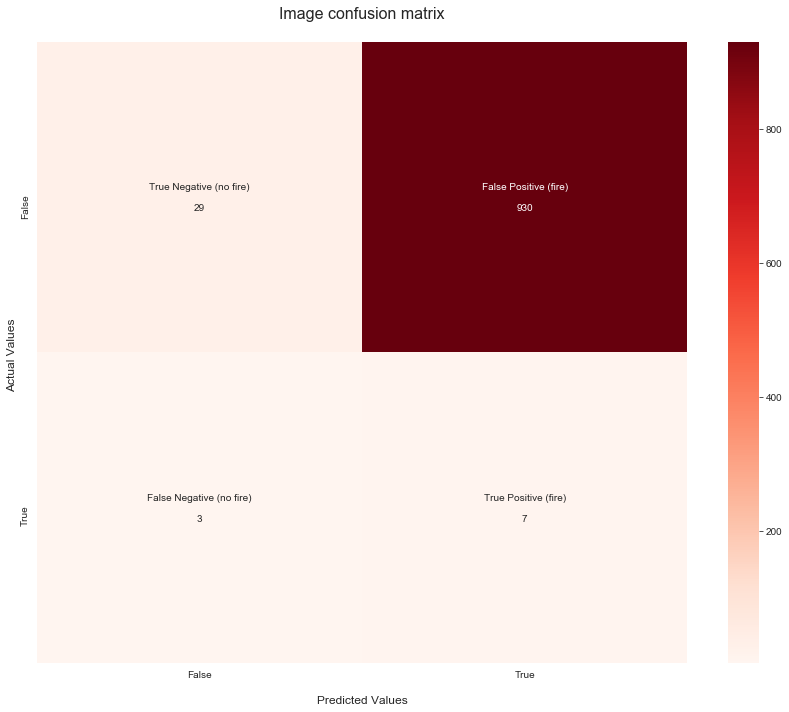

36


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
36,16,0.4,Nadam,0.336034,0.860465,0.985817,0.780488,1,"[[47, 18], [0, 64]]",3


31/31 [==============================] - 32s 449ms/step


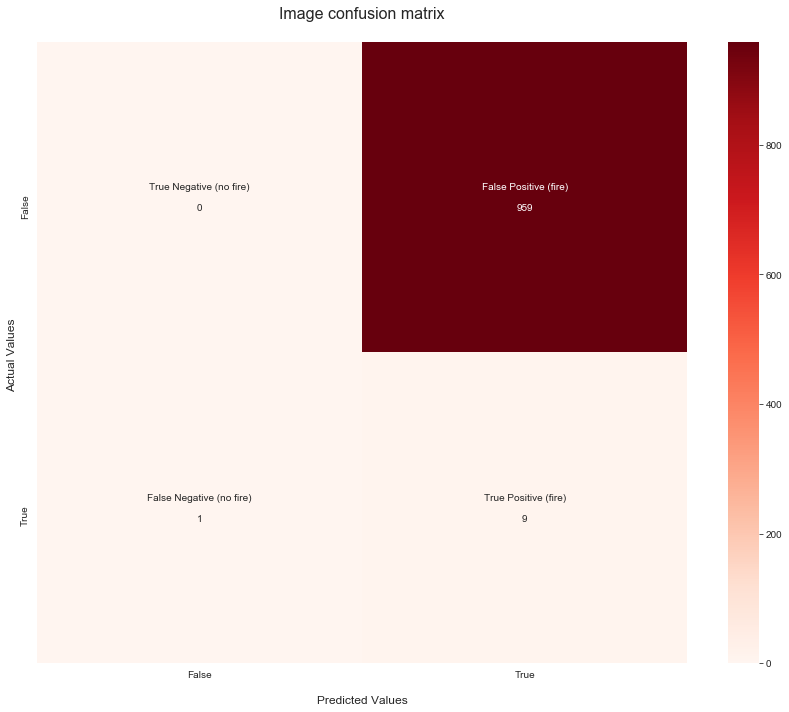

37


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
37,16,0.4,RMSprop,0.0527659,0.976744,0,1,0.953125,"[[65, 0], [3, 61]]",3


31/31 [==============================] - 34s 438ms/step


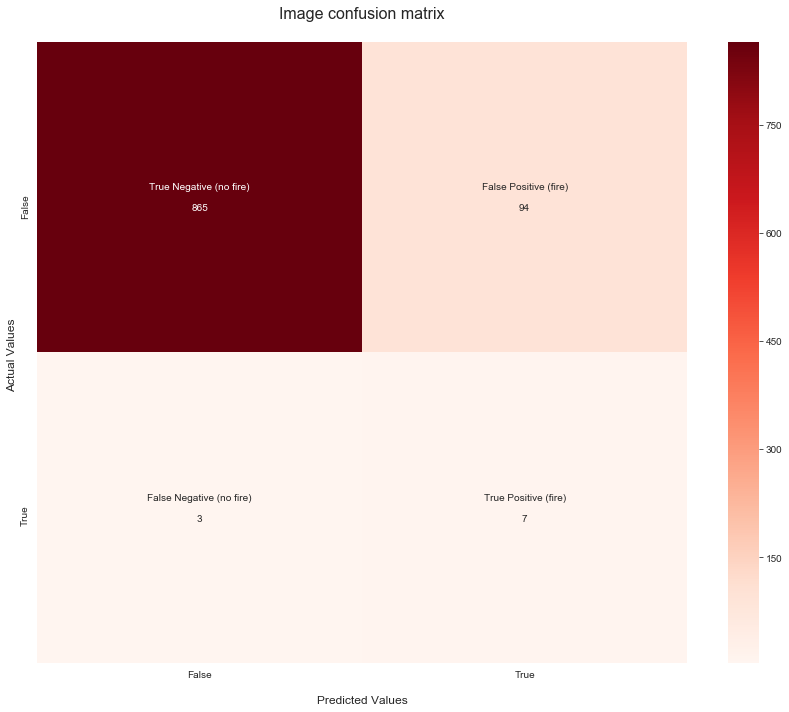

38


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
38,16,0.4,adam,0.0942758,0.984496,0.996995,0.969697,1,"[[63, 2], [0, 64]]",3


31/31 [==============================] - 33s 436ms/step


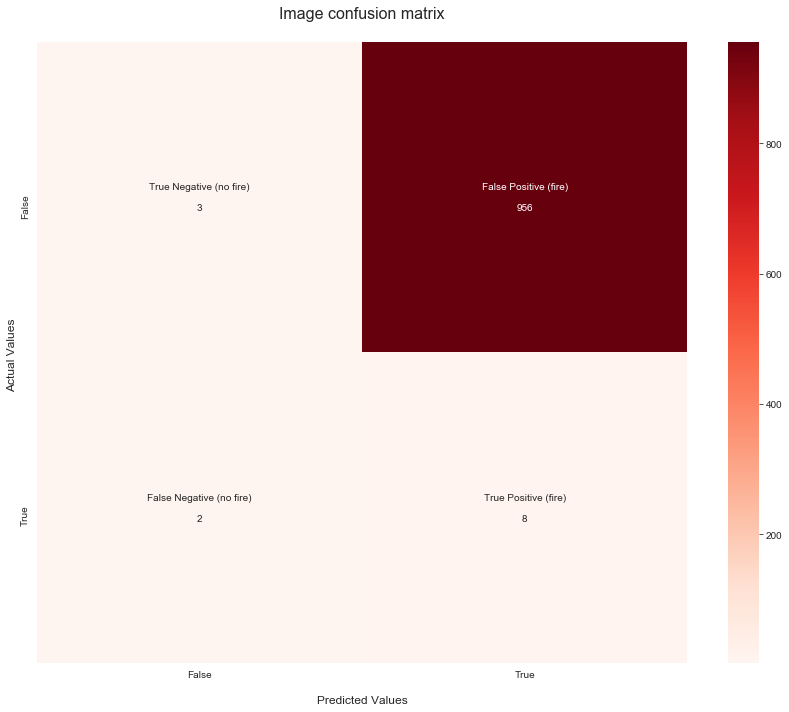

39


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
39,16,0.5,Nadam,0.174256,0.953488,0,1,0.90625,"[[65, 0], [6, 58]]",3


31/31 [==============================] - 32s 433ms/step


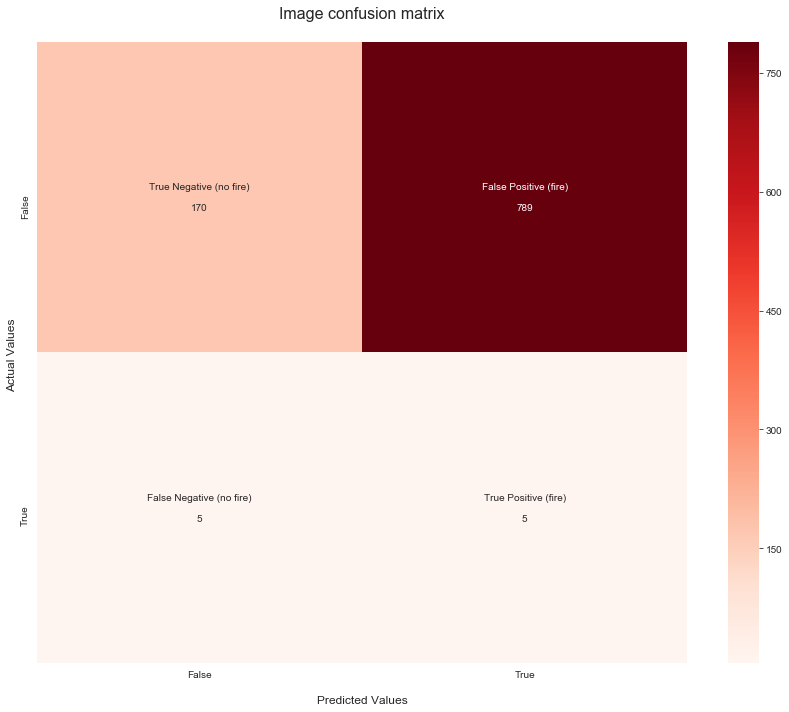

40


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
40,16,0.5,RMSprop,0.0708506,0.976744,0.998077,1,0.953125,"[[65, 0], [3, 61]]",3


31/31 [==============================] - 31s 431ms/step


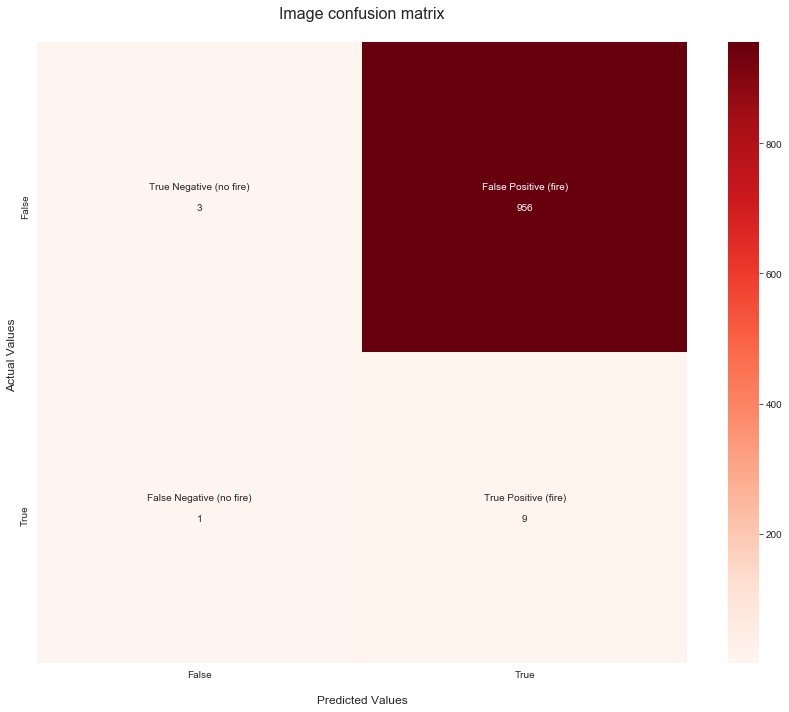

41


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
41,16,0.5,adam,0.16041,0.968992,0,1,0.9375,"[[65, 0], [4, 60]]",3


31/31 [==============================] - 31s 427ms/step


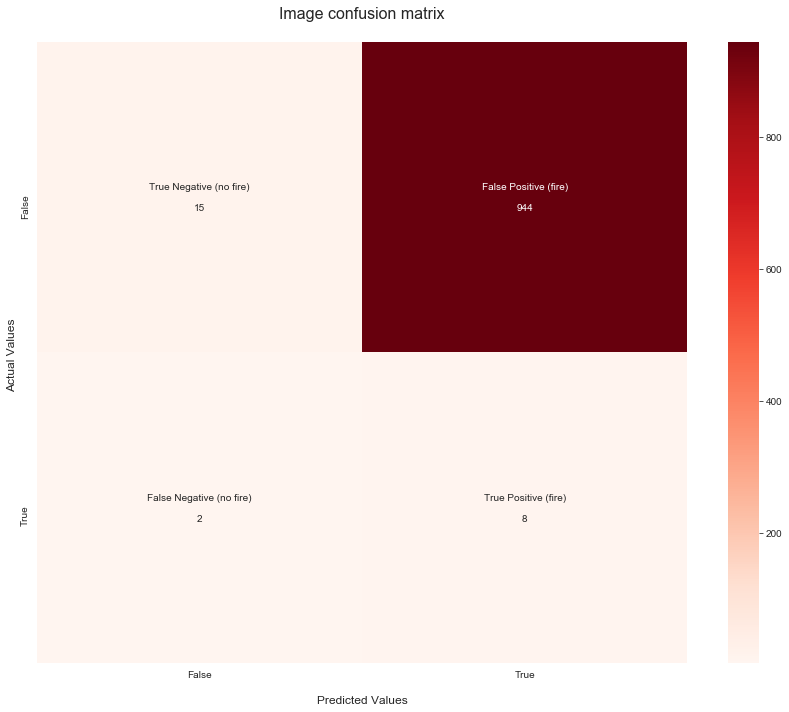

42


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
42,32,0.4,Nadam,0.110409,0.976744,0.992548,1,0.953125,"[[65, 0], [3, 61]]",3


31/31 [==============================] - 32s 436ms/step


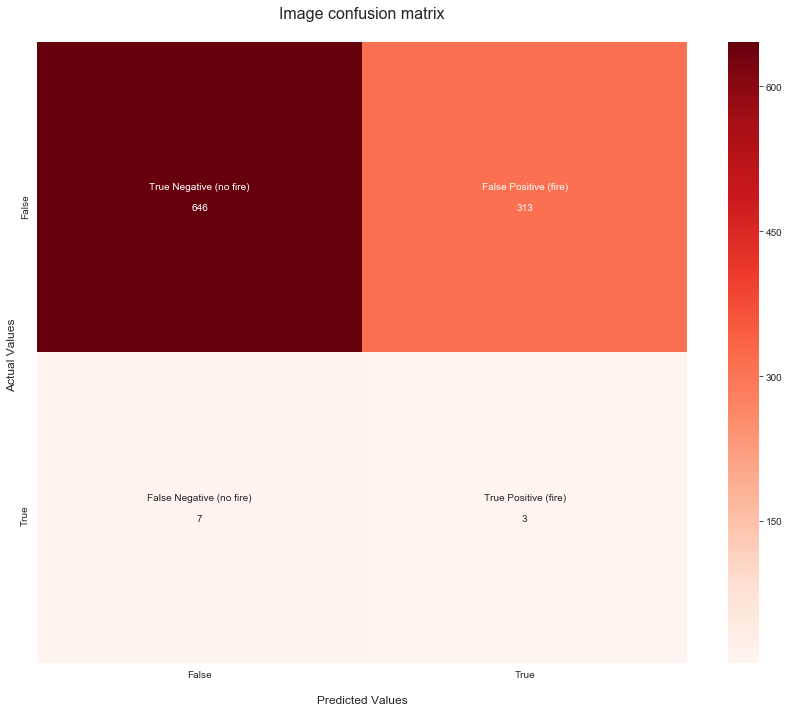

43


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
43,32,0.4,RMSprop,0.21154,0.922481,0,1,0.84375,"[[65, 0], [10, 54]]",3


31/31 [==============================] - 31s 425ms/step


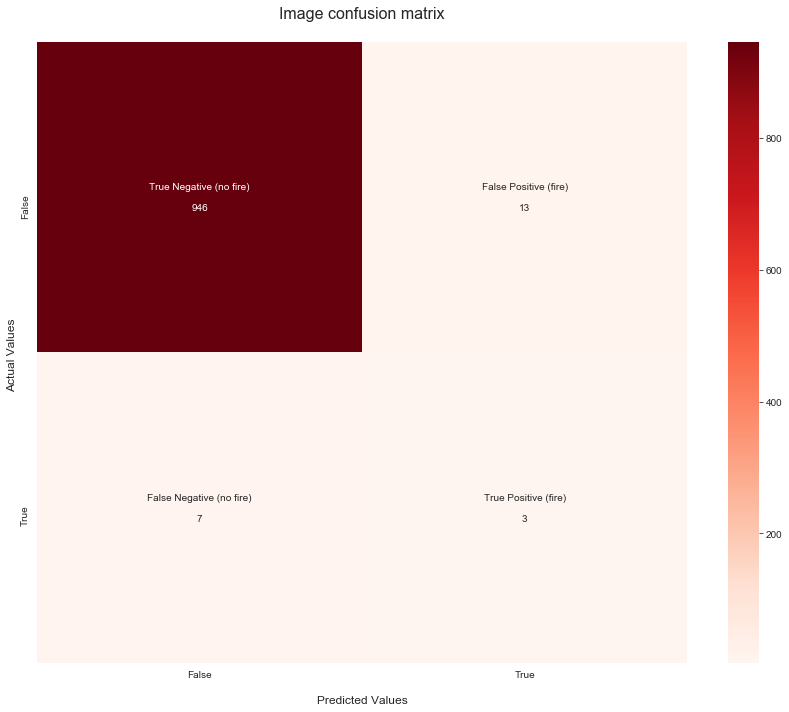

44


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
44,32,0.4,adam,0.0216056,0.992248,0.952404,1,0.984375,"[[65, 0], [1, 63]]",3


31/31 [==============================] - 31s 421ms/step


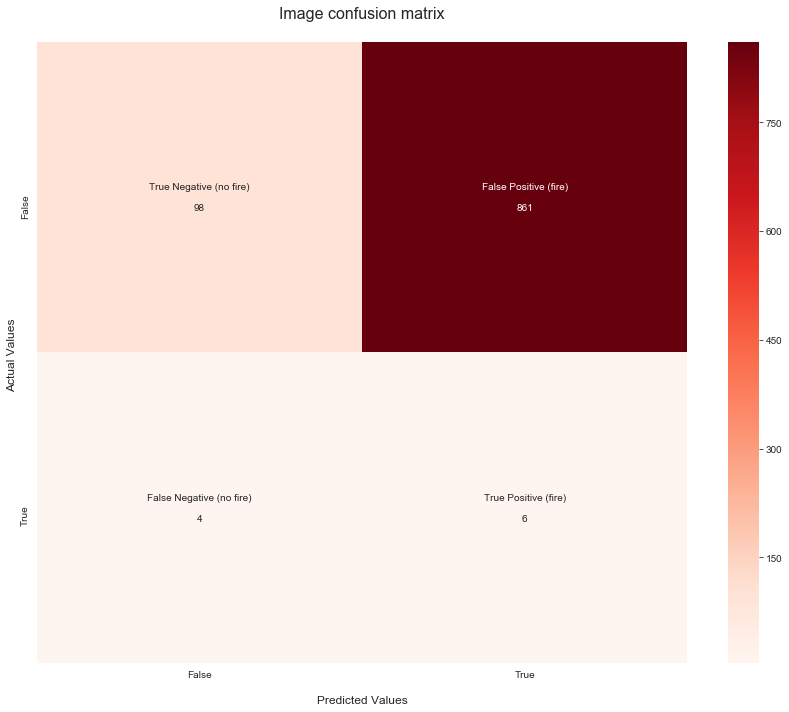

45


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
45,32,0.5,Nadam,0.116122,0.937984,0,1,0.875,"[[65, 0], [8, 56]]",3


31/31 [==============================] - 30s 418ms/step


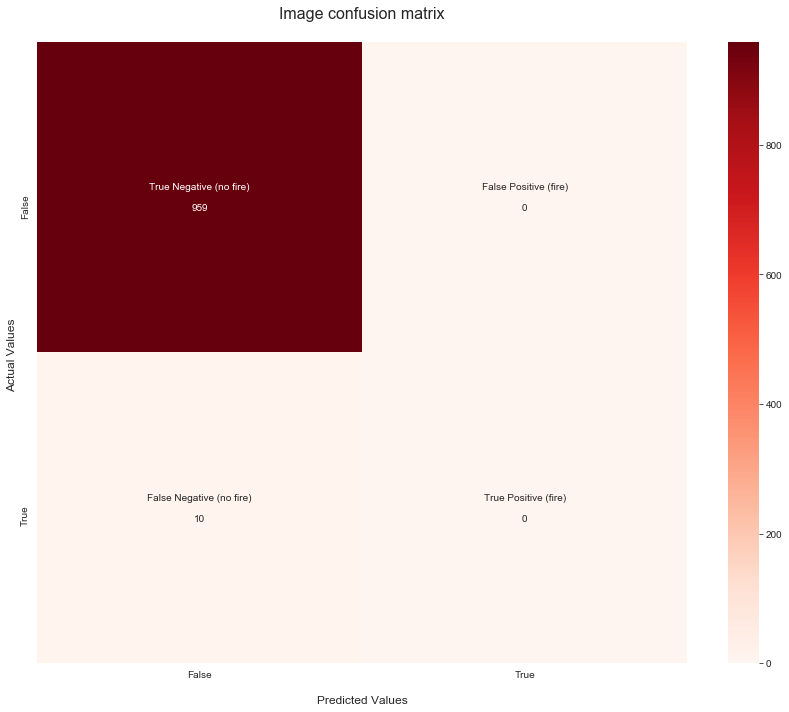

46


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
46,32,0.5,RMSprop,0.0433829,0.976744,0.976082,0.969231,0.984375,"[[63, 2], [1, 63]]",3


31/31 [==============================] - 30s 416ms/step


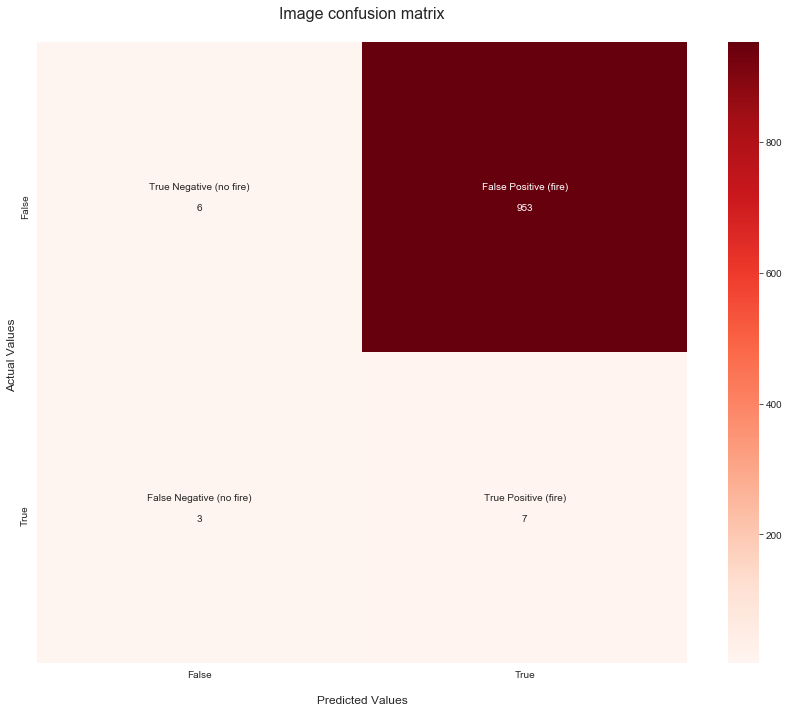

47


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
47,32,0.5,adam,0.0602833,0.976744,0,0.984127,0.96875,"[[64, 1], [2, 62]]",3


31/31 [==============================] - 32s 411ms/step


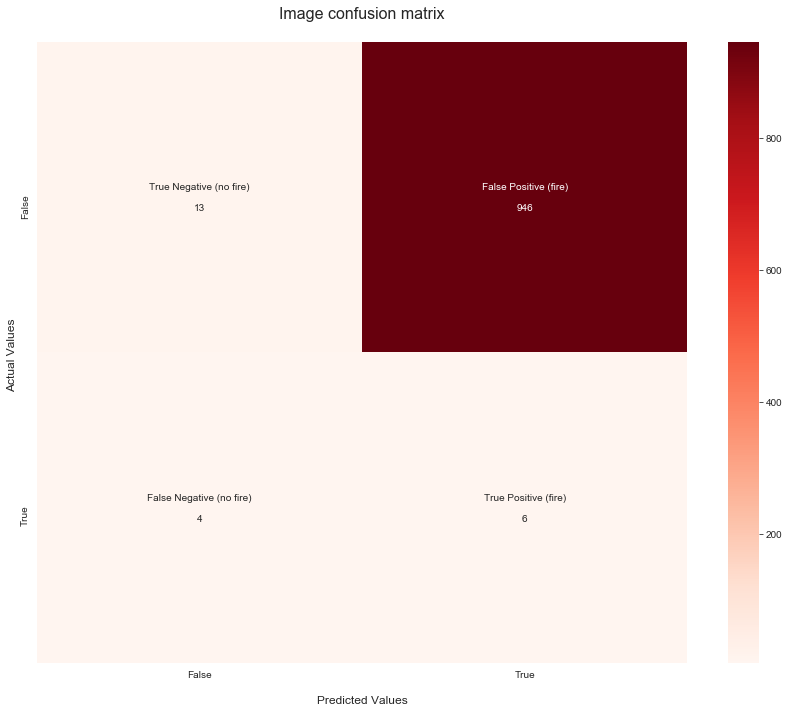

48


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
48,64,0.4,Nadam,0.0544688,0.984496,0.999038,1,0.96875,"[[65, 0], [2, 62]]",3


31/31 [==============================] - 30s 413ms/step


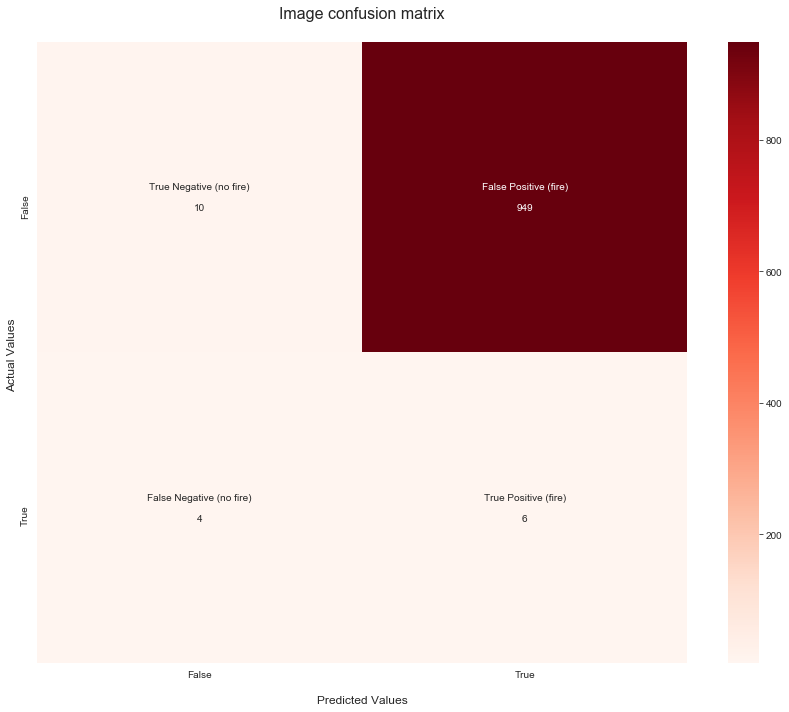

49


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
49,64,0.4,RMSprop,0.0443396,0.976744,0,1,0.953125,"[[65, 0], [3, 61]]",3


31/31 [==============================] - 32s 409ms/step


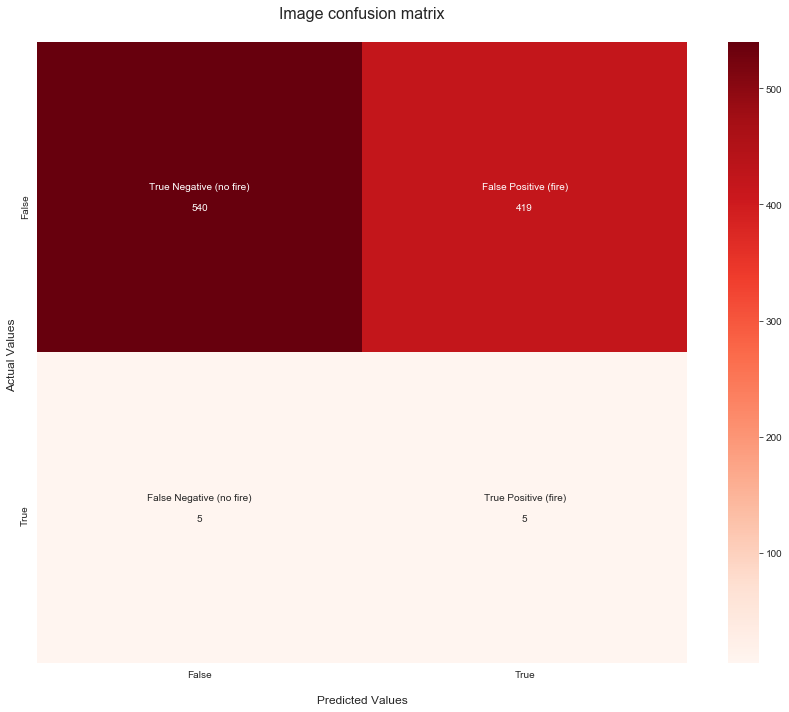

50


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
50,64,0.4,adam,0.0435045,0.976744,0.995313,1,0.953125,"[[65, 0], [3, 61]]",3


31/31 [==============================] - 30s 405ms/step


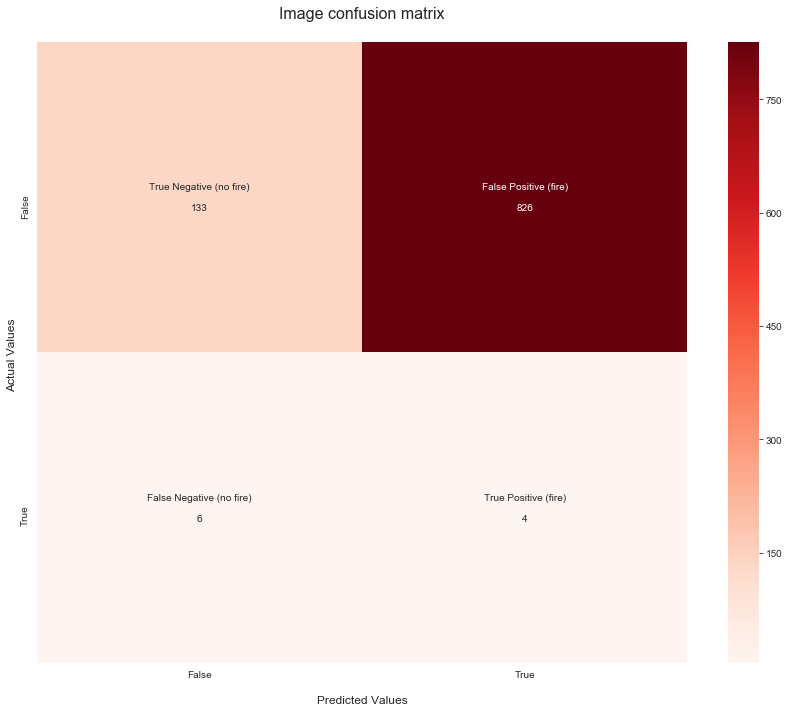

51


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
51,64,0.5,Nadam,0.0257512,0.992248,0,0.984615,1,"[[64, 1], [0, 64]]",3


31/31 [==============================] - 31s 400ms/step


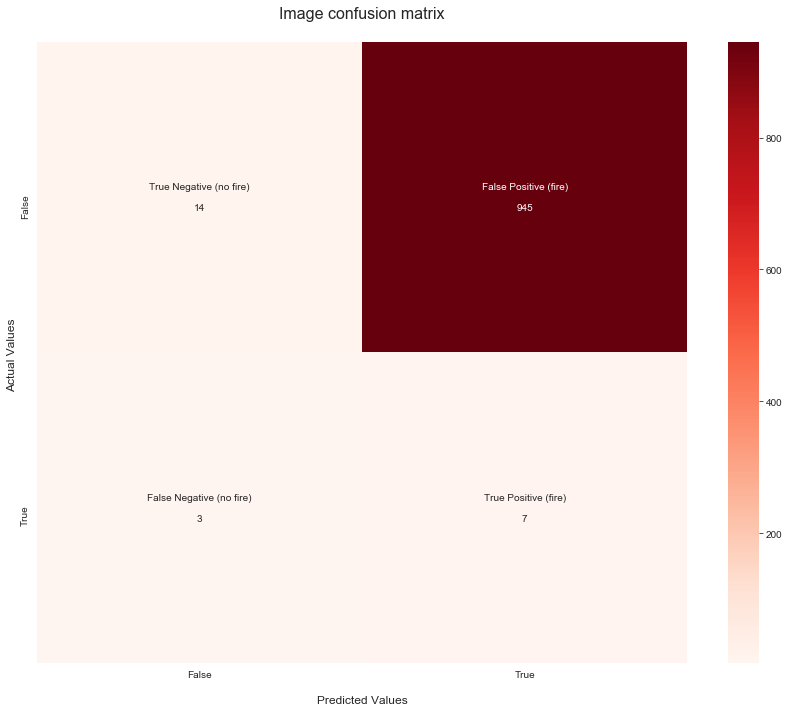

52


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
52,64,0.5,RMSprop,0.0400334,1,0.991226,1,1,"[[65, 0], [0, 64]]",3


31/31 [==============================] - 30s 394ms/step


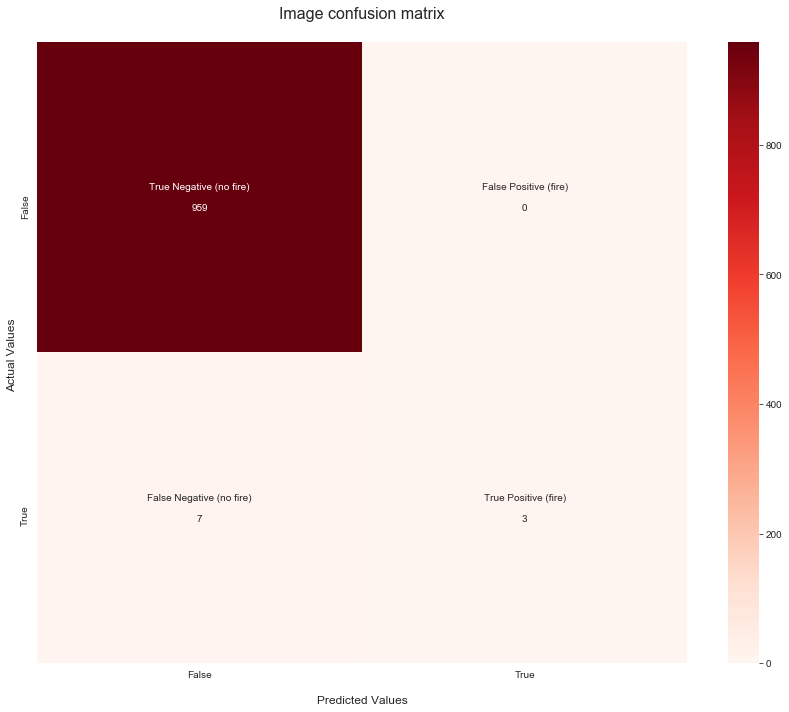

53


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
53,64,0.5,adam,0.045168,0.984496,0,0.969697,1,"[[63, 2], [0, 64]]",3


31/31 [==============================] - 33s 391ms/step


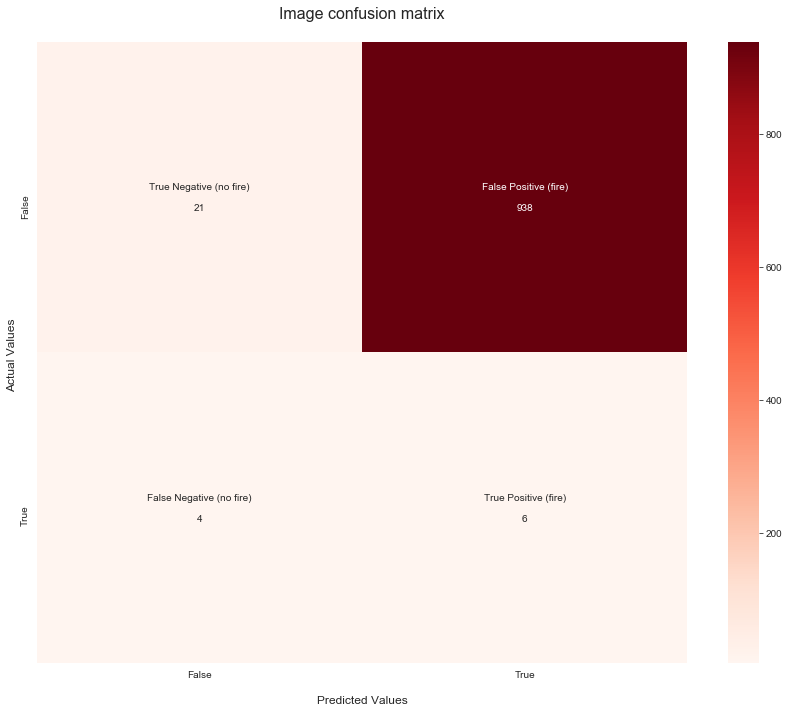

54


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
54,16,0.4,Nadam,0.0445719,0.976744,0.996274,1,0.953125,"[[65, 0], [3, 61]]",5


31/31 [==============================] - 31s 383ms/step


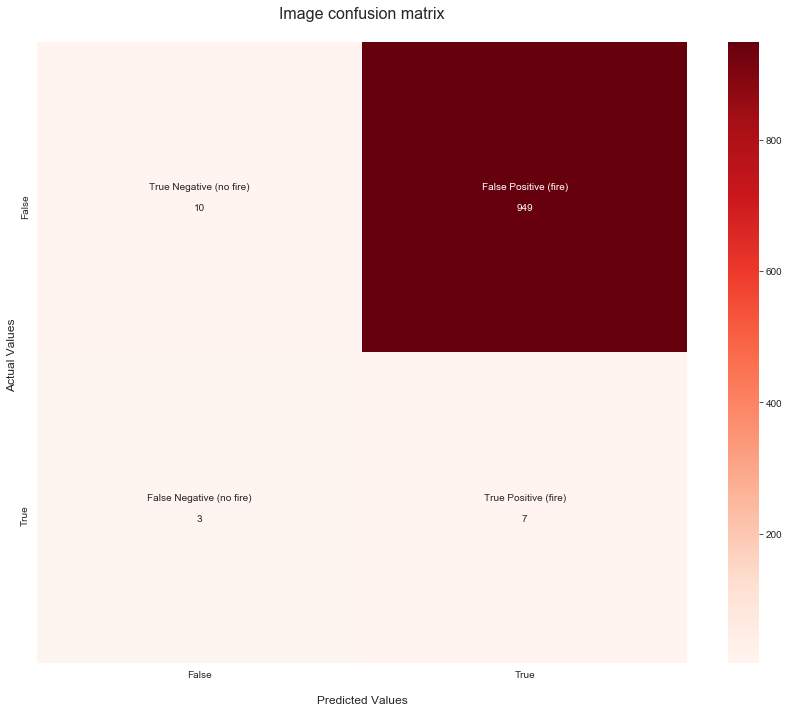

55


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
55,16,0.4,RMSprop,0.0546361,0.976744,0,1,0.953125,"[[65, 0], [3, 61]]",5


31/31 [==============================] - 29s 378ms/step


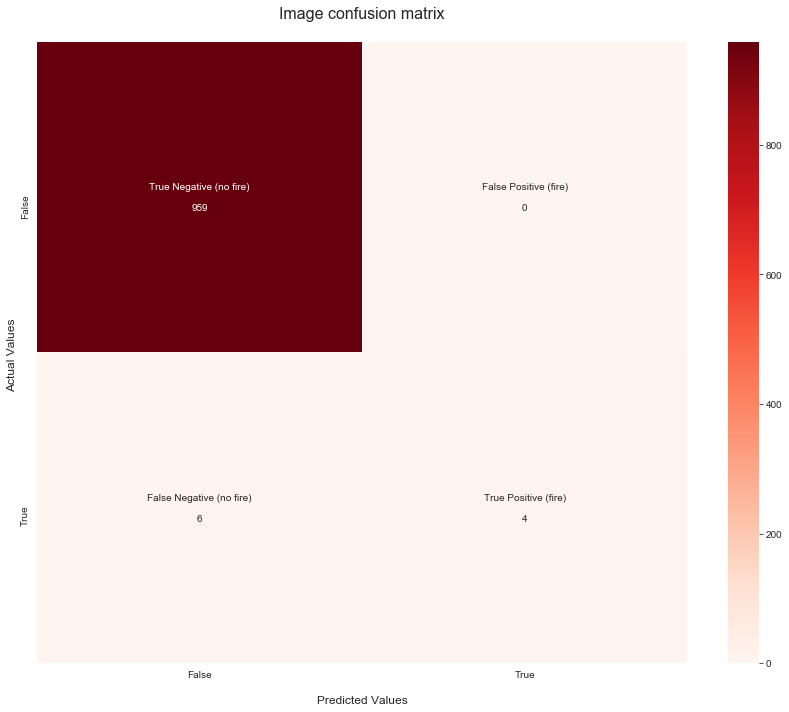

56


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
56,16,0.4,adam,0.116656,0.968992,0.999519,1,0.9375,"[[65, 0], [4, 60]]",5


31/31 [==============================] - 28s 367ms/step


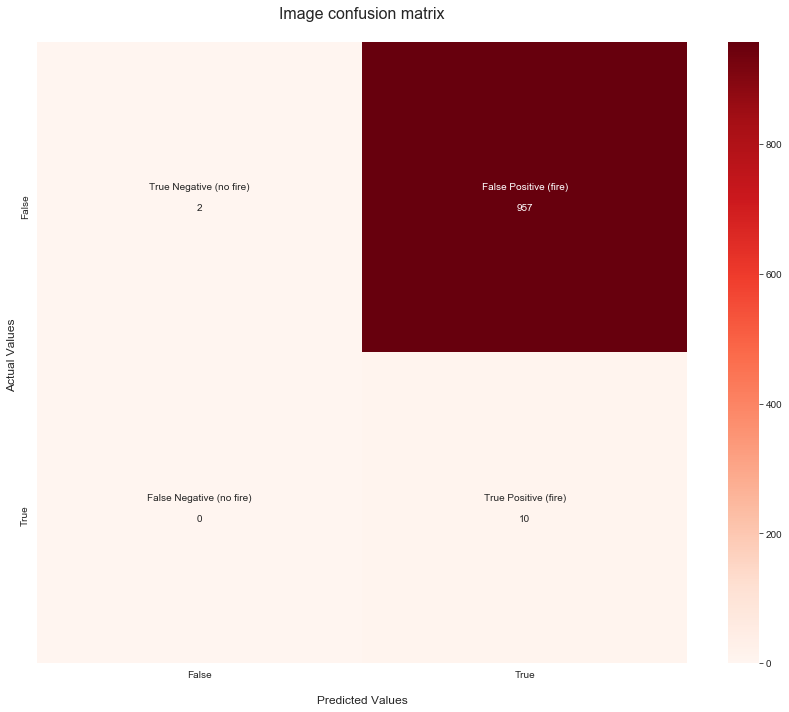

57


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
57,16,0.5,Nadam,0.0409495,0.968992,0,0.96875,0.96875,"[[63, 2], [2, 62]]",5


31/31 [==============================] - 30s 365ms/step


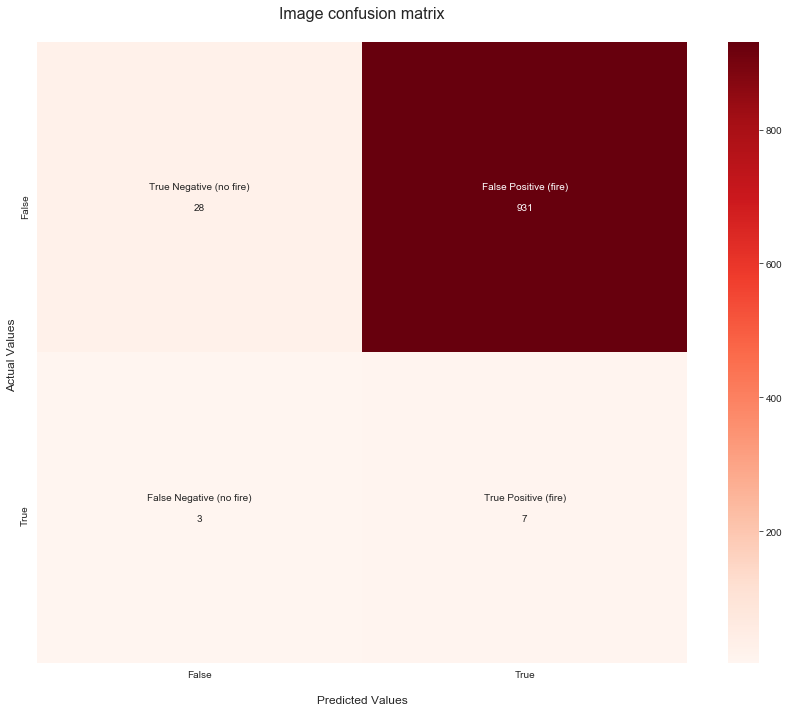

58


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
58,16,0.5,RMSprop,0.13559,0.945736,0.992548,1,0.890625,"[[65, 0], [7, 57]]",5


31/31 [==============================] - 29s 362ms/step


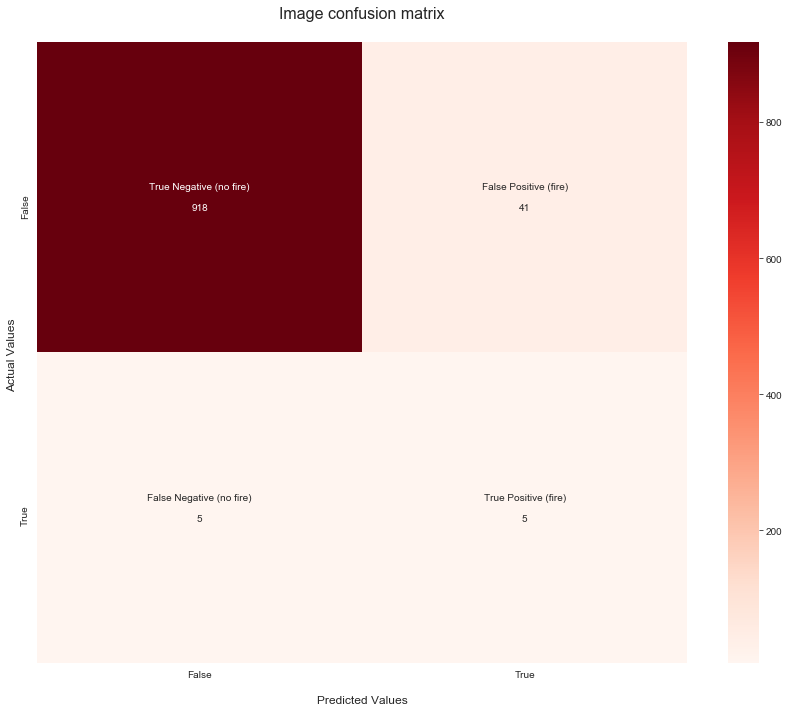

59


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
59,16,0.5,adam,0.163177,0.968992,0,1,0.9375,"[[65, 0], [4, 60]]",5


31/31 [==============================] - 30s 353ms/step


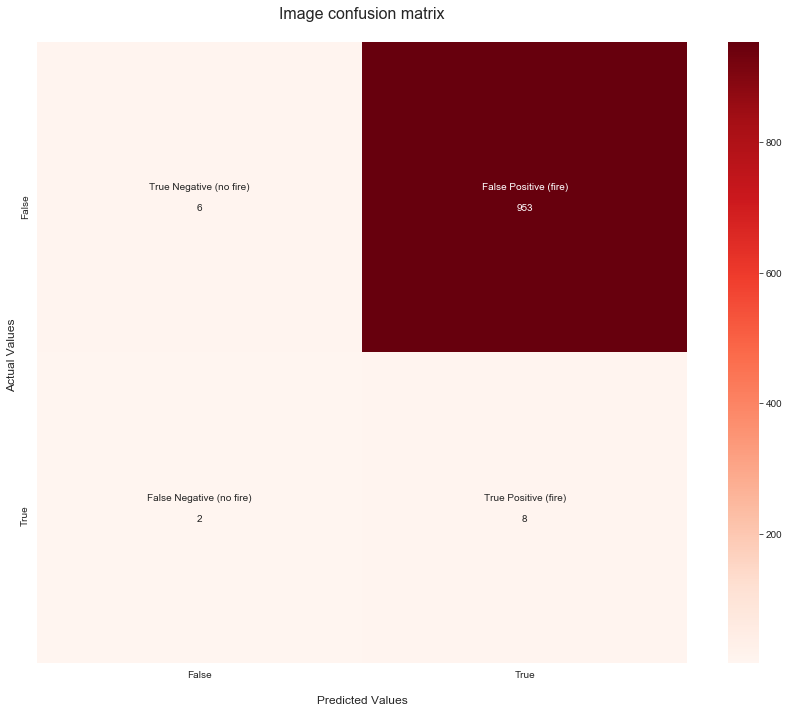

60


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
60,32,0.4,Nadam,0.106482,0.968992,1,1,0.9375,"[[65, 0], [4, 60]]",5


31/31 [==============================] - 29s 343ms/step


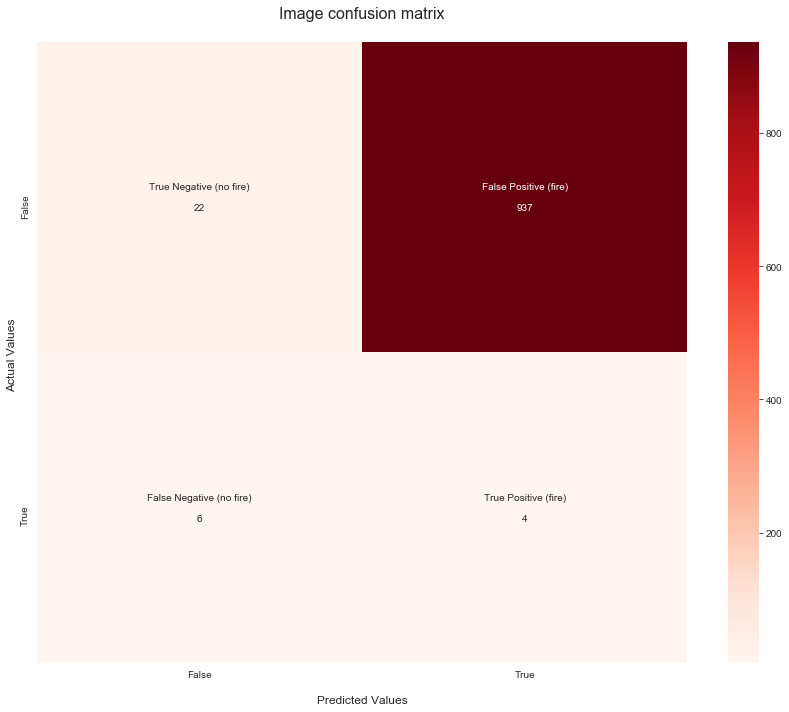

61


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
61,32,0.4,RMSprop,0.0549086,0.968992,0,1,0.9375,"[[65, 0], [4, 60]]",5


31/31 [==============================] - 30s 335ms/step


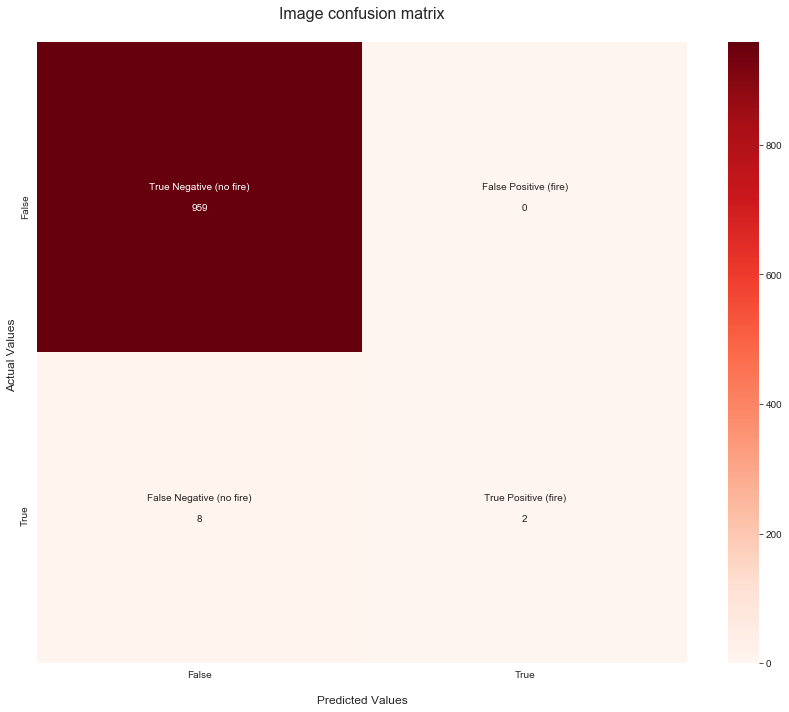

62


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
62,32,0.4,adam,0.0801664,0.976744,0.999038,1,0.953125,"[[65, 0], [3, 61]]",5


31/31 [==============================] - 28s 329ms/step


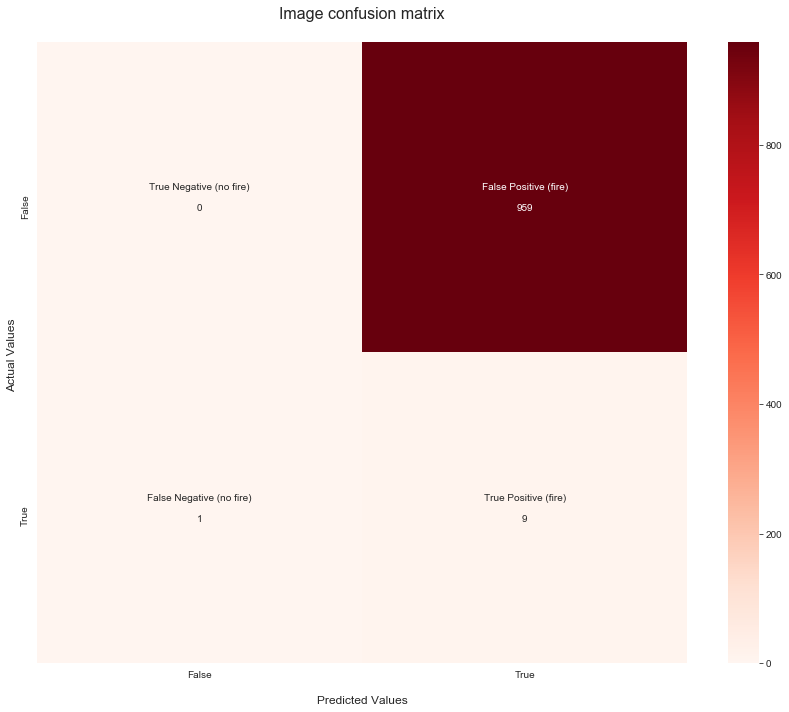

63


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
63,32,0.5,Nadam,0.20813,0.922481,0,0.864865,1,"[[55, 10], [0, 64]]",5


31/31 [==============================] - 29s 324ms/step


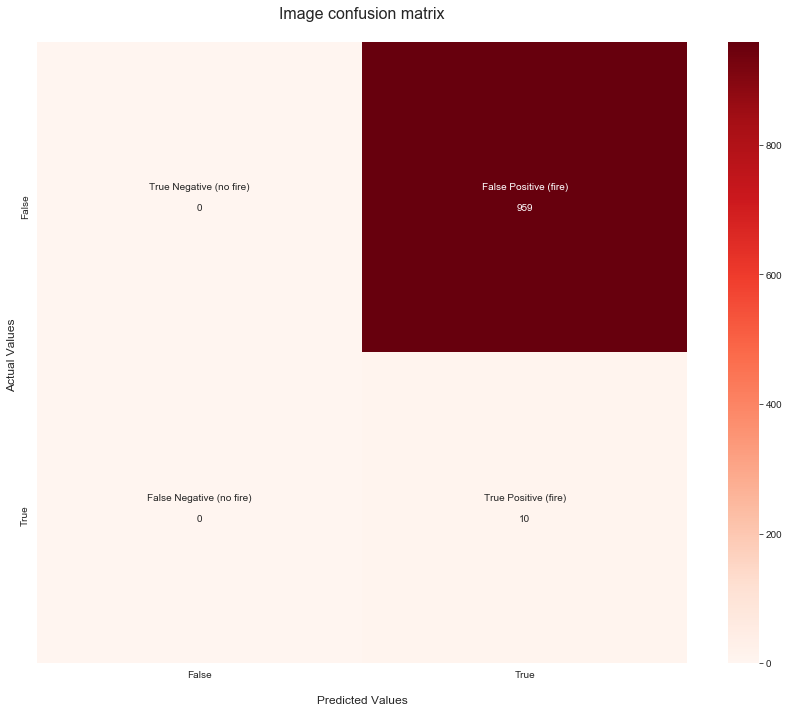

64


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
64,32,0.5,RMSprop,0.0657826,0.968992,0.991947,1,0.9375,"[[65, 0], [4, 60]]",5


31/31 [==============================] - 28s 320ms/step


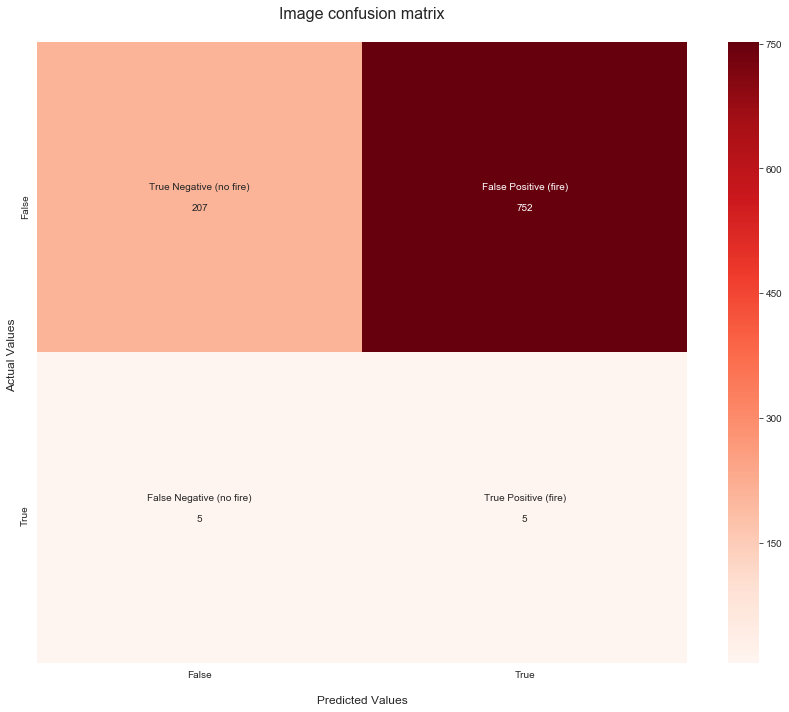

65


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
65,32,0.5,adam,0.0238021,0.992248,0,1,0.984375,"[[65, 0], [1, 63]]",5


31/31 [==============================] - 32s 320ms/step


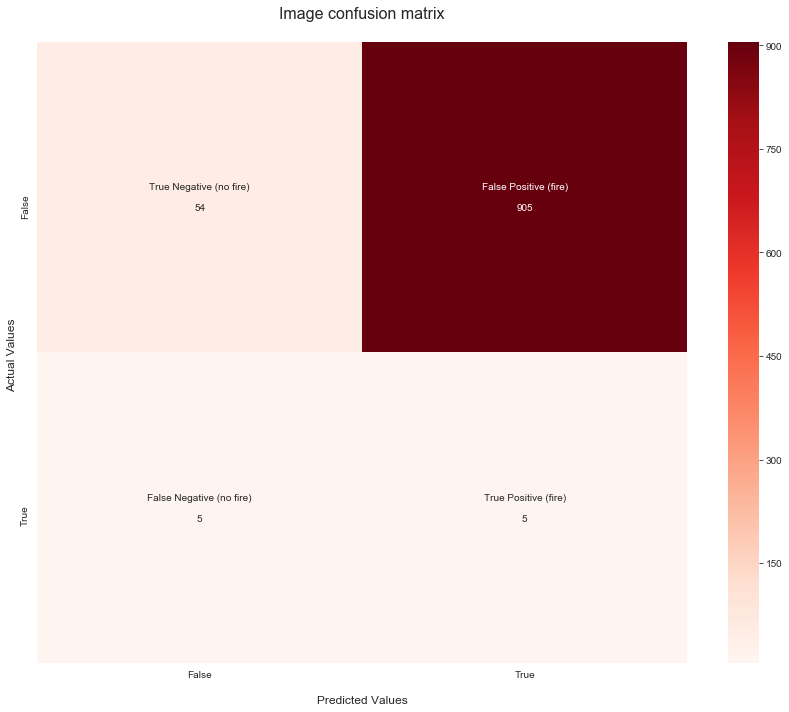

66


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
66,64,0.4,Nadam,0.0572528,0.984496,0.999038,1,0.96875,"[[65, 0], [2, 62]]",5


31/31 [==============================] - 27s 327ms/step


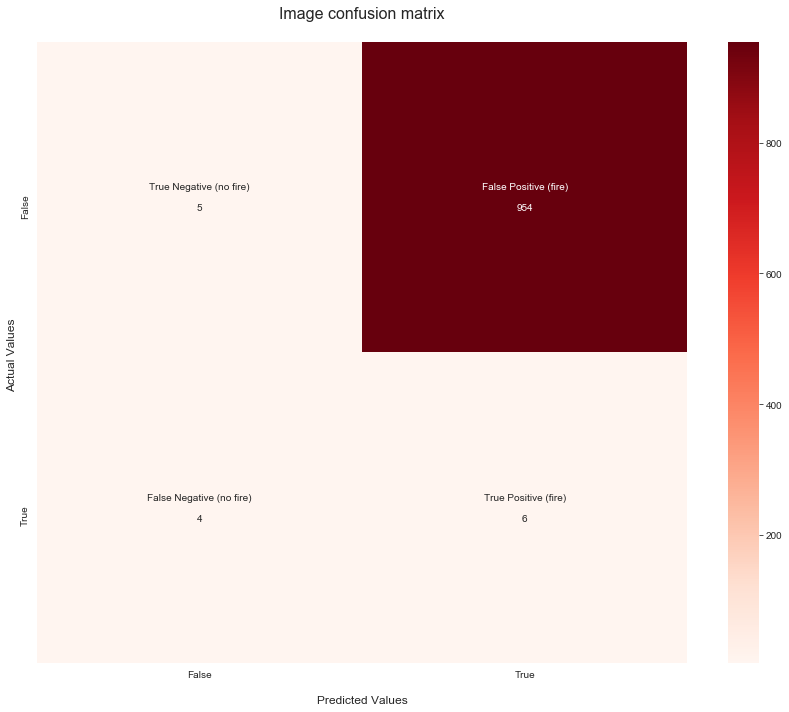

67


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
67,64,0.4,RMSprop,0.108939,0.968992,0,1,0.9375,"[[65, 0], [4, 60]]",5


31/31 [==============================] - 29s 328ms/step


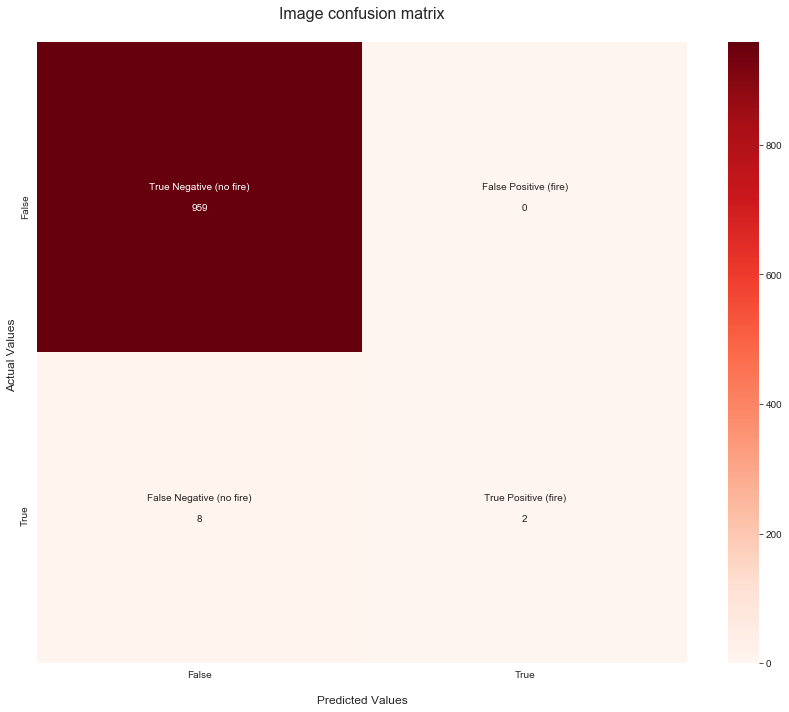

68


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
68,64,0.4,adam,0.0361539,0.984496,0.995312,1,0.96875,"[[65, 0], [2, 62]]",5


31/31 [==============================] - 30s 328ms/step


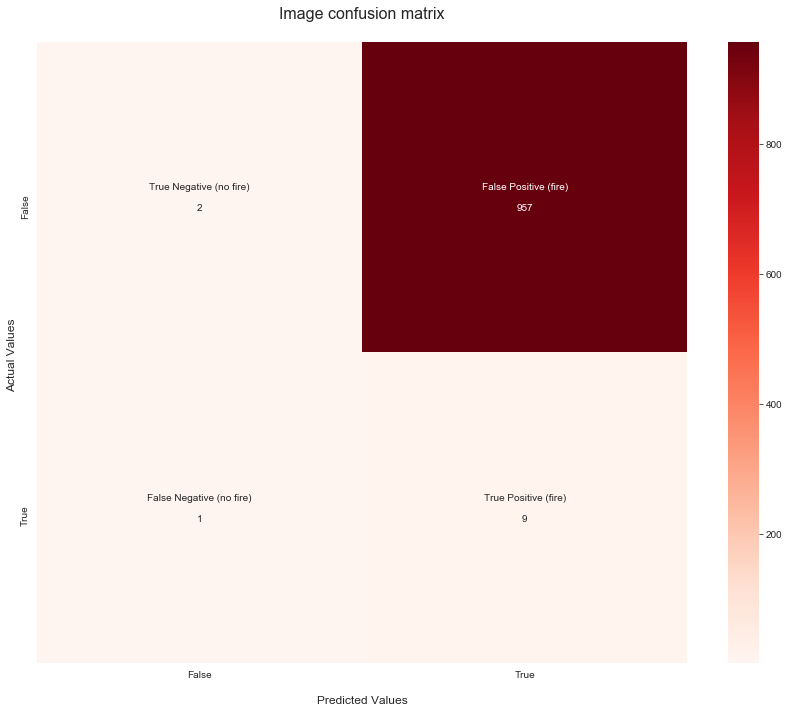

69


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
69,64,0.5,Nadam,0.0396599,0.984496,0,1,0.96875,"[[65, 0], [2, 62]]",5


31/31 [==============================] - 32s 328ms/step


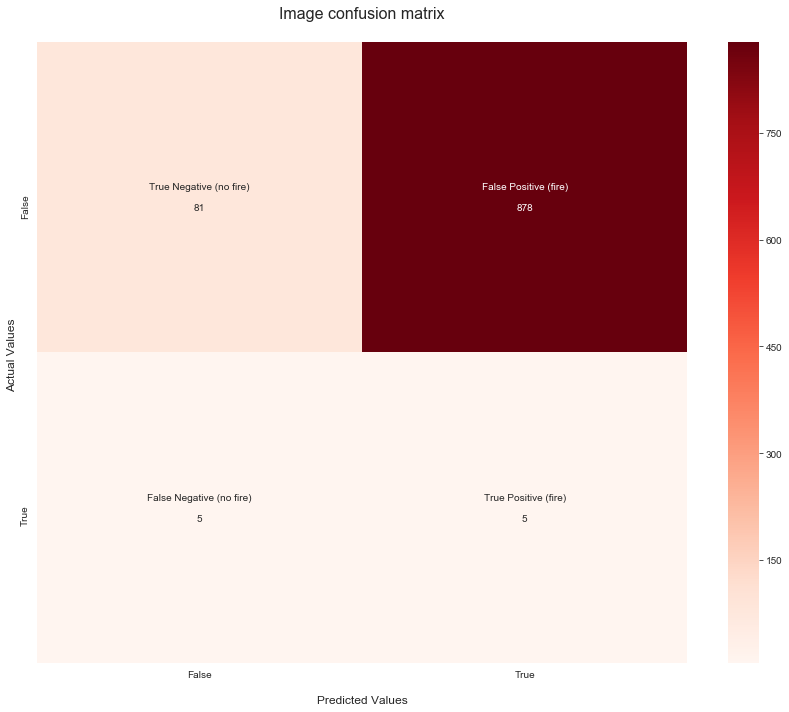

70


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
70,64,0.5,RMSprop,0.0812282,0.976744,0.970312,1,0.953125,"[[65, 0], [3, 61]]",5


31/31 [==============================] - 30s 326ms/step


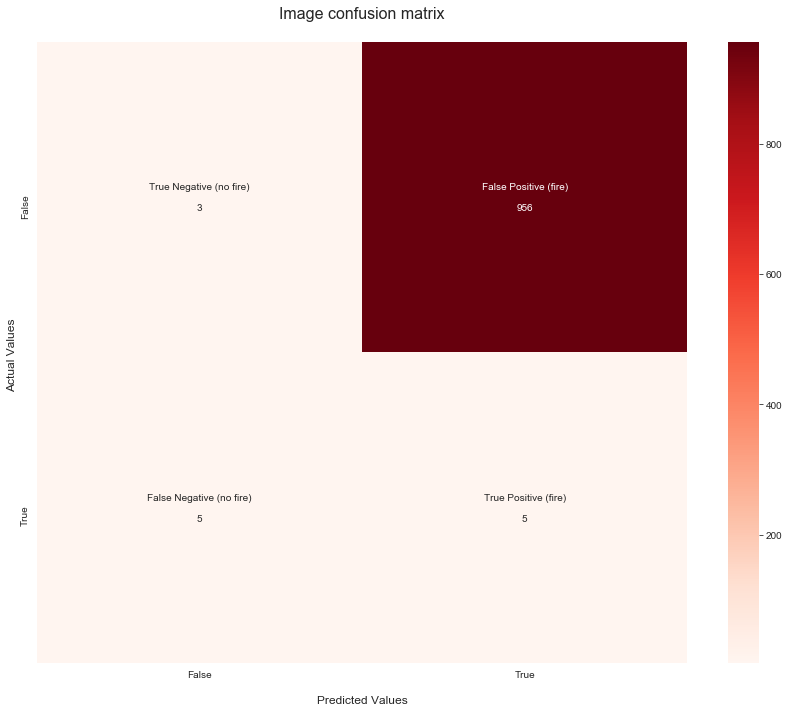

71


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
71,64,0.5,adam,0.0278671,0.984496,0,0.969697,1,"[[63, 2], [0, 64]]",5


31/31 [==============================] - 28s 328ms/step


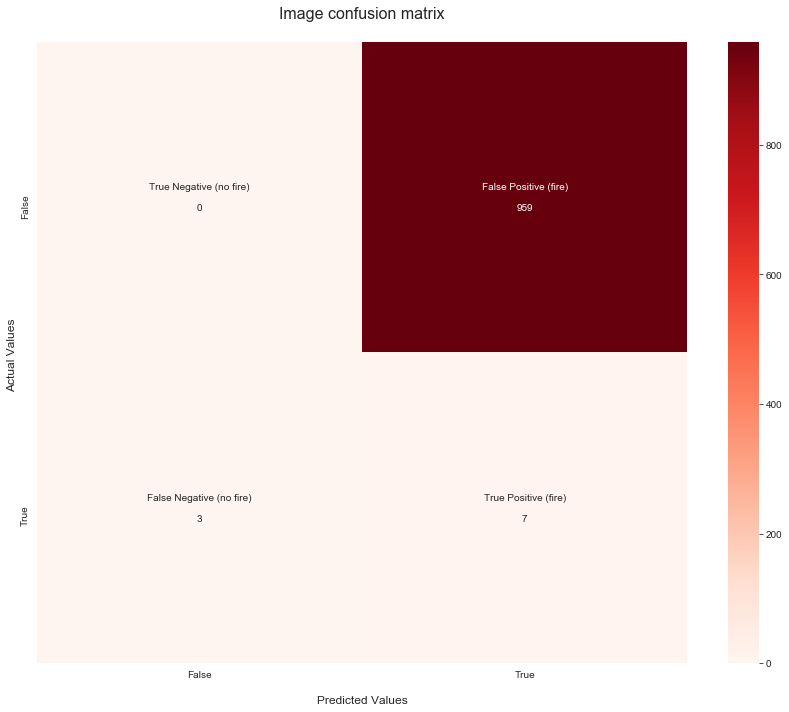

72


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
72,16,0.4,Nadam,0.0343194,1,0.998317,1,1,"[[65, 0], [0, 64]]",7


31/31 [==============================] - 27s 321ms/step


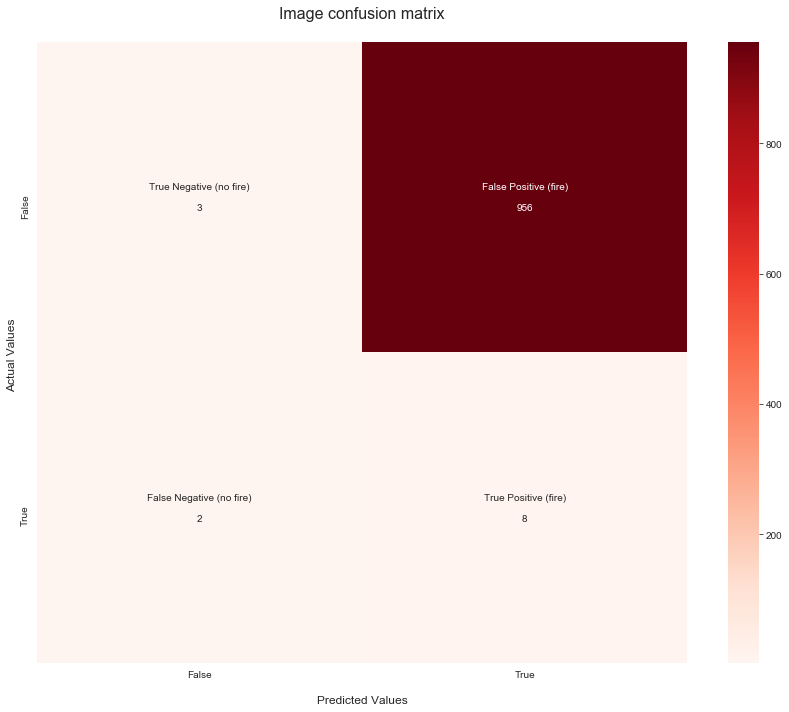

73


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
73,16,0.4,RMSprop,0.0151457,1,0,1,1,"[[65, 0], [0, 64]]",7


31/31 [==============================] - 28s 321ms/step


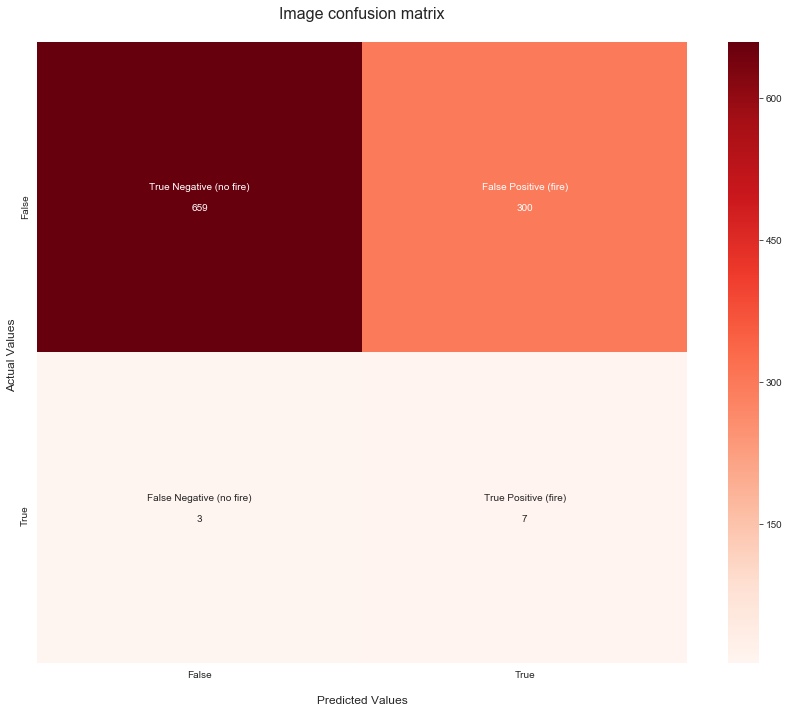

74


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
74,16,0.4,adam,0.0546077,0.984496,0.999159,1,0.96875,"[[65, 0], [2, 62]]",7


31/31 [==============================] - 30s 321ms/step


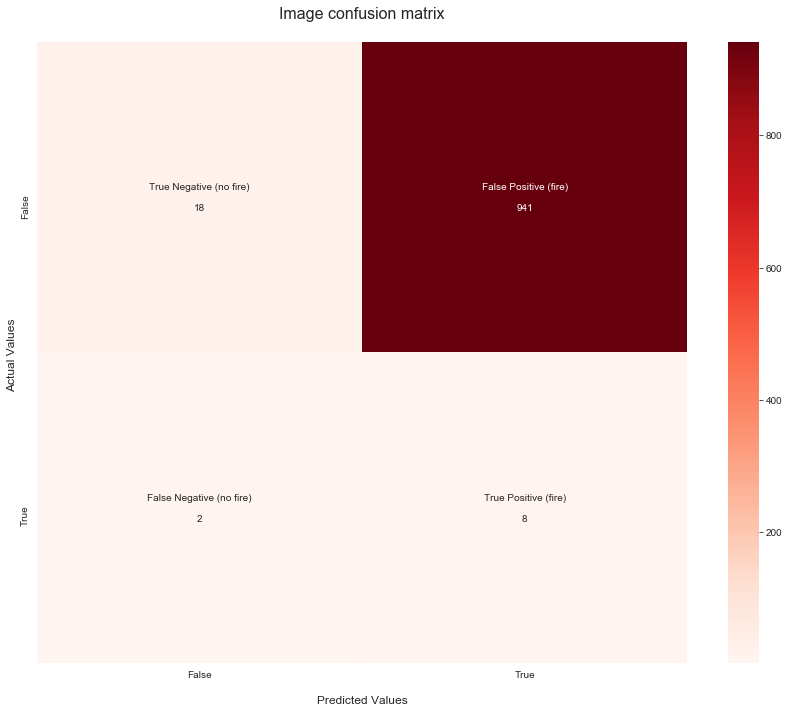

75


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
75,16,0.5,Nadam,0.0955235,0.953488,0,0.953125,0.953125,"[[62, 3], [3, 61]]",7


31/31 [==============================] - 26s 320ms/step


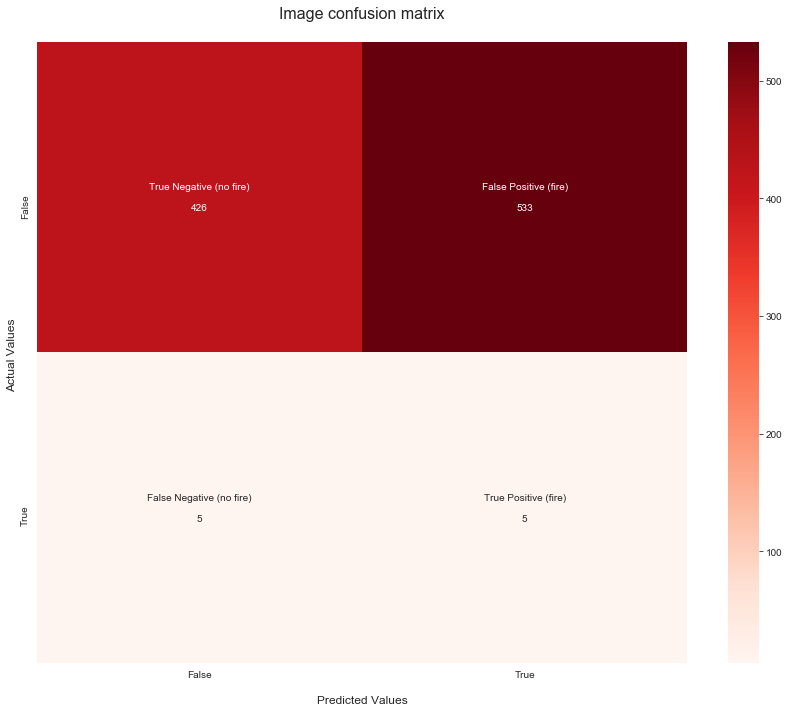

76


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
76,16,0.5,RMSprop,0.115531,0.968992,1,1,0.9375,"[[65, 0], [4, 60]]",7


31/31 [==============================] - 30s 356ms/step


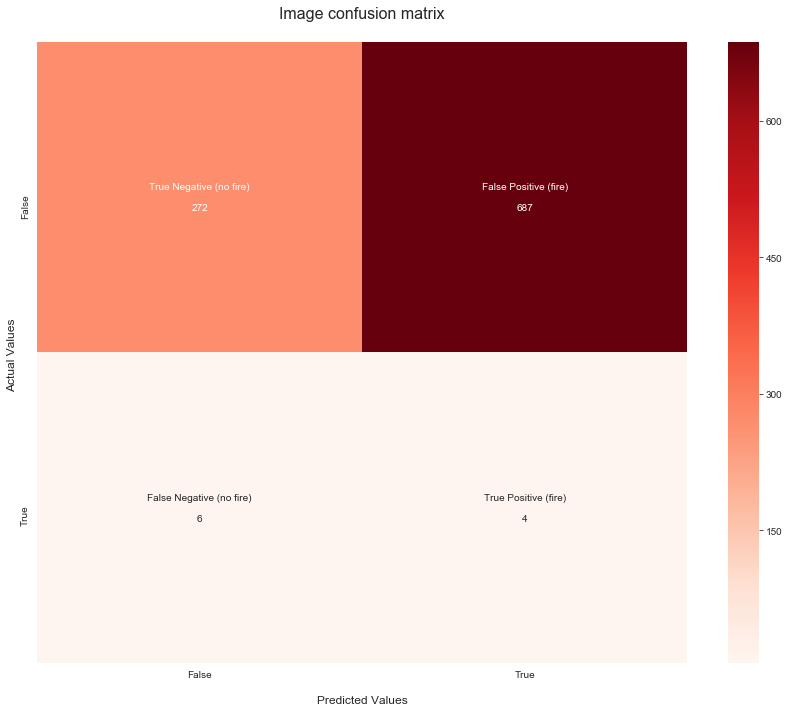

77


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
77,16,0.5,adam,0.120076,0.968992,0,1,0.9375,"[[65, 0], [4, 60]]",7


31/31 [==============================] - 32s 363ms/step


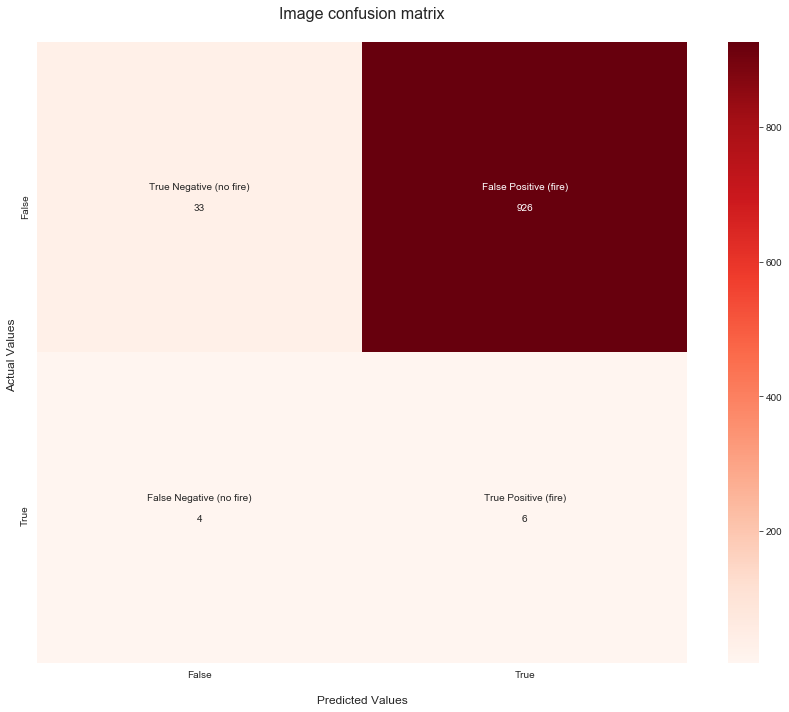

78


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
78,32,0.4,Nadam,0.0213266,0.992248,0.990144,1,0.984375,"[[65, 0], [1, 63]]",7


31/31 [==============================] - 30s 350ms/step


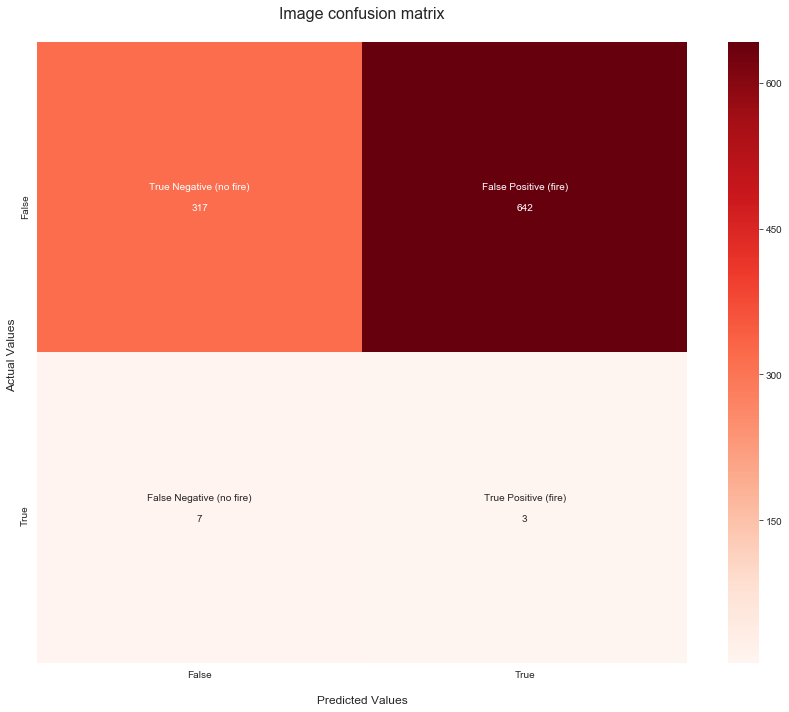

79


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
79,32,0.4,RMSprop,0.0307726,0.984496,0,1,0.96875,"[[65, 0], [2, 62]]",7


31/31 [==============================] - 29s 324ms/step


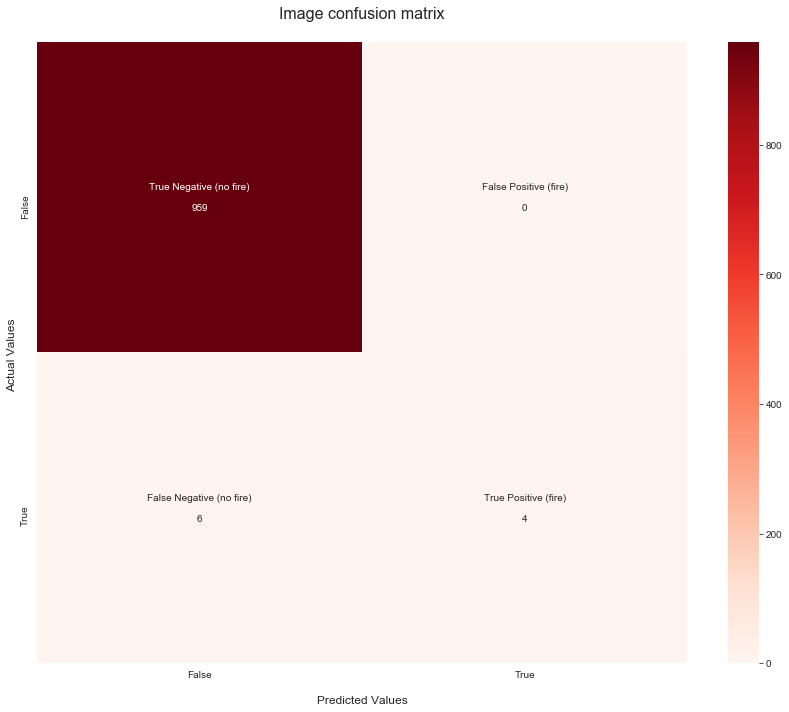

80


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
80,32,0.4,adam,0.0320146,0.984496,0.988461,0.984375,0.984375,"[[64, 1], [1, 63]]",7


31/31 [==============================] - 26s 323ms/step


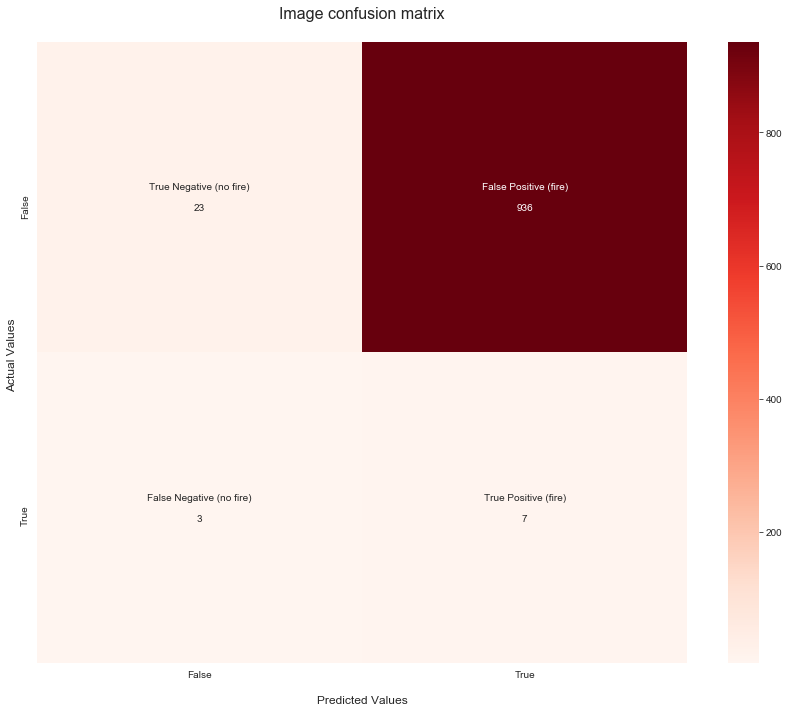

81


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
81,32,0.5,Nadam,0.02551,1,0,1,1,"[[65, 0], [0, 64]]",7


31/31 [==============================] - 28s 322ms/step


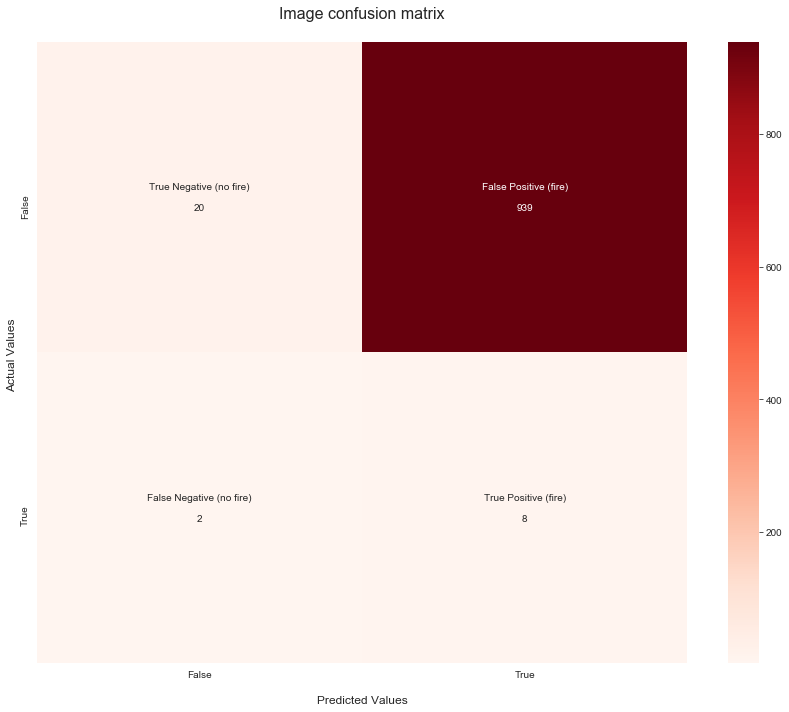

82


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
82,32,0.5,RMSprop,0.0350048,0.984496,0.973918,1,0.96875,"[[65, 0], [2, 62]]",7


31/31 [==============================] - 29s 322ms/step


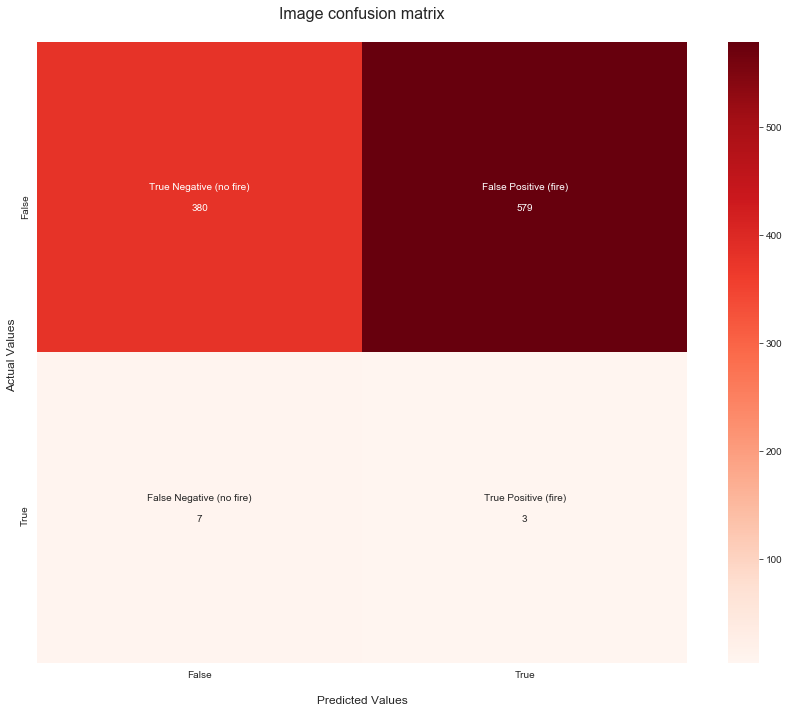

83


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
83,32,0.5,adam,0.107514,0.968992,0,1,0.9375,"[[65, 0], [4, 60]]",7


31/31 [==============================] - 27s 321ms/step


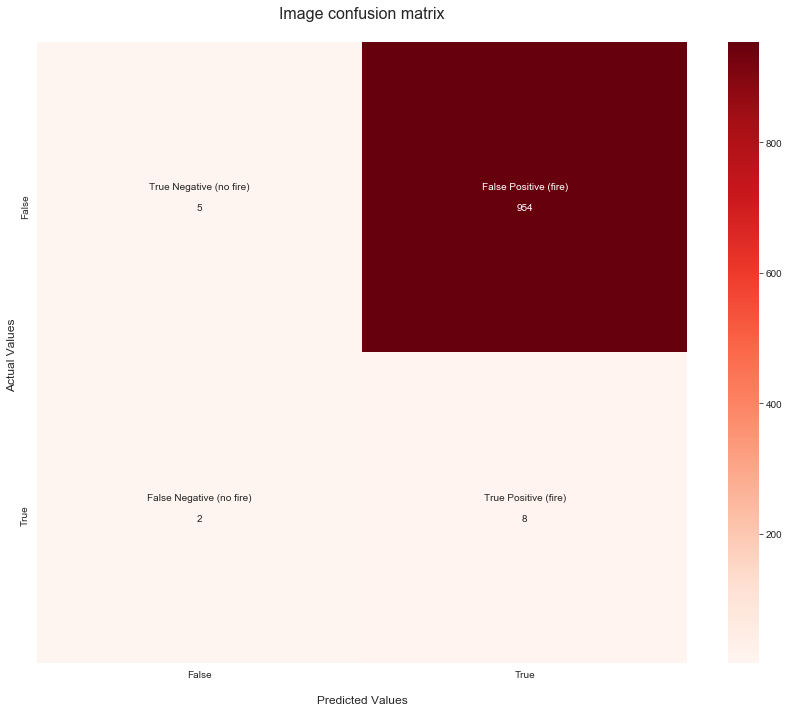

84


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
84,64,0.4,Nadam,0.0554821,0.976744,0.994231,1,0.953125,"[[65, 0], [3, 61]]",7


31/31 [==============================] - 28s 324ms/step


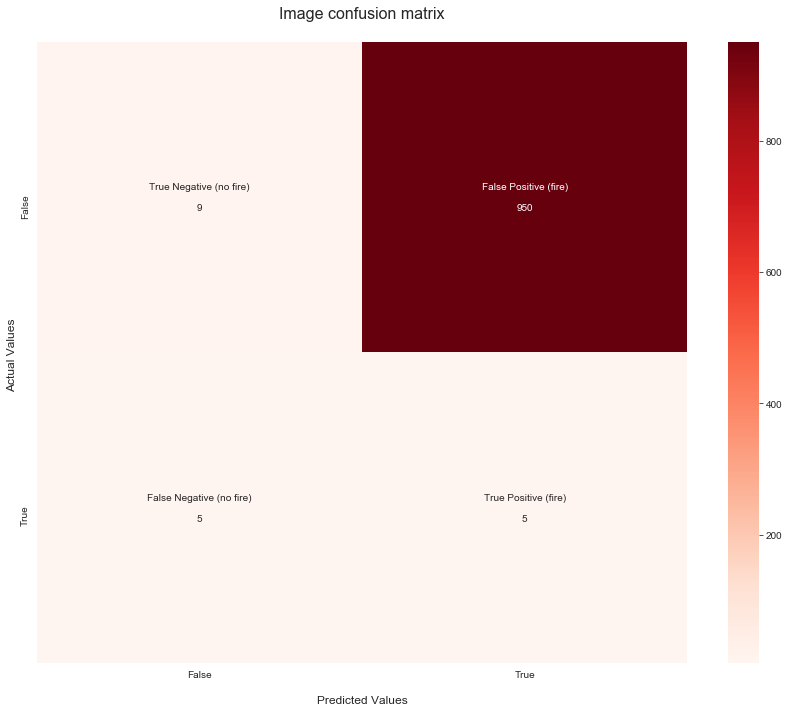

85


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
85,64,0.4,RMSprop,0.0761692,0.96124,0,1,0.921875,"[[65, 0], [5, 59]]",7


31/31 [==============================] - 29s 328ms/step


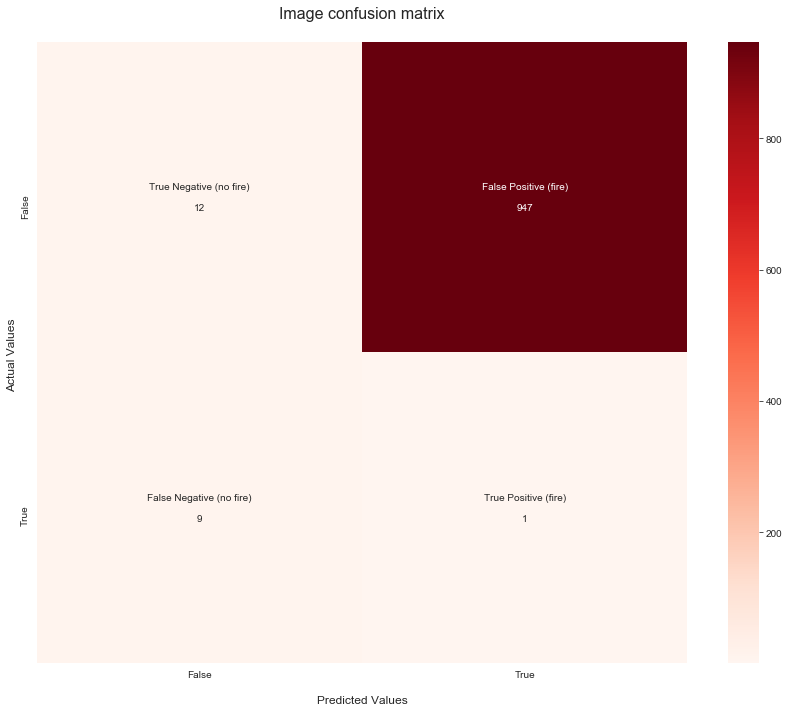

86


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
86,64,0.4,adam,0.0505684,0.976744,0.990986,1,0.953125,"[[65, 0], [3, 61]]",7


31/31 [==============================] - 30s 326ms/step


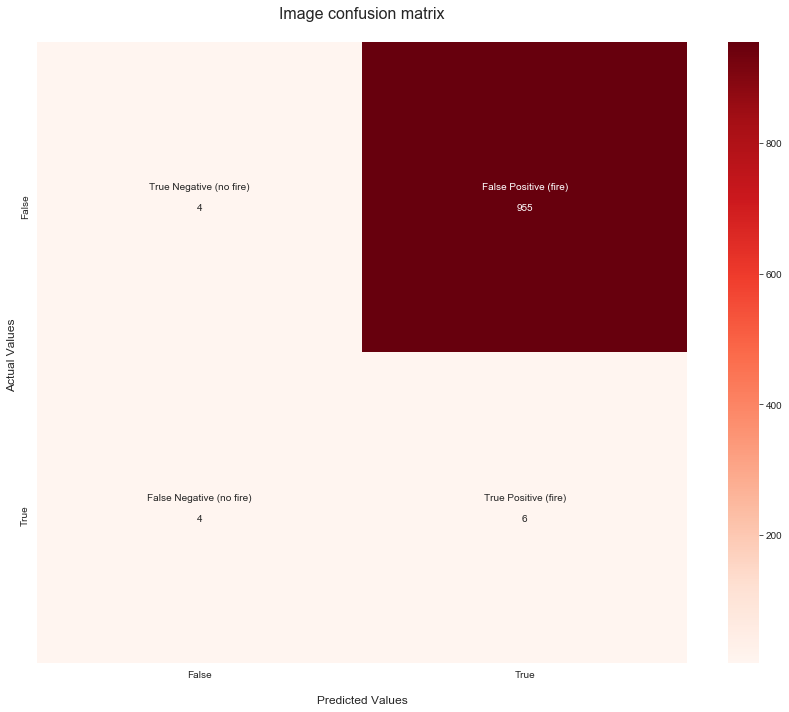

87


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
87,64,0.5,Nadam,0.0580713,0.984496,0,1,0.96875,"[[65, 0], [2, 62]]",7


31/31 [==============================] - 29s 327ms/step


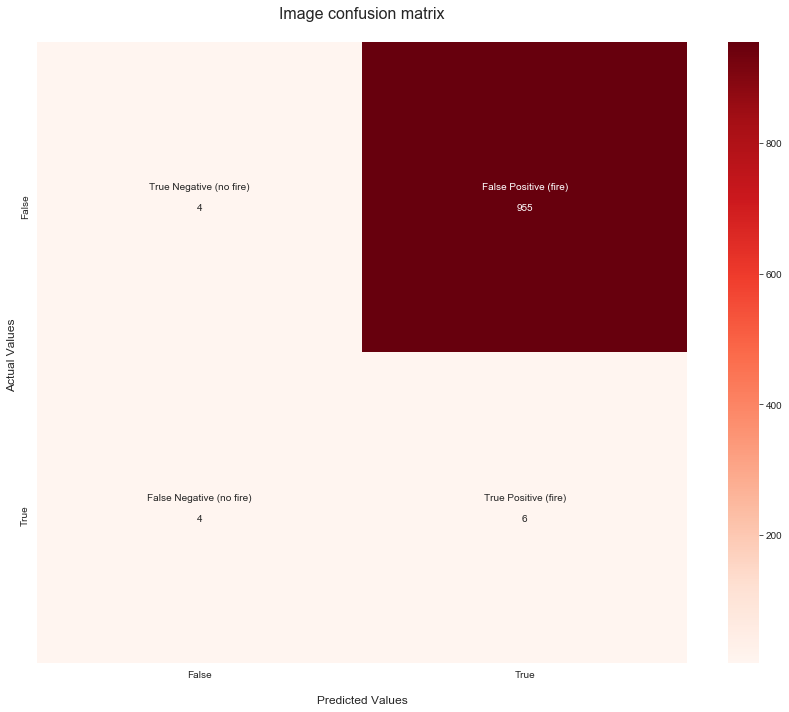

88


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
88,64,0.5,RMSprop,0.0586831,0.976744,1,0.955224,1,"[[62, 3], [0, 64]]",7


31/31 [==============================] - 28s 327ms/step


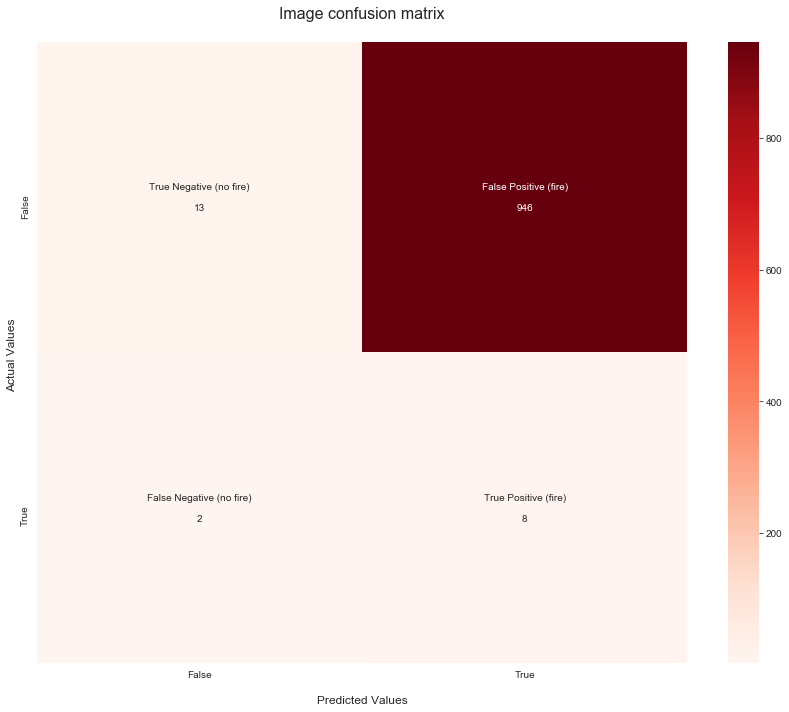

89


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
89,64,0.5,adam,0.0447916,0.984496,0,1,0.96875,"[[65, 0], [2, 62]]",7


31/31 [==============================] - 31s 328ms/step


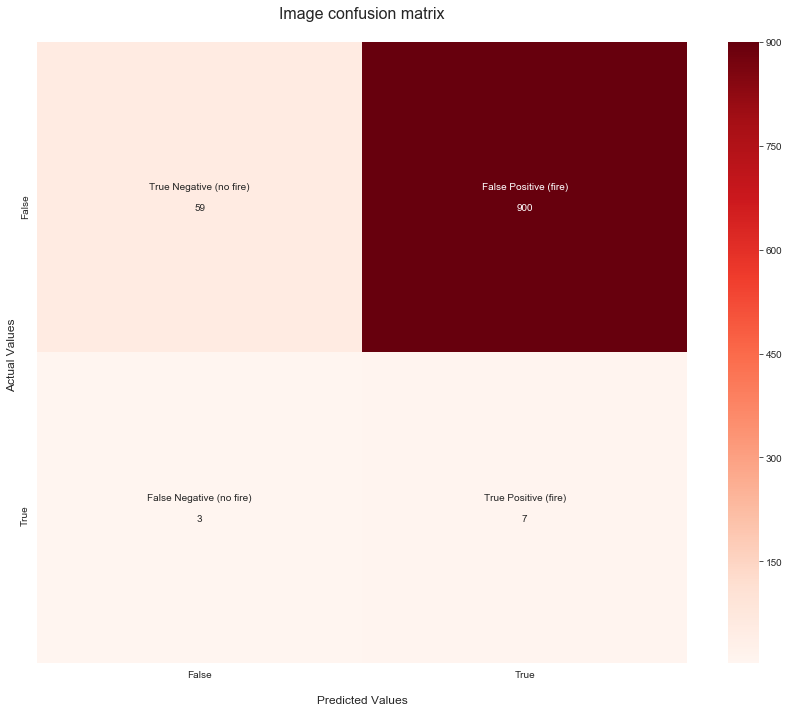

90


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
90,16,0.4,Nadam,0.0156556,0.992248,0.995433,1,0.984375,"[[65, 0], [1, 63]]",9


31/31 [==============================] - 26s 321ms/step


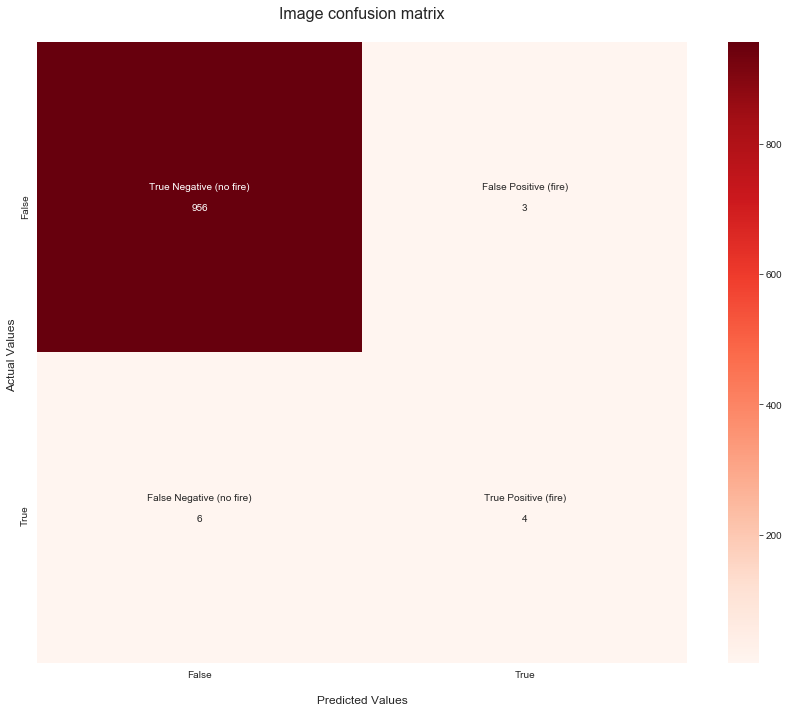

91


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
91,16,0.4,RMSprop,0.0377147,0.984496,0,1,0.96875,"[[65, 0], [2, 62]]",9


31/31 [==============================] - 30s 327ms/step


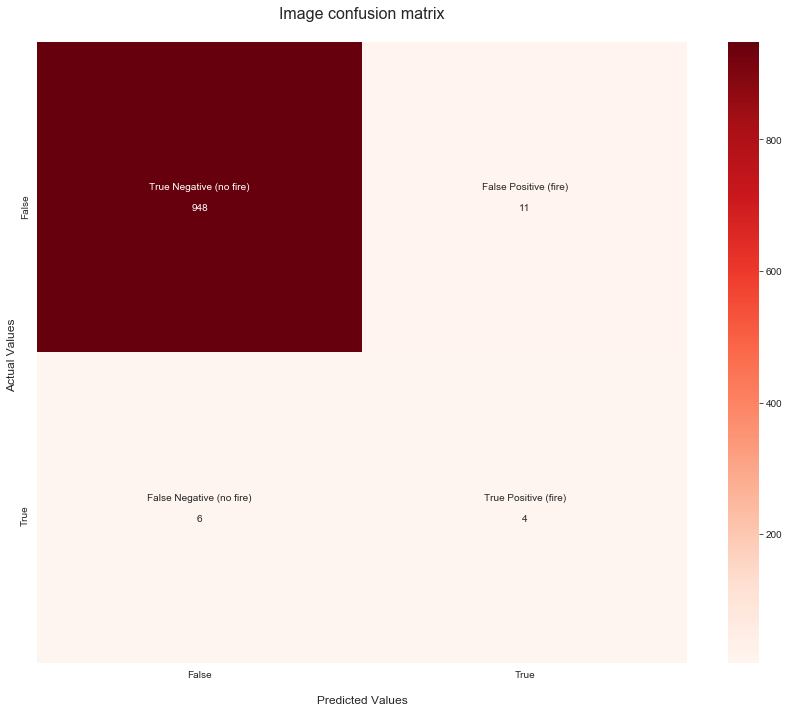

92


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
92,16,0.4,adam,0.0342105,0.984496,0.999279,1,0.96875,"[[65, 0], [2, 62]]",9


31/31 [==============================] - 27s 320ms/step


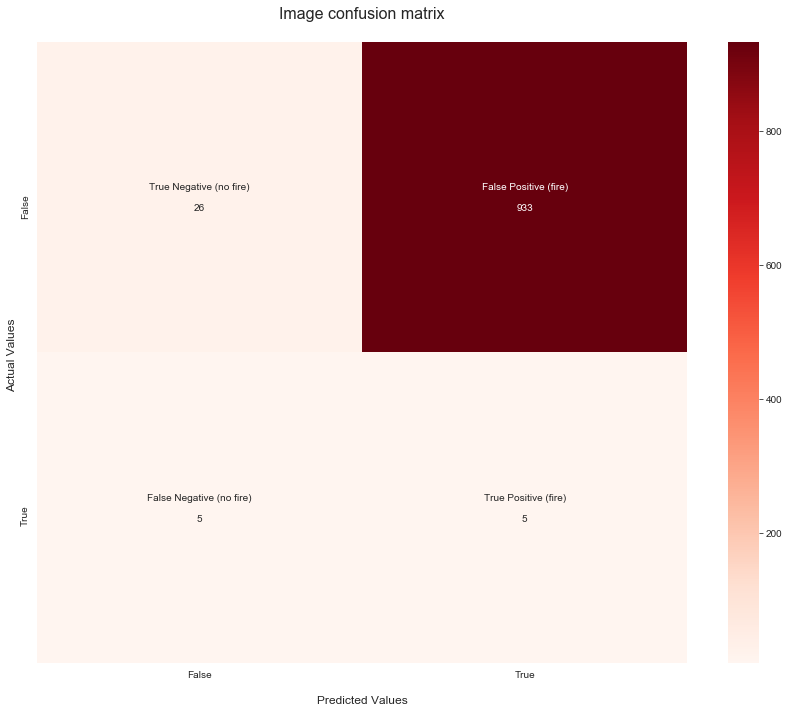

93


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
93,16,0.5,Nadam,0.0748262,0.976744,0,1,0.953125,"[[65, 0], [3, 61]]",9


31/31 [==============================] - 27s 320ms/step


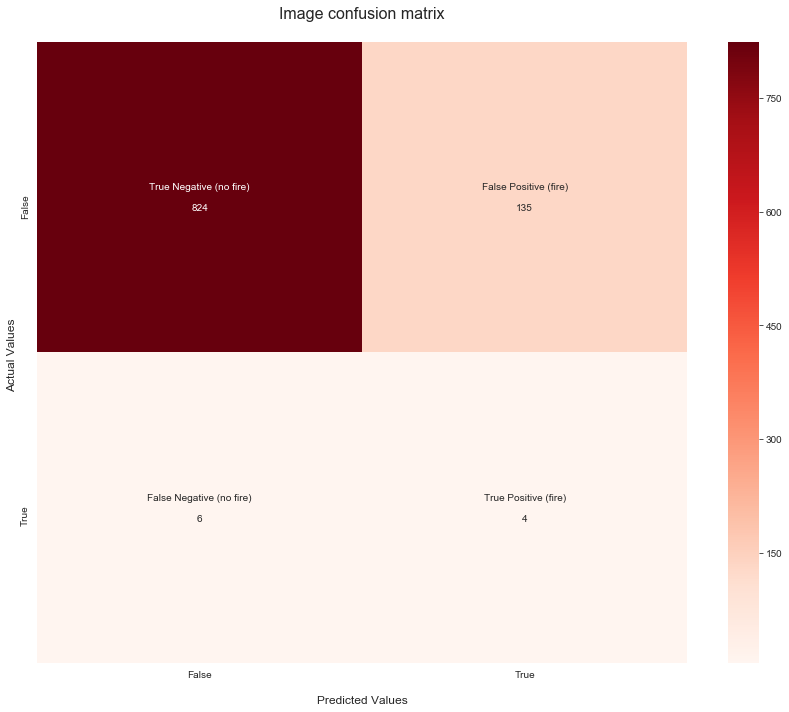

94


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
94,16,0.5,RMSprop,0.118082,0.968992,0.999279,1,0.9375,"[[65, 0], [4, 60]]",9


31/31 [==============================] - 28s 322ms/step


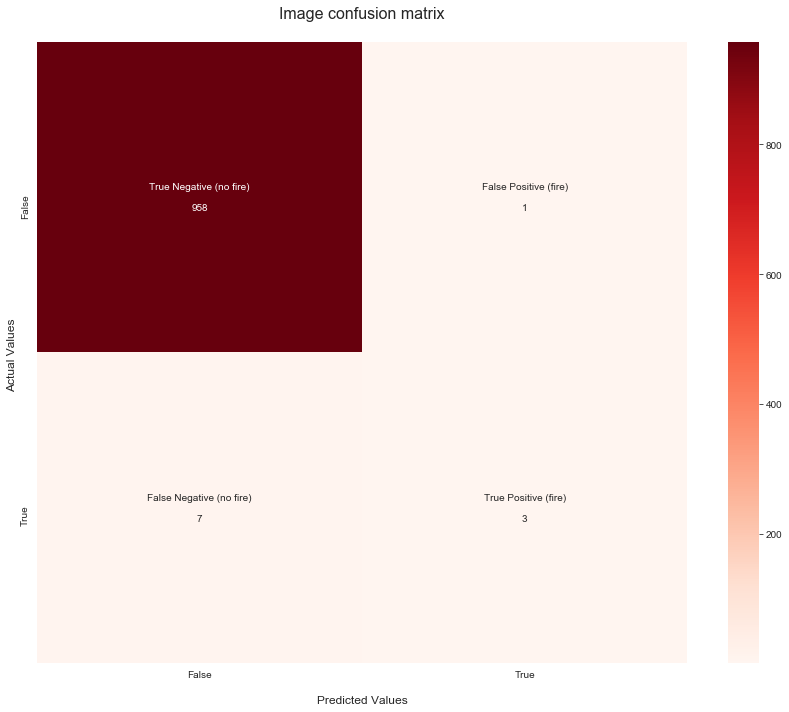

95


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
95,16,0.5,adam,0.0342762,0.984496,0,1,0.96875,"[[65, 0], [2, 62]]",9


31/31 [==============================] - 30s 329ms/step


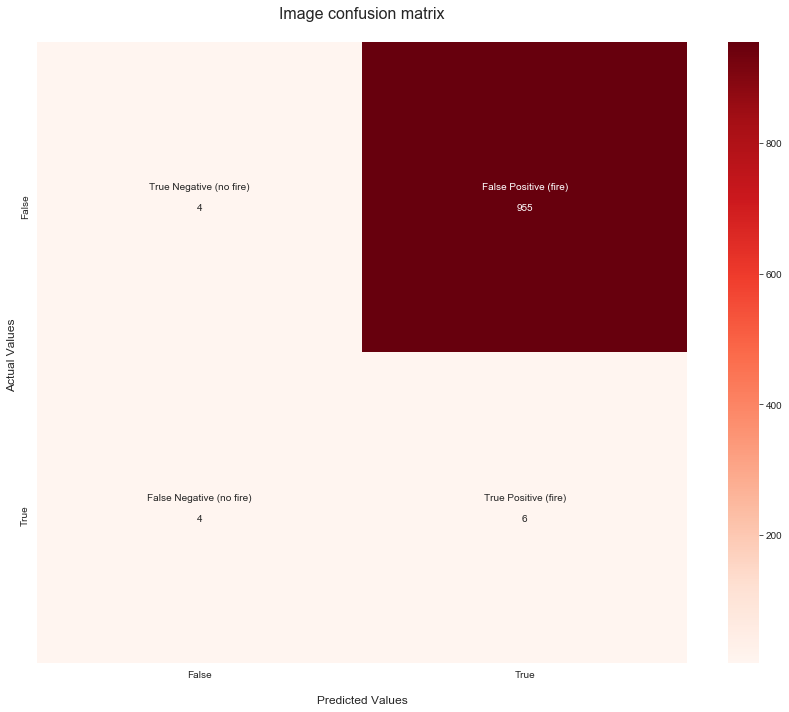

96


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
96,32,0.4,Nadam,0.0141414,0.992248,0.998438,1,0.984375,"[[65, 0], [1, 63]]",9


31/31 [==============================] - 27s 327ms/step


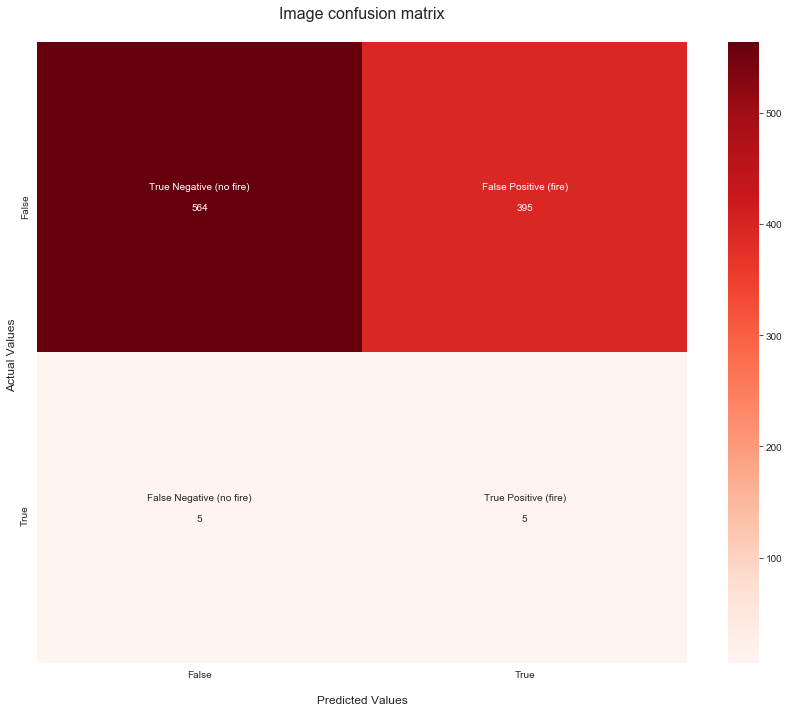

97


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
97,32,0.4,RMSprop,0.0457508,0.976744,0,1,0.953125,"[[65, 0], [3, 61]]",9


31/31 [==============================] - 30s 330ms/step


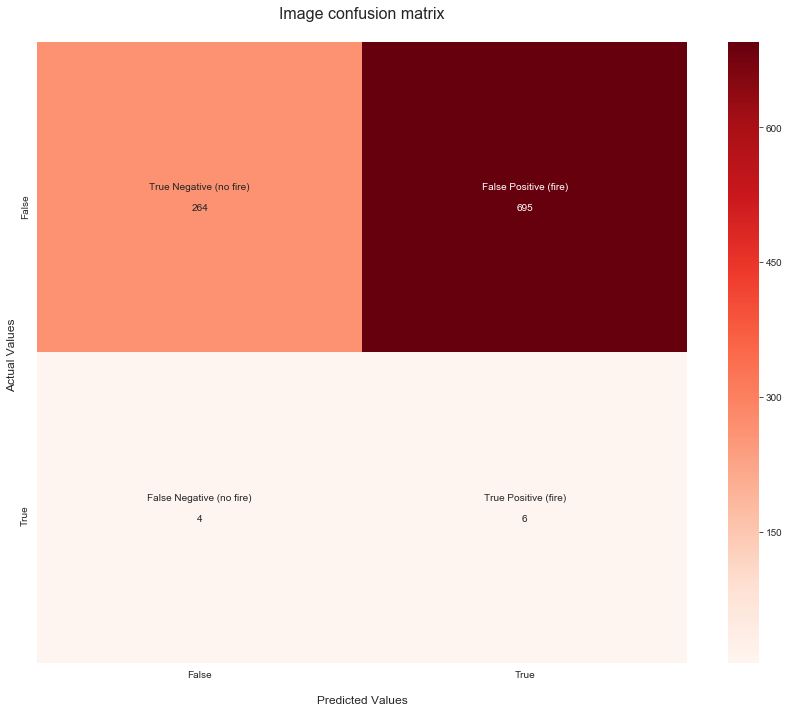

98


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
98,32,0.4,adam,0.0482195,0.984496,0.99988,1,0.96875,"[[65, 0], [2, 62]]",9


31/31 [==============================] - 26s 329ms/step


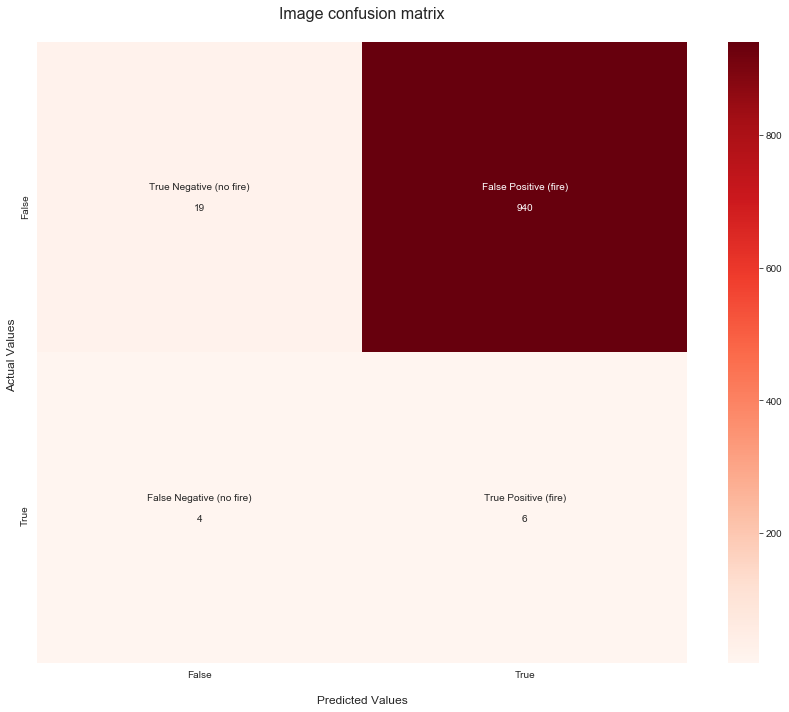

99


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
99,32,0.5,Nadam,0.0400222,0.992248,0,1,0.984375,"[[65, 0], [1, 63]]",9


31/31 [==============================] - 28s 334ms/step


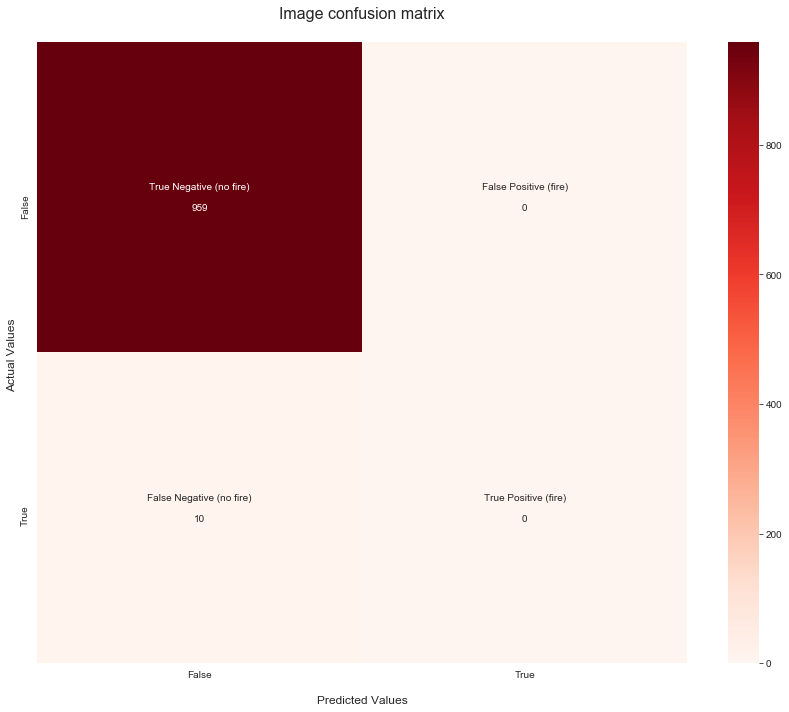

100


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
100,32,0.5,RMSprop,0.21871,0.96124,0.99976,1,0.921875,"[[65, 0], [5, 59]]",9


31/31 [==============================] - 27s 337ms/step


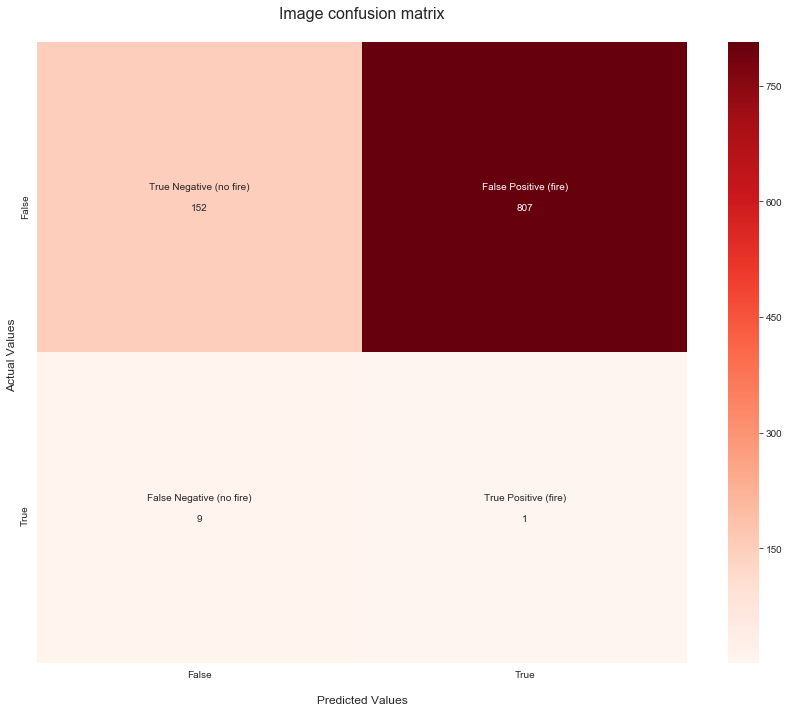

101


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
101,32,0.5,adam,0.0549764,0.976744,0,1,0.953125,"[[65, 0], [3, 61]]",9


31/31 [==============================] - 28s 332ms/step


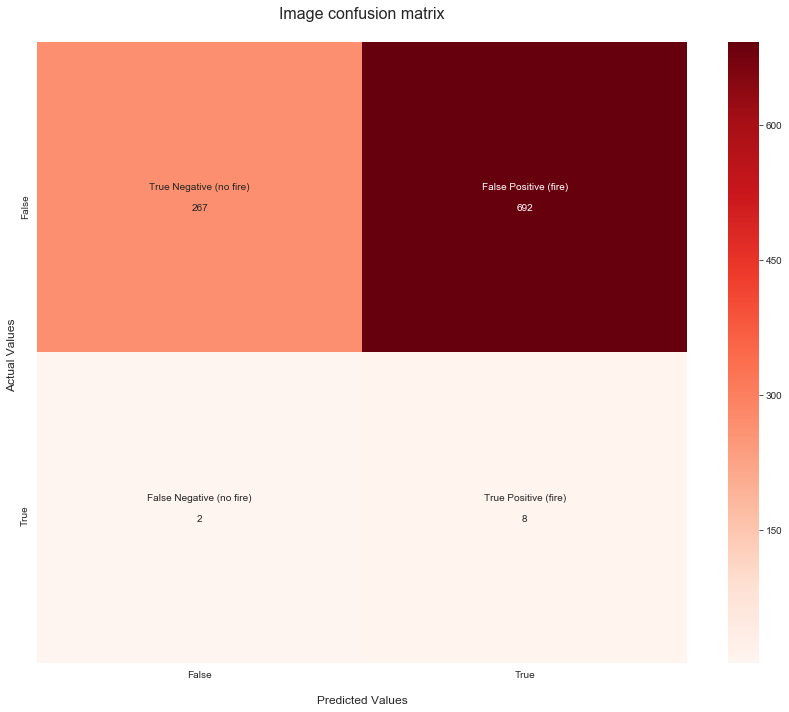

102


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
102,64,0.4,Nadam,0.0180071,0.992248,1,1,0.984375,"[[65, 0], [1, 63]]",9


31/31 [==============================] - 27s 341ms/step


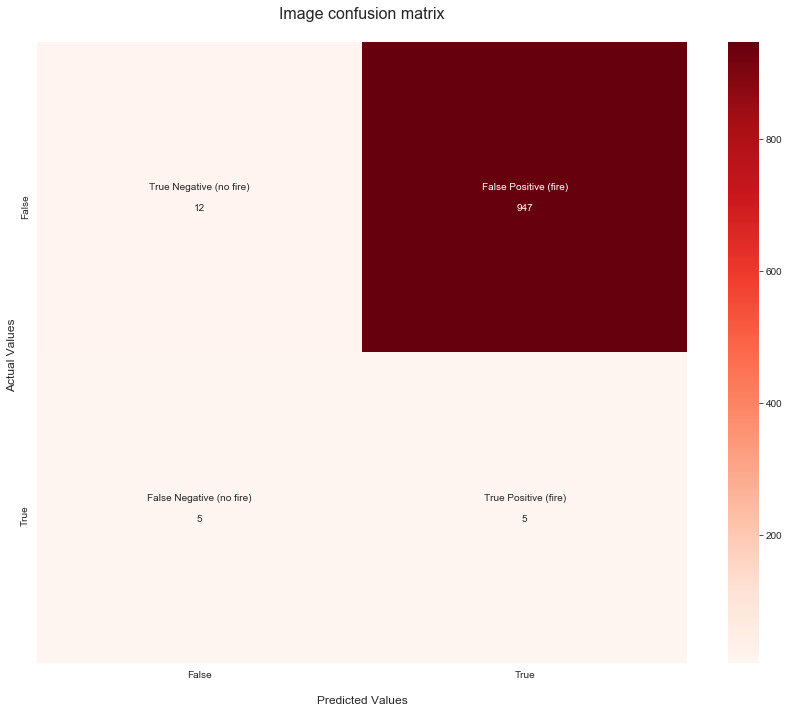

103


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
103,64,0.4,RMSprop,0.186437,0.96124,0,1,0.921875,"[[65, 0], [5, 59]]",9


31/31 [==============================] - 30s 342ms/step


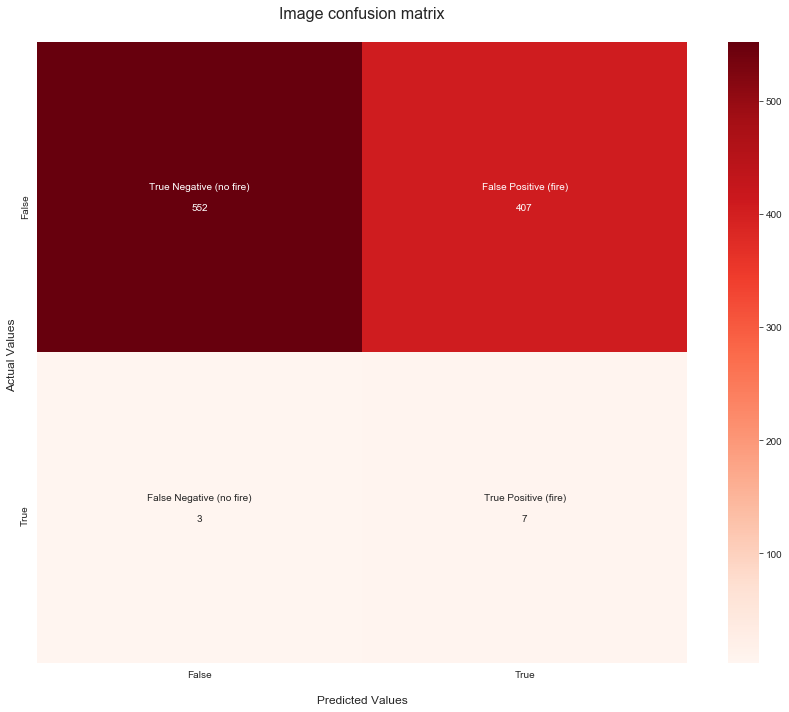

104


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
104,64,0.4,adam,0.0377575,0.992248,1,1,0.984375,"[[65, 0], [1, 63]]",9


31/31 [==============================] - 26s 342ms/step


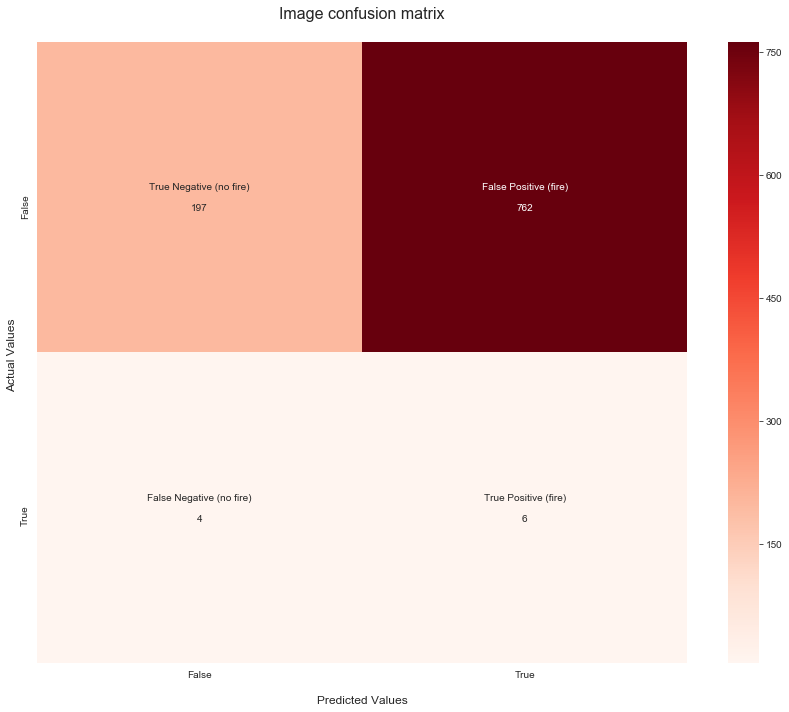

105


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
105,64,0.5,Nadam,0.0195992,0.992248,0,1,0.984375,"[[65, 0], [1, 63]]",9


31/31 [==============================] - 30s 346ms/step


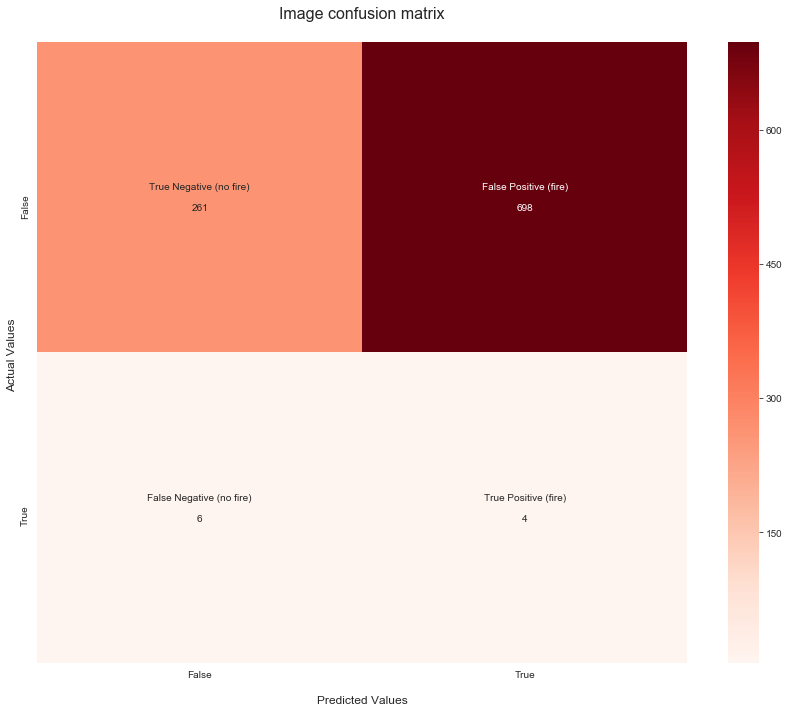

106


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
106,64,0.5,RMSprop,0.111311,0.96124,0.999279,1,0.921875,"[[65, 0], [5, 59]]",9


31/31 [==============================] - 28s 342ms/step


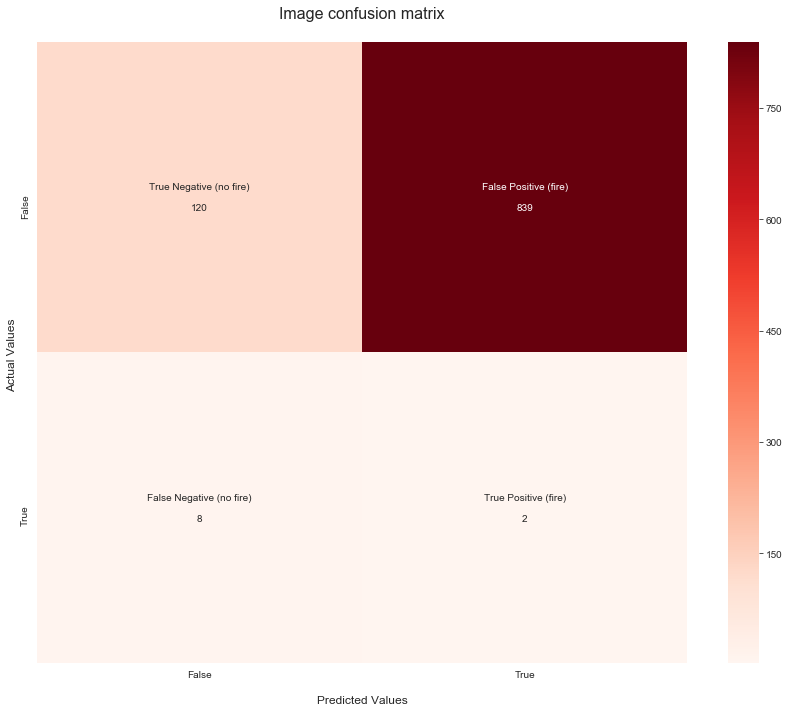

107


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
107,64,0.5,adam,0.0883699,0.976744,0,1,0.953125,"[[65, 0], [3, 61]]",9


31/31 [==============================] - 33s 342ms/step


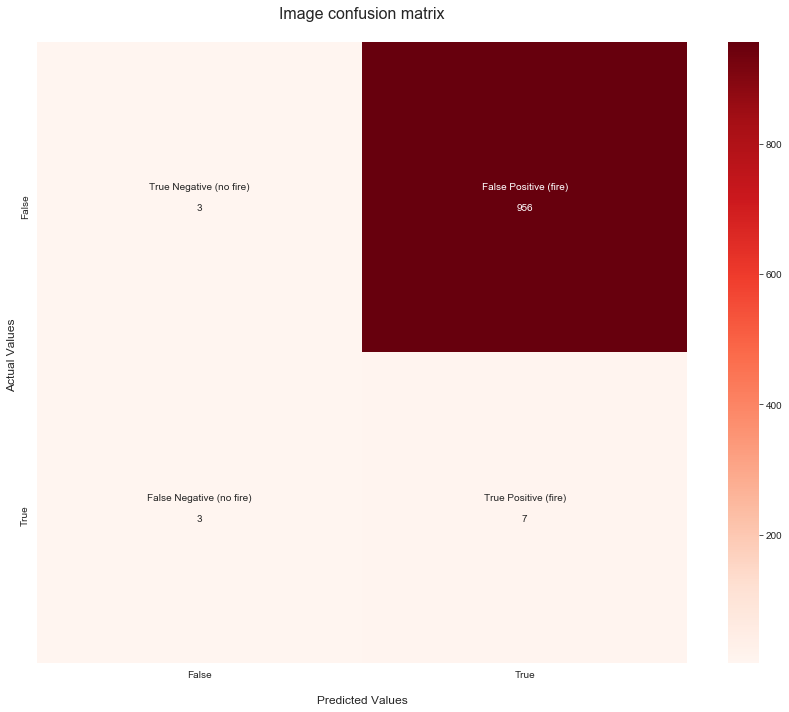

108


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
108,16,0.4,Nadam,0.0468499,0.984496,0.999038,1,0.96875,"[[65, 0], [2, 62]]",11


31/31 [==============================] - 27s 336ms/step


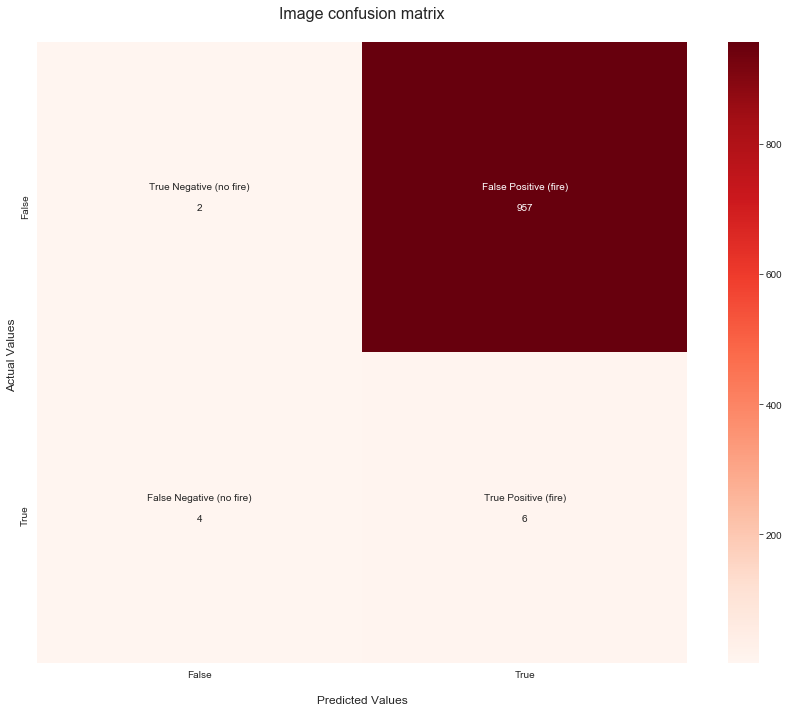

109


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
109,16,0.4,RMSprop,0.0411254,0.992248,0,1,0.984375,"[[65, 0], [1, 63]]",11


31/31 [==============================] - 30s 334ms/step


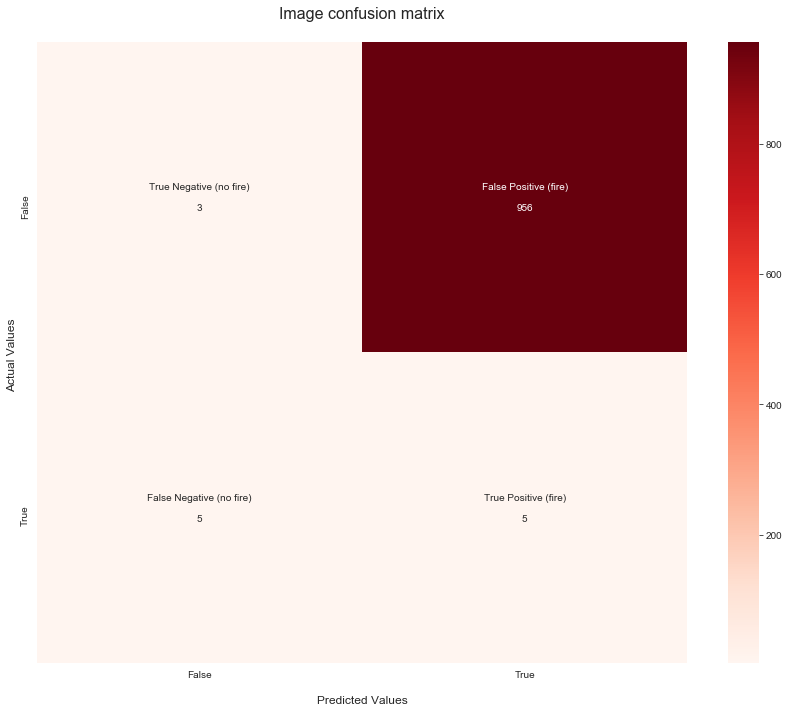

110


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
110,16,0.4,adam,0.0083526,1,1,1,1,"[[65, 0], [0, 64]]",11


31/31 [==============================] - 29s 332ms/step


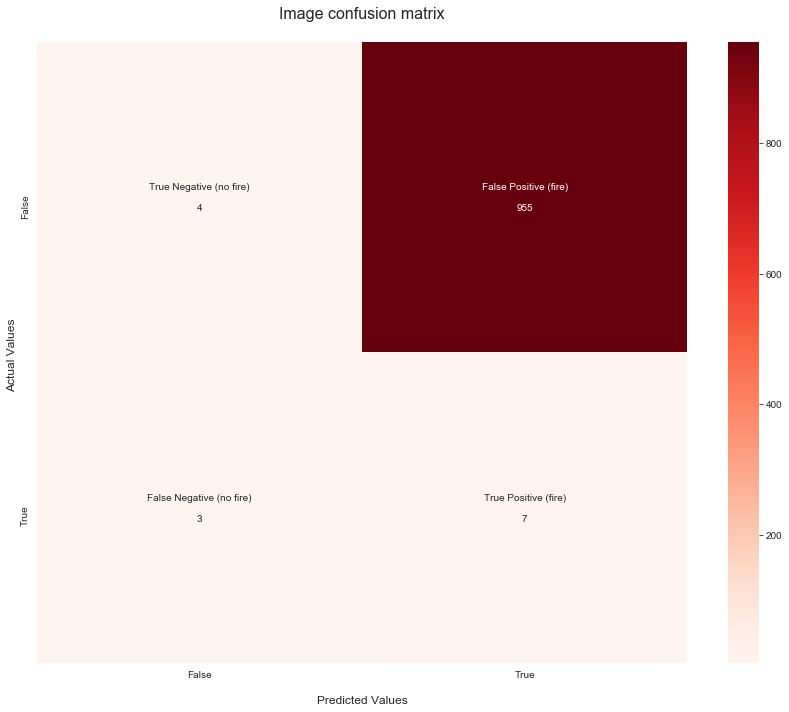

111


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
111,16,0.5,Nadam,0.0580659,0.984496,0,1,0.96875,"[[65, 0], [2, 62]]",11


31/31 [==============================] - 28s 334ms/step


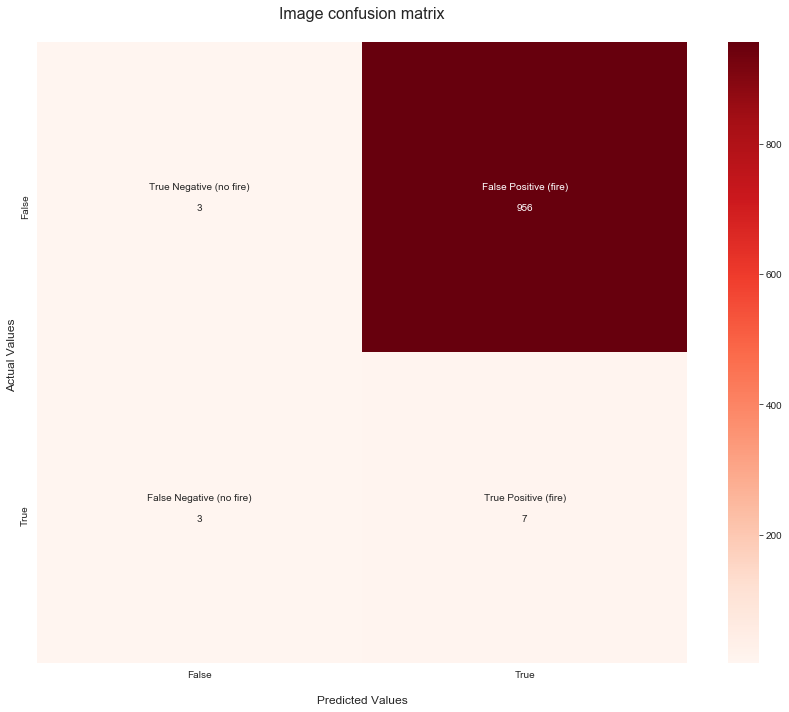

112


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
112,16,0.5,RMSprop,0.104525,0.968992,0.991707,0.954545,0.984375,"[[62, 3], [1, 63]]",11


31/31 [==============================] - 28s 335ms/step


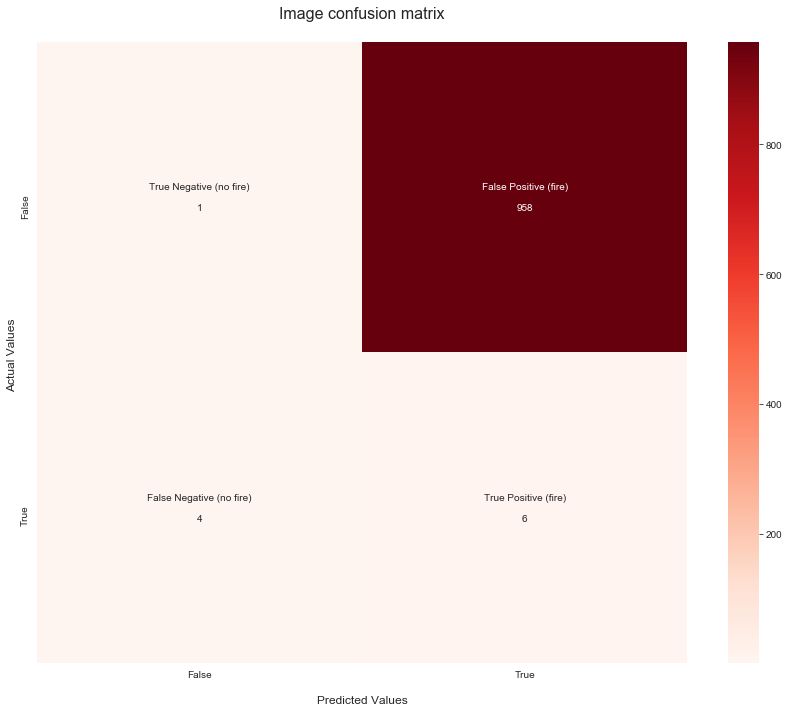

113


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
113,16,0.5,adam,0.121661,0.968992,0,1,0.9375,"[[65, 0], [4, 60]]",11


31/31 [==============================] - 25s 334ms/step


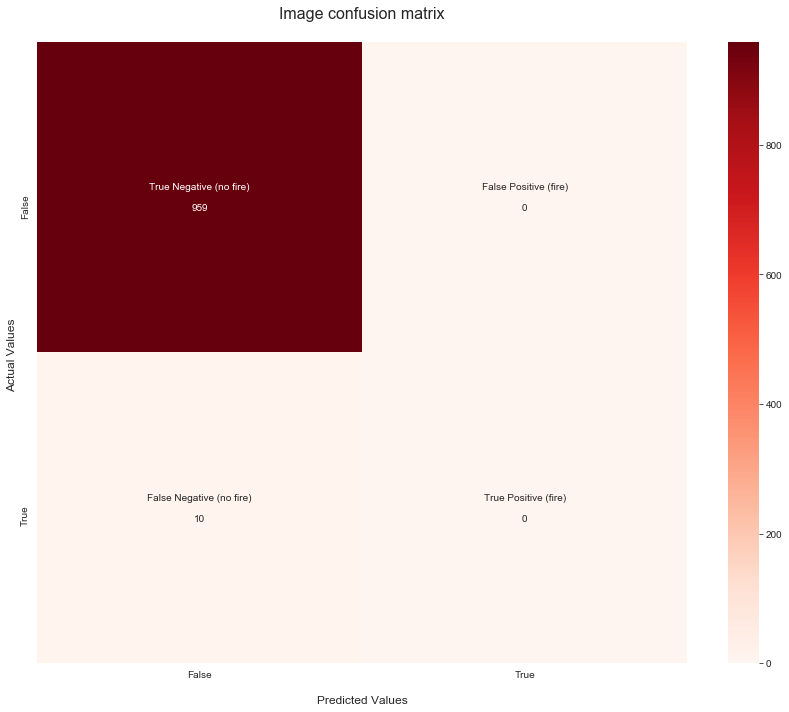

114


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
114,32,0.4,Nadam,0.0187555,0.992248,0.998798,1,0.984375,"[[65, 0], [1, 63]]",11


31/31 [==============================] - 30s 335ms/step


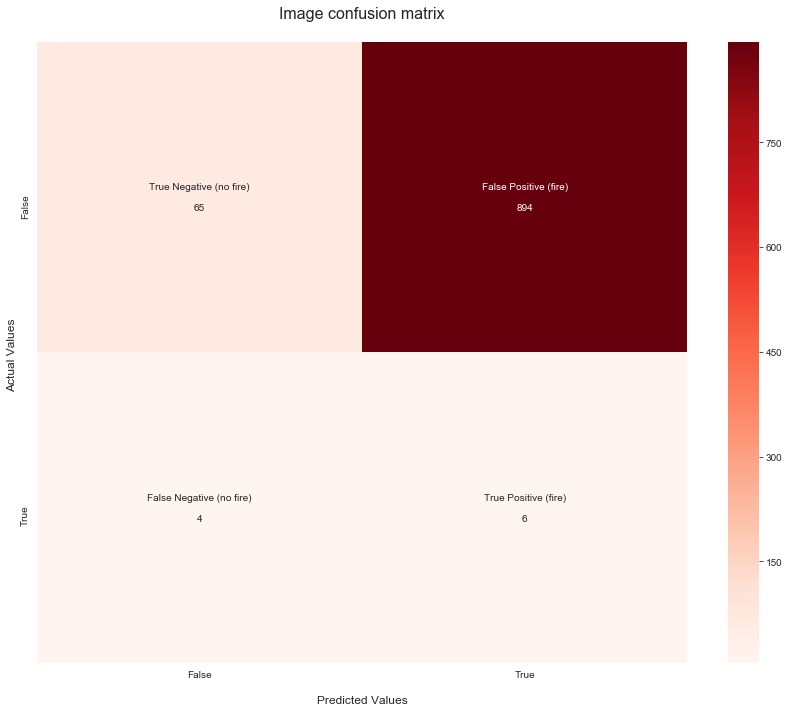

115


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
115,32,0.4,RMSprop,0.0364287,0.984496,0,1,0.96875,"[[65, 0], [2, 62]]",11


31/31 [==============================] - 27s 334ms/step


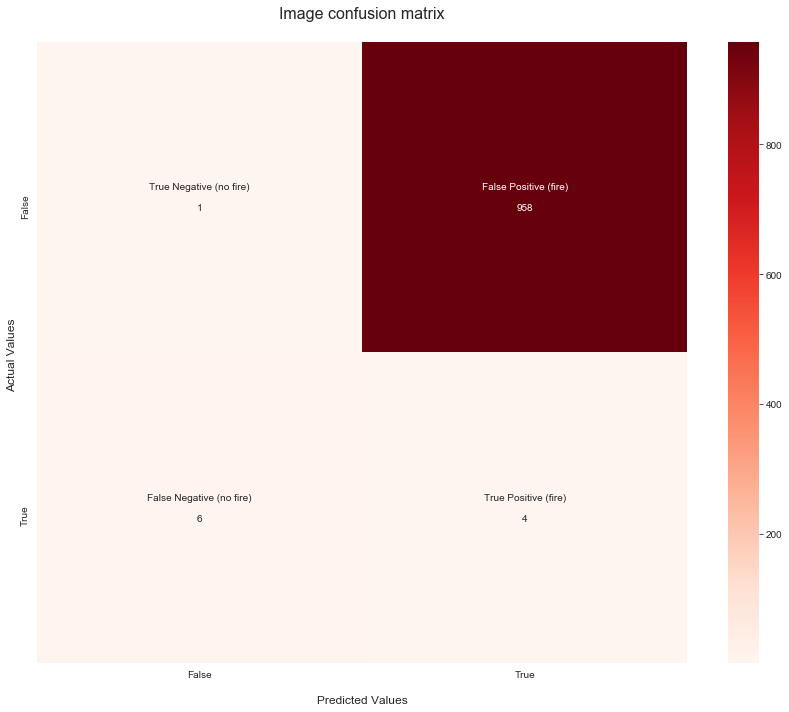

116


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
116,32,0.4,adam,0.291254,0.953488,0.988101,1,0.90625,"[[65, 0], [6, 58]]",11


31/31 [==============================] - 28s 337ms/step


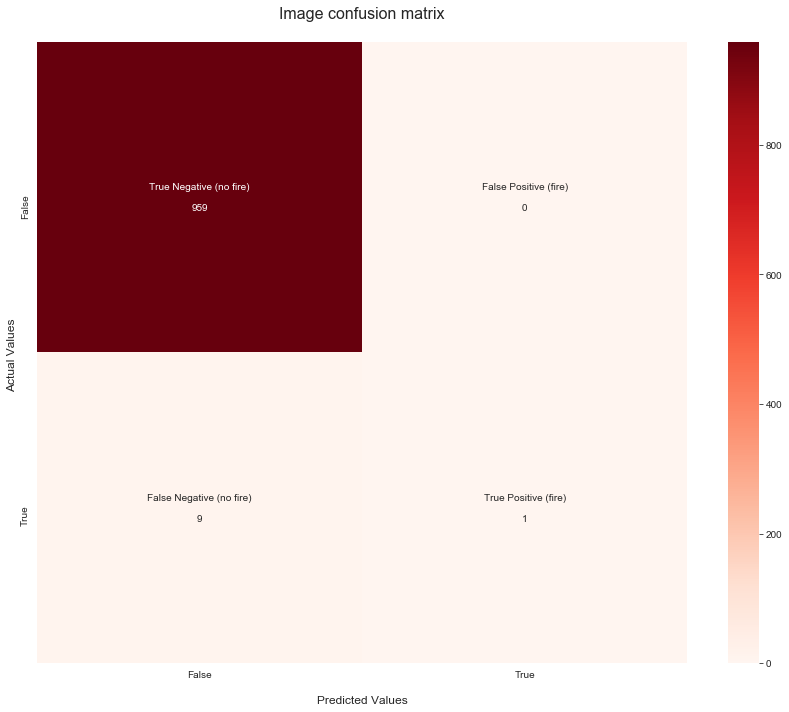

117


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
117,32,0.5,Nadam,0.0205462,0.992248,0,1,0.984375,"[[65, 0], [1, 63]]",11


31/31 [==============================] - 28s 338ms/step


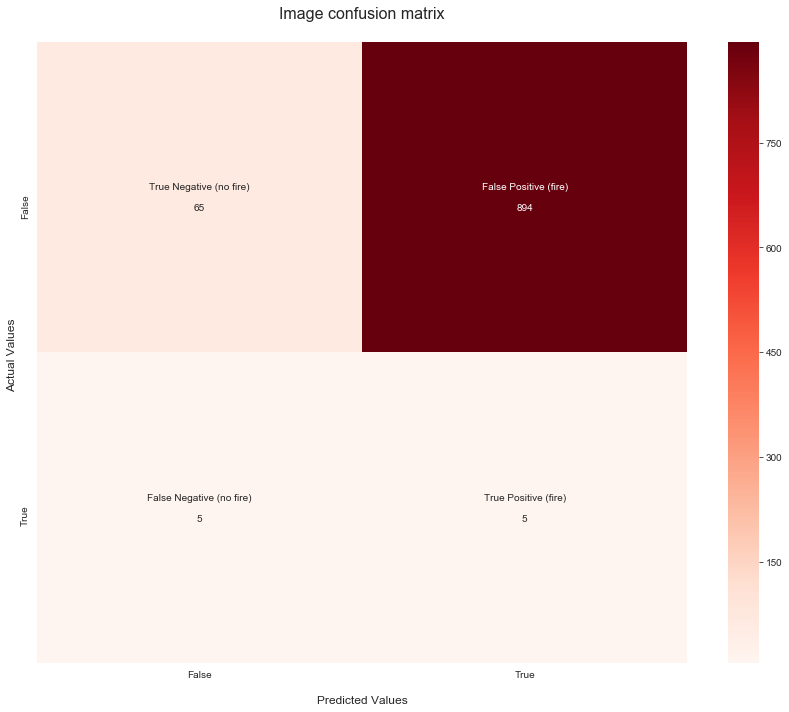

118


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
118,32,0.5,RMSprop,0.11981,0.96124,0.989904,0.927536,1,"[[60, 5], [0, 64]]",11


31/31 [==============================] - 29s 339ms/step


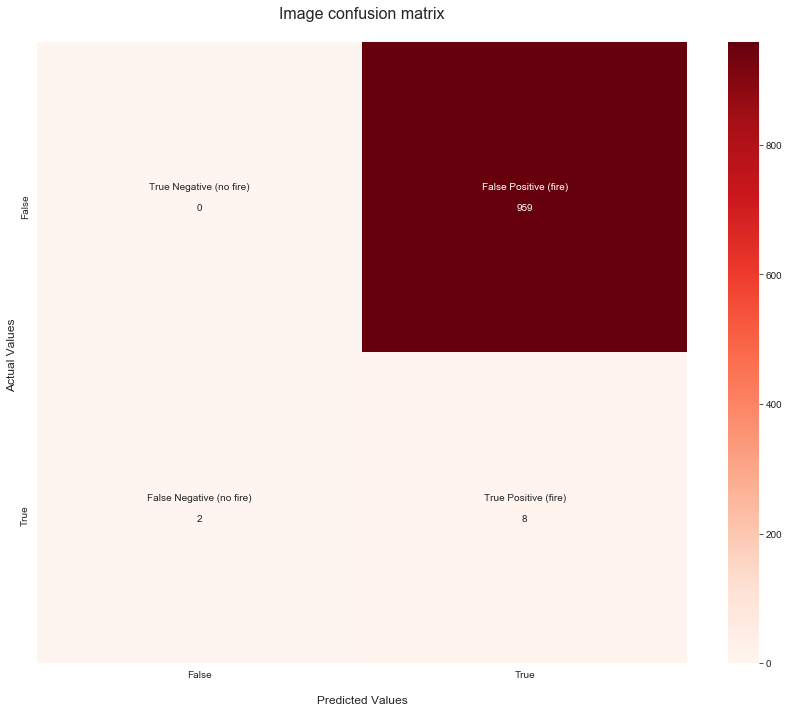

119


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
119,32,0.5,adam,0.0398772,0.984496,0,1,0.96875,"[[65, 0], [2, 62]]",11


31/31 [==============================] - 31s 338ms/step


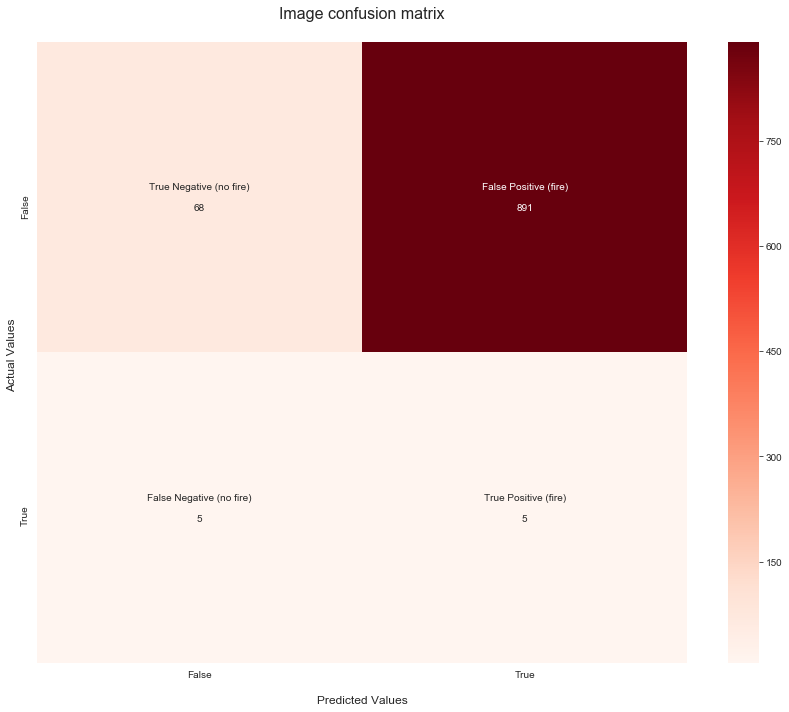

120


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
120,64,0.4,Nadam,0.0340045,0.992248,0.99976,1,0.984375,"[[65, 0], [1, 63]]",11


31/31 [==============================] - 27s 342ms/step


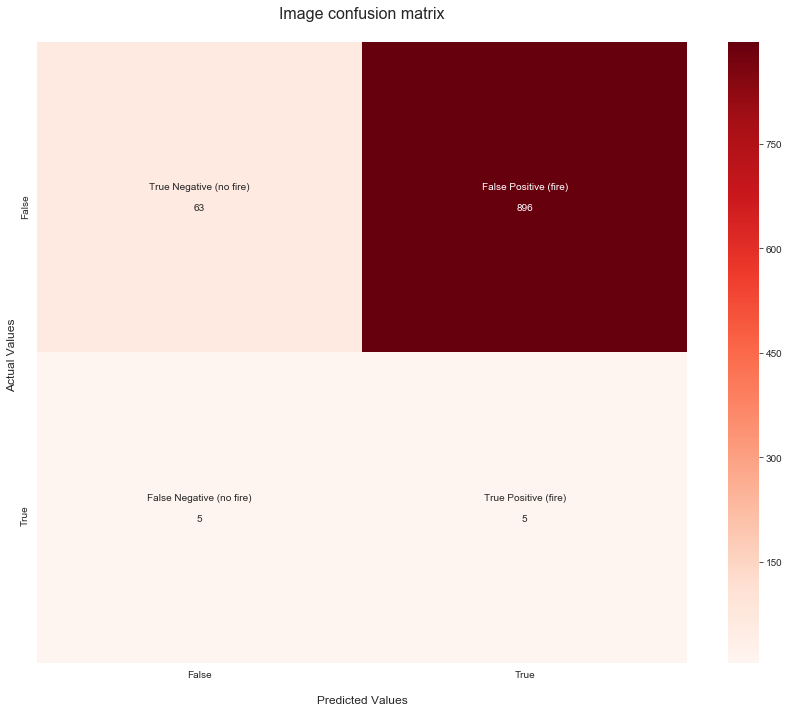

121


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
121,64,0.4,RMSprop,0.0560997,0.984496,0,1,0.96875,"[[65, 0], [2, 62]]",11


31/31 [==============================] - 33s 397ms/step


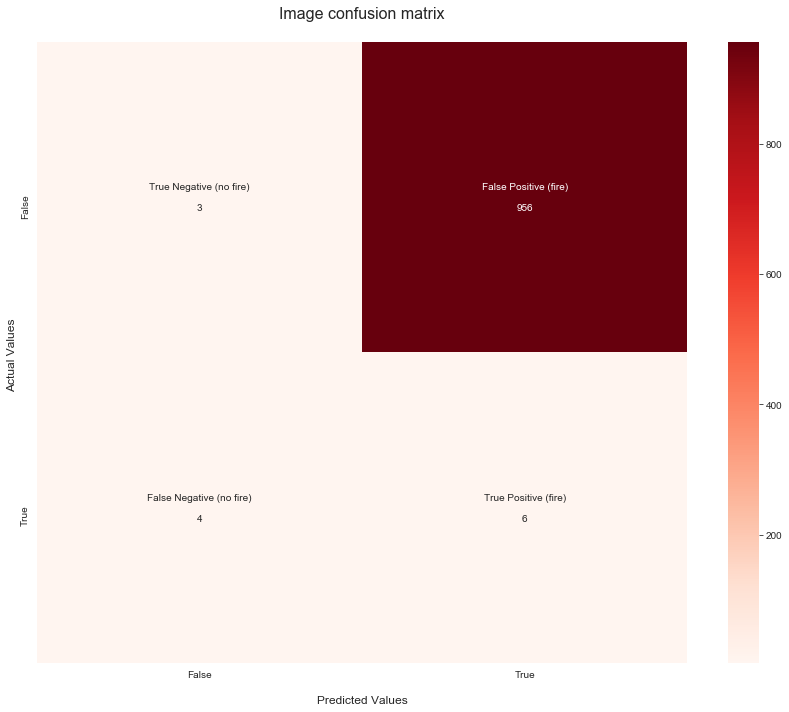

122


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
122,64,0.4,adam,0.0454749,0.984496,1,1,0.96875,"[[65, 0], [2, 62]]",11


31/31 [==============================] - 31s 381ms/step


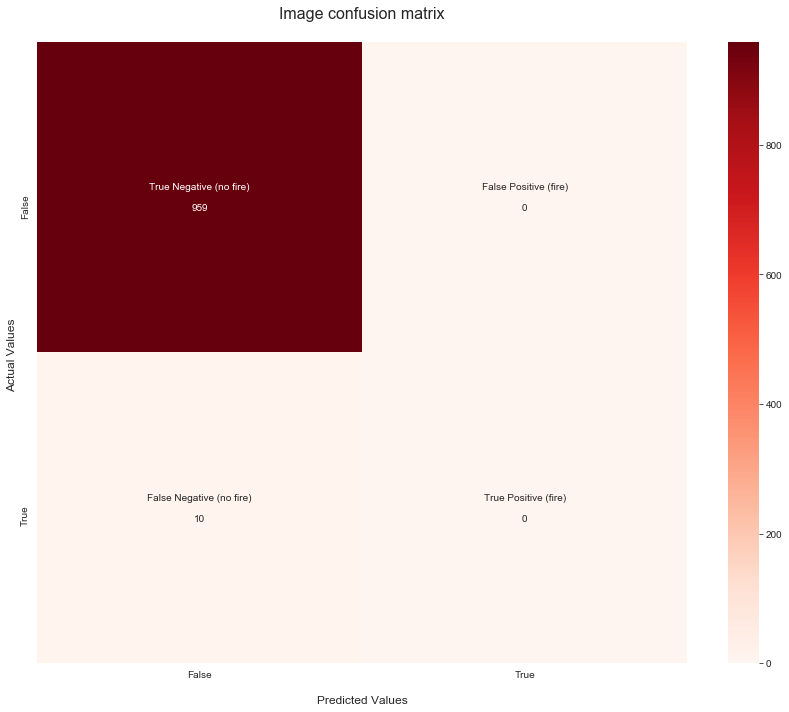

123


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
123,64,0.5,Nadam,0.0465228,0.976744,0,1,0.953125,"[[65, 0], [3, 61]]",11


31/31 [==============================] - 31s 352ms/step


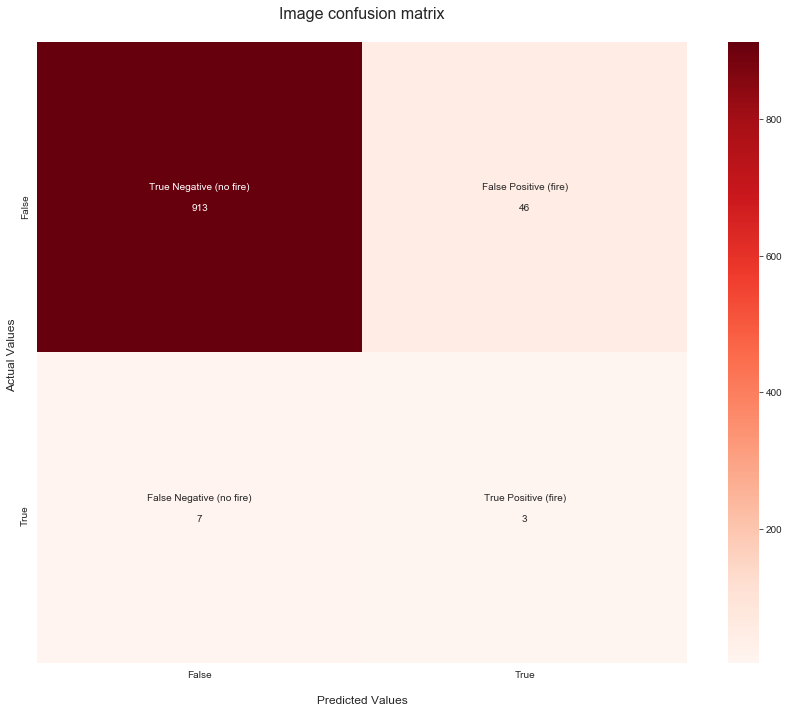

124


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
124,64,0.5,RMSprop,0.0408264,0.984496,0.995553,1,0.96875,"[[65, 0], [2, 62]]",11


31/31 [==============================] - 28s 355ms/step


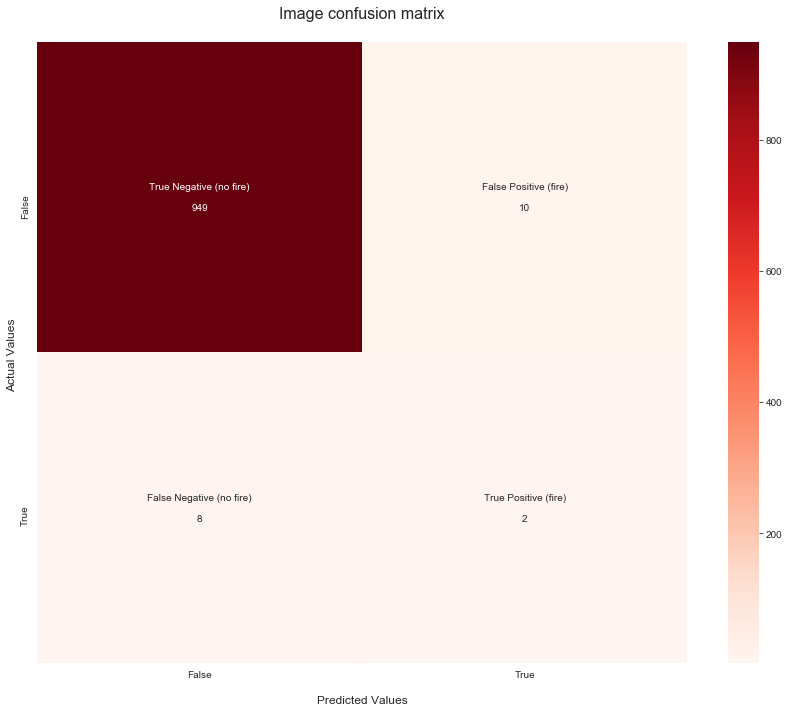

125


,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms,epochs
125,64,0.5,adam,0.0451335,0.992248,0,1,0.984375,"[[65, 0], [1, 63]]",11


31/31 [==============================] - 29s 343ms/step


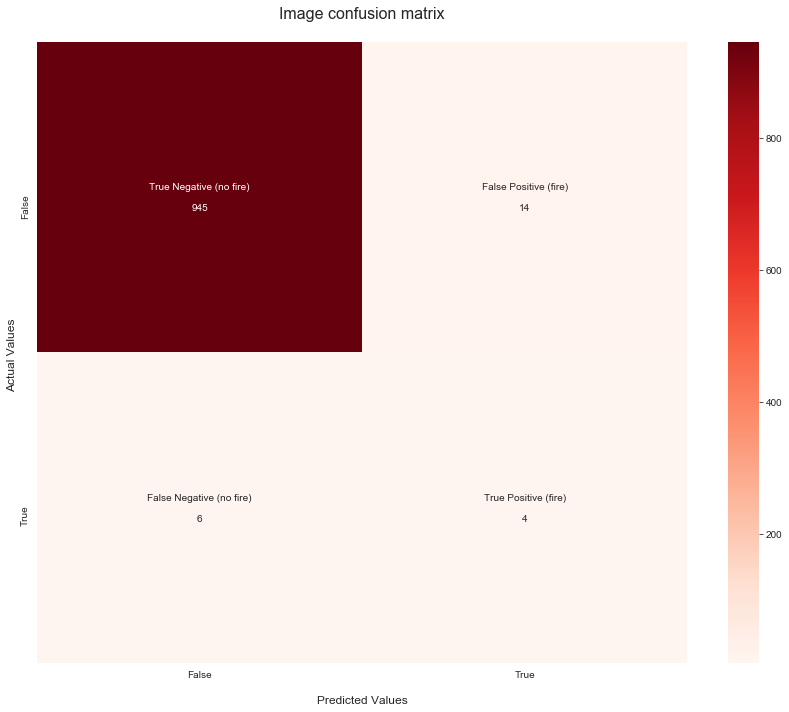

In [67]:
counter = 0
for model in modelz:

    model.save(f"artifacts/model_20201209_{counter}.h5")

    print(counter)
    display(pd.DataFrame(modelDf.iloc[counter]).T)
    counter+=1

    test_predictions = model.predict(hold_out_images, verbose = 1)

    scores = []
    for prediction in test_predictions:
        if prediction >= .75:
            scores.append(1)
        else:
            scores.append(0)

    plot_confusion_matrix_2(confusion_matrix(y_true=hold_out_labels, y_pred=scores),normalize=False)

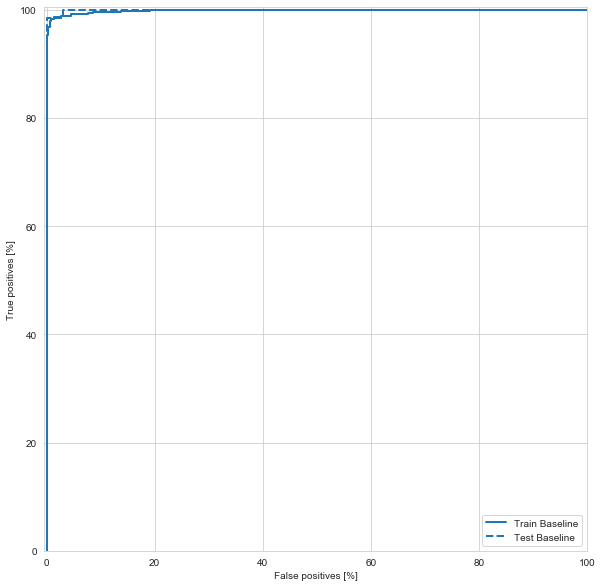

In [62]:
#1, 19, 25, 46, 75
model = modelz[1]

train_predictions_baseline = model.predict(train_images)
test_predictions_baseline = model.predict(test_images)

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [43]:
model.save("artifacts/model_20201207.h5")

In [60]:
line_chart(histories[75])

,epoch,variable,value
0,0,accuracy,0.724272
1,1,accuracy,0.944660
2,2,accuracy,0.966990
3,3,accuracy,0.972816
4,4,accuracy,0.961165


alt.Chart(...)